# Business Proposal

Business problem: What are the best 5 zip codes to invest in?

Business - A real estate investment firm looking to acquire new property to invest in.

Focus - Investing in real estate for high growth zip codes.

Approach - Look to see where everyone is moving to. Find the 25 highest historic ROI zipcodes. Run a model for all 25 and then pick the best 5 zipcodes with the highest ROI.

Chosen State: Idaho
 - Based off of Census and other surveys deciding to go with Idaho.

# Loading all necessary packages and loading data file

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from urllib.request import urlopen
import json
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.utils import tsdisplay
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipyleaflet import Map, Choropleth, basemaps



%matplotlib inline

from matplotlib import rcParams
plt.style.use('seaborn')
plt.rcParams['figure.figsize']=(12,6)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

In [2]:
# Importing the data for the project
data = pd.read_csv("Data/zillow_data.csv")

# Functions

In [3]:
# This function will calculate the mse

def mse_calc(data, prediction, start):
    y_hat = prediction.predicted_mean
    real_values = data[start:]['value']
    mse = ((real_values-y_hat)**2).mean()
    return mse

In [4]:
# This function will decompose the time series to see if there is any seasonality
# It will plot the original data, trend, seasonality and residuals

def Seasonal_check(data):

    decomposition = seasonal_decompose(data)

    # Gathering and plotting the trend, seasonality, and residuals 
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(data, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout()

In [5]:
# This function will plot the timeseries and the predicted values from the model

def PlotPredictions(obs_data, pred_data, pred_data_conf, beg='2013', title='title'):
    
    # Plot observed values
    ax = obs_data[beg:].plot(label='Observed')

    # Plot predicted values
    pred_data.predicted_mean.plot(ax=ax)

    # Plot the range for confidence intervals
    ax.fill_between(pred_data_conf.index,
                pred_data_conf.iloc[:, 0],
                pred_data_conf.iloc[:, 1], color='g', alpha=0.1)

    # Set axes labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.legend()
    plt.show()

In [6]:
def autobot(data, beg='2013', train_check_start='2016-10-01',
            train_check_end='2017-10-01', final_check_start='2017-10-01',
            final_check_end='2018-04-01', train_size=82, future=12):

    '''This function will automatically train/test split the data
Then grid search for the best parameters using auto_arima
Then create a model on the training data and check it against the test data
Finally it will create a final initial model that will give us a one year prediction
The function will return useful information about the model and predictions to put in a 
dataframe later on.'''    

    
    # Train size is 82 months, test size is 6 months
    train, test = train_test_split(data, train_size=train_size)
    
    # Using pm auto_arima to find the best parameters
    auto_model = pm.auto_arima(y=train['value'], start_p=0, start_q=0, max_p=5,
                               max_q=5, start_P=0, start_Q=0, max_P=5, max_Q=5,
                               m=12, max_order=None, trace=True)
    
    # Showing the best models summary
    print('Auto_model summary')
    display(auto_model.summary())
    
    
    # Getting the order and seasonal_order
    order = auto_model.order
    seasonal_order = auto_model.seasonal_order
    
    # Making the Initial SARIMAX model with the best parameters
    Train_model = SARIMAX(train['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    train_output = Train_model.fit()
    
    # Showing the train models summary
    print('Train_model summary')
    display(train_output.summary());
    
    # Getting One Step prediction to check train initial model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check train initial model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the train initial model does compared to the test
    train_forecast = train_output.get_forecast(steps = 6)
    train_forecast_conf = train_forecast.conf_int()
    
    
    # Calculating MSE for all predictions/forecast for train initial model
    train_mse = mse_calc(data=train, prediction=train_prediction, 
                         start=train_check_start)
    train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
                             start=train_check_start)
    train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
                                  start=final_check_start)
    train_forecast_rmse = np.sqrt(train_forecast_mse)
    
    
    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    
    # Showing the model summary for the model using the whole dataset
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final Initial model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final Initial model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting forecast to predict future prices
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()
    
    
    # Calculating MSE for all predictions for initial model
    final_mse = mse_calc(data=data, prediction=final_prediction, 
                         start=final_check_start)
    final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
                             start=final_check_start)
    final_dyn_rmse = np.sqrt(final_dyn_mse)

    # Showing the diagnostics of the final initial model
    Final_output.plot_diagnostics();
    
    # Plotting the predicted future price
    PlotPredictions(obs_data=data, 
                    pred_data=final_forecast, 
                    pred_data_conf=final_forecast_conf, title='data')
    
    # Returns useful information about the model and predictions to put in a 
    # dataframe later on.
    return [order, seasonal_order, train_mse, train_dyn_mse, train_forecast_mse,
            train_forecast_rmse, final_mse, final_dyn_mse, final_dyn_rmse,
            data.loc[final_check_end]['value'], final_forecast.predicted_mean[-1],
            final_forecast_conf.iloc[-1,0], final_forecast_conf.iloc[-1,1]]

In [7]:
# This function is used to try different sets of parameters for SARIMAX
# It will return a dataframe with the parameters and the aic values

def Grid_Auto_bot(data, order_list, seasonal_list, train_size=82):

    # Train test splits the data
    train, test = train_test_split(data, train_size=train_size)

    # Initializing an empty list for storing results
    results=[]

    # Going through and creating a model using all combinations of order/seasonal order
    # Also outputing order/seasonal order/aic score to a list
    for comb in order_list:
        for combs in seasonal_list:
            try:
                mod = SARIMAX(train['value'].astype('int'), order = comb, seasonal_order=combs,
                              enforce_stationarity = False, enforce_invertibility = False)
                output = mod.fit()
                results.append([comb,combs,output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
             
            except:
                continue
                
    # Creating a dataframe for the results
    ans_df = pd.DataFrame(results, columns=['pdq','pdqs','aic'])
    
    # Taking out any entries less than 300 aic (these would be models with errors)
    ans_df = ans_df[ans_df['aic'] > 300]
    
    # Making aic column into numeric
    ans_df['aic'] = pd.to_numeric(ans_df['aic'])
    
    return ans_df

In [8]:
# This function is used to check parameters for modeling
# It will only check one set of parameters at a time.
# Returns the one year future prediction also will display modeling data

def Manual_Param_Check(data,order,seasonal_order, beg='2013', train_check_start='2016-10-01',
            train_check_end='2017-10-01', final_check_start='2017-10-01',
            final_check_end='2018-04-01', train_size=82, future=12):
    
    # Train test split for the data
    train, test = train_test_split(data, train_size=train_size)

    # Making the Train SARIMAX model
    Train_model = SARIMAX(train['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    train_output = Train_model.fit()
    
    # Shows the Train model summary
    print('Train_model summary')
    display(train_output.summary());
    
    # Getting One Step prediction to check Train model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check Train model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the Train model does compared to the test data
    train_forecast = train_output.get_forecast(steps = 6)
    train_forecast_conf = train_forecast.conf_int()
    
    # Shows the diagnostics of the train model
    train_output.plot_diagnostics();
    
    # Plots the predictions of the train model
    PlotPredictions(obs_data=train, 
                    pred_data=train_prediction, 
                    pred_data_conf=train_prediction_conf,
                    title='Train one step prediction')
    PlotPredictions(obs_data=data, 
                    pred_data=train_prediction_dyn, 
                    pred_data_conf=train_prediction_dyn_conf,
                    title='Train dynamic prediction')
    PlotPredictions(obs_data=data, 
                    pred_data=train_forecast, 
                    pred_data_conf=train_forecast_conf,
                    title='Train forecasted test prediction')

    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    
    # Shows the summary output for the final model
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting future forecast 
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()

    # Shows the diagnostic output for the final model
    Final_output.plot_diagnostics();
    
    # Plots the future predicitions for the final model
    PlotPredictions(obs_data=data, 
                    pred_data=final_forecast, 
                    pred_data_conf=final_forecast_conf,
                    title='Final forecast')
    
    
    return final_forecast.predicted_mean[-1]

In [9]:
# This function is used to do a final SARIMAX modeling on the chosen parameters
# It will return useful information about the model and prediction that will
# be put into a dataframe later on.

def Final_zip_Check(data, order, seasonal_order, beg='2013', train_check_start='2016-10-01',
            train_check_end='2017-10-01', final_check_start='2017-10-01',
            final_check_end='2018-04-01', train_size=82, future=12):
        
    # Train size is 82 months, test size is 6 months
    train, test = train_test_split(data, train_size=train_size)
    
    
    # Making the train SARIMAX model
    Train_model = SARIMAX(train['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    train_output = Train_model.fit()
    
    # Shows the train model summary
    print('Train_model summary')
    display(train_output.summary());
    
    # Getting One Step prediction to check train model
    train_prediction = train_output.get_prediction(start=train_check_start,
                                           end=train_check_end,
                                           dynamic=False)
    train_prediction_conf = train_prediction.conf_int()
    
    # Getting dynamic prediction to check train model
    train_prediction_dyn = train_output.get_prediction(start=train_check_start, 
                                                     end=train_check_end, 
                                                     dynamic=True)
    train_prediction_dyn_conf = train_prediction_dyn.conf_int()
    
    #Getting forecast to see how well the train model does compared to the test data
    train_forecast = train_output.get_forecast(steps = 6)
    train_forecast_conf = train_forecast.conf_int()
    
    # Shows the diagnostics for the train model
    train_output.plot_diagnostics();
    
    # Plots the predictions from the train model
    PlotPredictions(obs_data=train, 
                    pred_data=train_prediction, 
                    pred_data_conf=train_prediction_conf,
                    title='Train one step prediction')
    PlotPredictions(obs_data=data, 
                    pred_data=train_prediction_dyn, 
                    pred_data_conf=train_prediction_dyn_conf,
                    title='Train dynamic prediction')
    PlotPredictions(obs_data=data, 
                    pred_data=train_forecast, 
                    pred_data_conf=train_forecast_conf,
                    title='Train forecasted test prediction')

        
    # Calculating MSE for all predictions/forecast for train model
    train_mse = mse_calc(data=train, prediction=train_prediction, 
                         start=train_check_start)
    train_dyn_mse = mse_calc(data=train, prediction=train_prediction_dyn, 
                             start=train_check_start)
    train_forecast_mse = mse_calc(data=data, prediction=train_forecast, 
                                  start=final_check_start)
    train_forecast_rmse = np.sqrt(train_forecast_mse)
    
    
    # Final model that's going to predict the future using both train + test
    Final_model = SARIMAX(data['value'].astype('int'),
                    order=order,
                    seasonal_order=seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
    Final_output = Final_model.fit()
    
    # Shows the final models summary
    print('Final_output summary')
    display(Final_output.summary());
 

    # Getting One Step prediction to check Final model
    final_prediction = Final_output.get_prediction(start=final_check_start,
                                           end=final_check_end,
                                           dynamic=False)
    final_prediction_conf = final_prediction.conf_int()
    
    # Getting dynamic prediction to check Final model
    final_prediction_dyn = Final_output.get_prediction(start=final_check_start, 
                                                     end=final_check_end, 
                                                     dynamic=True)
    final_prediction_dyn_conf = final_prediction_dyn.conf_int()
    
    #Getting future forecast for the final model
    final_forecast = Final_output.get_forecast(steps = future)
    final_forecast_conf = final_forecast.conf_int()

    
    # Calculating MSE for all predictions for final model
    final_mse = mse_calc(data=data, prediction=final_prediction, 
                         start=final_check_start)
    final_dyn_mse = mse_calc(data=data, prediction=final_prediction_dyn, 
                             start=final_check_start)
    final_dyn_rmse = np.sqrt(final_dyn_mse)
    
    # Shows the diagnostics for the final model
    Final_output.plot_diagnostics();
    
    # Plots the future predictions for the final model
    PlotPredictions(obs_data=data, 
                    pred_data=final_forecast, 
                    pred_data_conf=final_forecast_conf,
                    title='Final forecast')
    
    
    return [order, seasonal_order, train_mse, train_dyn_mse, train_forecast_mse,
            train_forecast_rmse, final_mse, final_dyn_mse, final_dyn_rmse,
            data.loc[final_check_end]['value'], final_forecast.predicted_mean[-1],
            final_forecast_conf.iloc[-1,0], final_forecast_conf.iloc[-1,1]]

# EDA

## General info about the dataset

In [10]:
data.head()

RegionID  RegionName      City State              Metro CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07    2003-08    2003-09    2003-10  \
0     84654       60657   Chicago    IL            Chicago       Cook         1  334200.0  335400.0  336500.0  337600.0  338500.0  339500.0  340400.0  341300.0  342600.0  344400.0  345700.0  346700.0  347800.0  349000.0  350400.0  352000.0  353900.0  356200.0  358800.0  361800.0  365700.0  370200.0  374700.0  378900.0  383500.0  388300.0  393300.0  398500.0  403800.0  409100.0  414600.0  420100.0  426200.0  432600.0  438600.0  444200.0  450000.0  455900.0  462100.0  468500.0  475300.0  482500.0  490200.0  498200.0  507200.0  516800.0  526300.0  535300.0  544500.0  553500.0  562400.0  571200.0  579800.0  588100.0  596300.0  604200.0  612200.0  620200.0  627700.0  634500.0  641000.0  647000.0  652700.0  658100.0  663300.0  668400.0  673400.0  678300.0  683200.0  688300.0  693300.0  698000.0  702400.0  706400.0  710200.0  714000.0  717800.0  721700.0  725700.0  729900.0  733400.0  735600.0  737200.0  739000.0  740900.0  742700.0  744400.0  746000.0   747200.0   748000.0   749000.0   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin         2  235700.0  236900.0  236700.0  235400.0  233300.0  230600.0  227300.0  223400.0  219600.0  215800.0  211100.0  205700.0  200900.0  196800.0  193600.0  191400.0  190400.0  190800.0  192700.0  196000.0  201300.0  207400.0  212200.0  214600.0  215100.0  213400.0  210200.0  206100.0  202100.0  198800.0  196100.0  194100.0  193400.0  193400.0  193100.0  192700.0  193000.0  193700.0  194800.0  196100.0  197800.0  199700.0  201900.0  204500.0  207800.0  211500.0  214900.0  217800.0  221100.0  224100.0  226700.0  228200.0  228500.0  227200.0  224900.0  221900.0  219100.0  216900.0  215400.0  214500.0  214600.0  215600.0  217000.0  218400.0  219600.0  220000.0  219100.0  216800.0  213100.0  208700.0  204000.0  199600.0  195700.0  192800.0  190800.0  189600.0  189200.0  189200.0  189600.0  190300.0  190800.0  191000.0  190700.0  190300.0  189800.0  189200.0  188600.0  188000.0   187500.0   187200.0   187000.0   
2     91982       77494      Katy    TX            Houston     Harris         3  210400.0  212200.0  212200.0  210700.0  208300.0  205500.0  202500.0  199800.0  198300.0  197300.0  195400.0  193000.0  191800.0  191800.0  193000.0  195200.0  198400.0  202800.0  208000.0  213800.0  220700.0  227500.0  231800.0  233400.0  233900.0  233500.0  233300.0  234300.0  237400.0  242800.0  250200.0  258600.0  268000.0  277000.0  283600.0  288500.0  293900.0  299200.0  304300.0  308600.0  311400.0  312300.0  311900.0  311100.0  311700.0  313500.0  315000.0  316700.0  319800.0  323700.0  327500.0  329900.0  329800.0  326400.0  320100.0  312200.0  304700.0  298700.0  294300.0  291400.0  290800.0  291600.0  293000.0  293600.0  292900.0  290500.0  286700.0  282200.0  276900.0  271000.0  264200.0  257000.0  249700.0  243100.0  237000.0  231700.0  227100.0  223300.0  220300.0  217300.0  214700.0  213800.0  215100.0  217300.0  219600.0  221400.0  222300.0  222700.0   223000.0   223700.0   225100.0   
3     84616       6

In [11]:
data.tail()

RegionID  RegionName                 City State            Metro CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09  \
14718     58333        1338             Ashfield    MA  Greenfield Town   Franklin     14719   94600.0   94300.0   94000.0   93700.0   93400.0   93200.0   93000.0   92900.0   92700.0   92600.0   92600.0   92600.0   92800.0   93100.0   93500.0   94000.0   94500.0   95100.0   95800.0   96500.0   97100.0   97800.0   98500.0   99200.0  100000.0  100800.0  101700.0  102600.0  103400.0  104200.0  104900.0  105600.0  106300.0  106800.0  107300.0  107800.0  108400.0  109000.0  109600.0  110200.0  110800.0  111400.0  112000.0  112600.0  113000.0  113500.0  113900.0  114300.0  114800.0  115400.0  116000.0  116700.0  117400.0  118100.0  118700.0  119500.0  120100.0  120600.0  121100.0  121700.0  122400.0  123300.0  124200.0  125300.0  126300.0  127400.0  128500.0  129600.0  130600.0  131400.0  132100.0  133000.0  133900.0  134900.0  136000.0  137200.0  138500.0  139700.0  140900.0  141900.0  143600.0  146300.0  149100.0  150900.0  151800.0  152000.0  151700.0  151700.0  152500.0  154200.0   
14719     59107        3293            Woodstock    NH        Claremont    Grafton     14720   92700.0   92500.0   92400.0   92200.0   92100.0   91900.0   91700.0   91300.0   90900.0   90500.0   90100.0   89800.0   89600.0   89400.0   89300.0   89200.0   89100.0   88900.0   88700.0   88400.0   88100.0   87700.0   87400.0   87200.0   87100.0   87100.0   87100.0   87200.0   87300.0   87300.0   87400.0   87300.0   87300.0   87200.0   87300.0   87400.0   87600.0   87900.0   88300.0   88700.0   89200.0   89600.0   90000.0   90300.0   90500.0   90700.0   91000.0   91300.0   91700.0   92300.0   93000.0   93700.0   94400.0   95000.0   95600.0   96100.0   96400.0   96800.0   97200.0   97800.0   98600.0   99600.0  100600.0  101700.0  102800.0  103800.0  104800.0  105600.0  106200.0  106900.0  107700.0  108600.0  109900.0  111400.0  112900.0  114600.0  116200.0  117700.0  118900.0  120300.0  121800.0  123200.0  124700.0  126600.0  128800.0  131000.0  132700.0  133900.0  134800.0  135600.0   
14720     75672       40404                Berea    KY         Richmond    Madison     14721   57100.0   57300.0   57500.0   57700.0   58000.0   58200.0   58400.0   58700.0   59100.0   59500.0   59900.0   60300.0   60800.0   61300.0   62000.0   62600.0   63200.0   63800.0   64500.0   65200.0   65900.0   66700.0   67400.0   68200.0   69000.0   69800.0   70700.0   71500.0   72300.0   73000.0   73700.0   74300.0   74900.0   75500.0   76000.0   76400.0   76900.0   77300.0   77700.0   78000.0   78200.0   78400.0   78400.0   78400.0   78500.0   78600.0   78600.0   78600.0   78700.0   78900.0   79200.0   79400.0   79600.0   79900.0   80100.0   80300.0   80600.0   80900.0   81100.0   81500.0   81800.0   82300.0   82700.0   83200.0   83600.0   84000.0   84100.0   84300.0   84500.0   84600.0   84600.0   84700.0   84800.0   85000.0   85200.0   85400.0   85500.0   85500.0   85600.0   85100.0   84200.0   83700.0   84000.0   84600.0   85500.0   86500.0   87700.0   89100.0   90600.0   92200.0   
14721     93733       8

In [12]:
data.shape

(14723, 272)

In [13]:
print('The data has {} number of entries. The number of unique RegionNames is {}.'.format(
    data.shape[0], data['RegionName'].nunique()))
print('There seems to be no duplicate entries.')

The data has 14723 number of entries. The number of unique RegionNames is 14723.
There seems to be no duplicate entries.


In [14]:
print('This dataset looks at {} different "states" (includes DC).'.format(
    data['State'].nunique()))

This dataset looks at 51 different "states" (includes DC).


In [15]:
print('This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.')

This dataset looks at median prices of houses of a given zipcode from 1996-04 to 2018-04.


## Looking at missing values in the dataframe

In [16]:
#Seeing how many na values are in the dataset
print('There are {} Nan values in the dataset.'.format(data.isna().sum().sum()))

There are 157934 Nan values in the dataset.


In [17]:
#Checking to see what columns have na values.
column_names = data.columns
na_columns = []
for name in column_names:
    NumberOfNa = 0
    NumberOfNa = data[name].isna().sum()
    if NumberOfNa > 0:
        na_columns.append(name)
print('There are {} columns that have na values.'.format(len(na_columns)))
print('Only identifier column with na is "Metro", the others are missing values for dates')

There are 220 columns that have na values.
Only identifier column with na is "Metro", the others are missing values for dates


In [18]:
# Looking at the entries with Nan values for Metro
print('There are {} entries with NaN for metro.'.format(
    len(data.loc[lambda x: x.Metro.isna()])))

data.loc[lambda x: x.Metro.isna()].head()

There are 1043 entries with NaN for metro.


RegionID  RegionName        City State Metro CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11  \
151     69340       27410  Greensboro    NC   NaN   Guilford       152  137100.0  136600.0  136000.0  135600.0  135300.0  135100.0  135200.0  135600.0  136100.0  136700.0  137500.0  138300.0  139000.0  139600.0  140000.0  140200.0  140400.0  140400.0  140400.0  140400.0  140400.0  140400.0  140600.0  141000.0  141600.0  142500.0  143700.0  145000.0  146400.0  147600.0  148800.0  149700.0  150500.0  150900.0  151300.0  151500.0  151600.0  151800.0  152100.0  152400.0  152900.0  153400.0  154000.0  154600.0  155300.0  156000.0  156700.0  157500.0  158400.0  159100.0  159900.0  160400.0  160900.0  161200.0  161400.0  161400.0  161300.0  161000.0  160800.0  160500.0  160300.0  160000.0  159800.0  159800.0  159900.0  160100.0  160400.0  160700.0  161200.0  161700.0  162200.0  162900.0  163700.0  164500.0  165200.0  165900.0  166400.0  166900.0  167400.0  167800.0  168300.0  168700.0  169000.0  169200.0  169500.0  169700.0  170000.0  170400.0  170700.0  171100.0  171400.0  171900.0   
167     69336       27406  Greensboro    NC   NaN   Guilford       168   80900.0   80700.0   80400.0   80200.0   80000.0   79800.0   79800.0   79900.0   80200.0   80500.0   81000.0   81600.0   82300.0   83000.0   83700.0   84300.0   84900.0   85300.0   85600.0   85700.0   85500.0   85200.0   84800.0   84200.0   83800.0   83700.0   83800.0   84100.0   84500.0   85000.0   85400.0   85900.0   86300.0   86700.0   87100.0   87400.0   87800.0   88100.0   88400.0   88800.0   89100.0   89500.0   90000.0   90500.0   91000.0   91500.0   92100.0   92600.0   93100.0   93400.0   93600.0   93700.0   93800.0   93800.0   93900.0   94000.0   94100.0   94300.0   94500.0   94600.0   94700.0   94700.0   94700.0   94700.0   94800.0   94900.0   95000.0   95200.0   95500.0   95700.0   96000.0   96200.0   96400.0   96500.0   96600.0   96600.0   96600.0   96700.0   96900.0   97100.0   97300.0   97600.0   97700.0   97800.0   97800.0   97800.0   97800.0   97800.0   97900.0   98000.0   98000.0   97900.0   
491     69270       27265  High Point    NC   NaN   Guilford       492  108000.0  107700.0  107400.0  107100.0  106900.0  106900.0  106900.0  107100.0  107400.0  107700.0  108100.0  108500.0  109000.0  109600.0  110300.0  111100.0  111800.0  112500.0  113000.0  113300.0  113500.0  113700.0  113900.0  114200.0  114800.0  115600.0  116400.0  117200.0  117900.0  118600.0  119300.0  119900.0  120500.0  121200.0  121800.0  122400.0  122900.0  123500.0  124000.0  124400.0  124900.0  125400.0  125900.0  126500.0  127100.0  127700.0  128200.0  128600.0  129000.0  129300.0  129600.0  129900.0  130200.0  130500.0  130700.0  130900.0  131100.0  131300.0  131500.0  131700.0  131900.0  132100.0  132300.0  132600.0  132700.0  133000.0  133200.0  133500.0  133700.0  133900.0  134100.0  134200.0  134300.0  134300.0  134200.0  134200.0  134200.0  134400.0  134600.0  134900.0  135300.0  135600.0  136000.0  136300.0  136600.0  136900.0  137200.0  137400.0  137600.0  137700.0  137900.0  137900.0   
526     69337       27407  Gr

In [19]:
# We can drop all the identifiers besides State, City and RegionName (Zipcode)
data_ZipcodeID = data.drop(['RegionID', 'Metro', 'CountyName', 'SizeRank'], axis=1)

In [20]:
# Creating a Dataframe with all entries that have any NA values
null_data = data_ZipcodeID[data_ZipcodeID.isnull().any(axis=1)]
print('There are {} entries with atleast one NaN value for a month entry'.format(len(null_data)))
null_data.head()

There are 1039 entries with atleast one NaN value for a month entry


RegionName        City State  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06  2003-07  2003-08  2003-09  2003-10  2003-11  2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12  \
20        10011    New York    NY      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
36        10456    New York    NY      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
105       60611     Chicago    IL      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
156       11238    New York  

A lot of the Nan values seem to be coming from possible newer properties that have been built.

In [21]:
print('The newest zipcode property, aka the last timestamp that has any nan value is {}.'.format(
    null_data.columns[null_data.isnull().any()][-1]))

The newest zipcode property, aka the last timestamp that has any nan value is 2014-06.


## Narrowing down dataset to Idaho

In [22]:
# Creating Idaho dataframe
Idaho = data_ZipcodeID[data_ZipcodeID['State'] == 'ID']
Idaho.head()

RegionName        City State   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03  \
448        83301  Twin Falls    ID   94100.0   94100.0   94200.0   94200.0   94300.0   94400.0   94700.0   95200.0   96000.0   97000.0   98400.0   99900.0  101600.0  103200.0  104600.0  105700.0  106500.0  106900.0  106900.0  106500.0  105600.0  104600.0  103500.0  102600.0  101800.0  101400.0  101300.0  101300.0  101600.0  101900.0  102200.0  102500.0  102700.0  103000.0  103200.0  103200.0  103100.0  102900.0  102600.0  102400.0  102300.0  102400.0  102600.0  103000.0  103500.0  104000.0  104700.0  105400.0  106100.0  106900.0  107700.0  108500.0  109300.0  110200.0  111000.0  111700.0  112400.0  112900.0  113300.0  113400.0  113200.0  112600.0  111700.0  110700.0  109700.0  108800.0  108100.0  107800.0  107700.0  107700.0  107900.0  108200.0  108600.0  109000.0  109400.0  109900.0  110300.0  110500.0  110800.0  111000.0  111200.0  111400.0  111600.0  111900.0  112300.0  112700.0  113100.0  113400.0  113700.0  114000.0  114400.0  114700.0  115200.0  115800.0  116600.0  117400.0   
596        83709       Boise    ID  118900.0  118800.0  118700.0  118500.0  118400.0  118300.0  118400.0  118700.0  119200.0  120100.0  121400.0  123100.0  125000.0  127200.0  129300.0  131200.0  132800.0  134200.0  135200.0  135900.0  136400.0  136600.0  136700.0  136600.0  136300.0  136000.0  135600.0  135200.0  135000.0  134800.0  134800.0  135000.0  135300.0  135600.0  135900.0  136100.0  136200.0  136300.0  136200.0  136200.0  136100.0  136000.0  136000.0  136000.0  136100.0  136300.0  136500.0  136600.0  136800.0  136900.0  137000.0  137200.0  137400.0  137500.0  137700.0  138100.0  138500.0  139000.0  139600.0  140100.0  140600.0  141100.0  141600.0  142000.0  142400.0  142800.0  143200.0  143600.0  144100.0  144700.0  145200.0  145700.0  146100.0  146400.0  146600.0  146600.0  146600.0  146500.0  146300.0  146200.0  146100.0  146000.0  146100.0  146200.0  146300.0  146600.0  147000.0  147400.0  147800.0  148100.0  148400.0  148600.0  149000.0  149600.0  150300.0  150900.0   
1178       83686       Nampa    ID   99500.0   99400.0   99400.0   99400.0   99500.0   99600.0   99900.0  100400.0  101100.0  102200.0  103700.0  105600.0  107700.0  110000.0  112200.0  114300.0  116000.0  117400.0  118500.0  119300.0  119800.0  120000.0  120100.0  120000.0  119900.0  119700.0  119700.0  119700.0  119800.0  120000.0  120200.0  120400.0  120600.0  120600.0  120700.0  120700.0  120700.0  120800.0  120800.0  120900.0  121000.0  121200.0  121400.0  121700.0  122000.0  122300.0  122700.0  123200.0  123600.0  124100.0  124700.0  125200.0  125600.0  126000.0  126300.0  126500.0  126600.0  126500.0  126300.0  125800.0  125100.0  124100.0  122900.0  121600.0  120200.0  119100.0  118200.0  117500.0  117200.0  117000.0  117000.0  117200.0  117500.0  117900.0  118300.0  118800.0  119200.0  119600.0  120000.0  120400.0  120900.0  121400.0  121900.0  122400.0  123000.0  123600.0  124100.0  124500.0  124900.0  125100.0  125400.0  125700.0  126200.0  126700.0  127200.0  127600.0   
1343       837

In [23]:
# Creating a Dataframe with all entries that have any NA values for Idaho
Idaho_null = Idaho[Idaho.isnull().any(axis=1)]
print('There are {} zip codes on record for Idaho.'.format(len(Idaho)))
print('There are {} zip codes that have missing entries'.format(len(Idaho_null)))
Idaho_null.head()

There are 110 zip codes on record for Idaho.
There are 15 zip codes that have missing entries


RegionName          City State  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11  \
7742        83333        Hailey    ID      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
8131        83340       Ketchum    ID      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
9232        83263       Preston    ID      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN  172100.0  170400.0  168600.0  167300.0  166000.0  164400.0  163100.0  162900.0  163700.0  165200.0  167400.0  169800.0  172300.0  174500.0  176500.0  178800.0  181000.0   
11485       83353    Sun Valley

In [24]:
print('The newest Idaho zipcode property, aka the last timestamp that has any NaN value is {}.'.format(
    Idaho_null.columns[Idaho_null.isnull().any()][-1]))

The newest Idaho zipcode property, aka the last timestamp that has any NaN value is 2011-12.


Decided to only look at properties that have atleast 10 years worth of data. The reason is that we want to pick zipcodes that have been established already and not starting out.

In [25]:
#Dropping any zipcodes that do not have 10 years worth of data
Idaho = Idaho.drop(Idaho[Idaho['2008-04'].isnull()].index)

#Dropping columns for any previous data older than 10 years.
Idaho.dropna(axis=1, how='any', inplace=True)

print('2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.')
print('The new number of zipcodes of the dataframe is {}.'.format(len(Idaho)))
print('The Idaho dataset now has no nan values and spans from {} to {}'.format(Idaho.columns[3],Idaho.columns[-1]))

2 of the Idaho zipcodes did not meet the 10 years worth of data requirement.
The new number of zipcodes of the dataframe is 108.
The Idaho dataset now has no nan values and spans from 2006-01 to 2018-04


In [26]:
Idaho.head()

RegionName        City State   2006-01   2006-02   2006-03   2006-04   2006-05   2006-06   2006-07   2006-08   2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09   2010-10   2010-11   2010-12   2011-01   2011-02   2011-03   2011-04   2011-05   2011-06   2011-07   2011-08   2011-09   2011-10   2011-11   2011-12   2012-01   2012-02   2012-03   2012-04   2012-05   2012-06   2012-07   2012-08   2012-09   2012-10   2012-11   2012-12   2013-01   2013-02   2013-03   2013-04   2013-05   2013-06   2013-07   2013-08   2013-09   2013-10   2013-11   2013-12  \
448        83301  Twin Falls    ID  132400.0  133100.0  134100.0  135300.0  136500.0  137800.0  139200.0  140600.0  142100.0  143700.0  145300.0  146700.0  147900.0  148700.0  149400.0  150000.0  150300.0  150400.0  150500.0  150500.0  150400.0  150300.0  150400.0  150400.0  150200.0  149800.0  149400.0  148900.0  148000.0  146800.0  145700.0  144700.0  143800.0  143000.0  142300.0  141700.0  141200.0  140600.0  140300.0  140000.0  139400.0  138300.0  137200.0  135800.0  134500.0  133500.0  132600.0  132100.0  131900.0  132100.0  131500.0  130000.0  128900.0  128600.0  128000.0  126800.0  125400.0  124100.0  122700.0  121000.0  119400.0  118000.0  116800.0  116100.0  116100.0  116400.0  116600.0  116700.0  116900.0  117000.0  116800.0  116900.0  117200.0  117300.0  117300.0  117600.0  118200.0  118900.0  119100.0  119300.0  119700.0  120200.0  120700.0  121300.0  122200.0  123200.0  124200.0  125100.0  126100.0  126700.0  128600.0  132900.0  137400.0  140400.0  142500.0  143700.0   
596        83709       Boise    ID  199200.0  203300.0  207200.0  211500.0  215900.0  220000.0  223300.0  225300.0  225800.0  225000.0  223700.0  222500.0  221700.0  220600.0  219500.0  218800.0  218400.0  217900.0  217600.0  217500.0  217400.0  217400.0  217300.0  217300.0  217600.0  217600.0  217100.0  216500.0  215600.0  213800.0  211500.0  208800.0  206200.0  203700.0  201300.0  199100.0  197400.0  195500.0  193300.0  191000.0  188700.0  186100.0  183900.0  182200.0  180700.0  179300.0  178100.0  176800.0  173900.0  173200.0  173800.0  172700.0  170600.0  170200.0  169200.0  167700.0  165900.0  164300.0  163200.0  162300.0  161700.0  159800.0  157300.0  155400.0  153500.0  151300.0  150100.0  149300.0  148600.0  148500.0  148200.0  147000.0  146100.0  146400.0  147000.0  147800.0  148900.0  149700.0  150100.0  150600.0  151600.0  152900.0  154300.0  156100.0  158200.0  159400.0  160200.0  161900.0  164700.0  168200.0  171800.0  174700.0  176900.0  178400.0  180400.0  183100.0   
1178       83686       Nampa    ID  147100.0  148000.0  149400.0  151500.0  153800.0  156300.0  158900.0  161400.0  164100.0  166500.0  168800.0  170900.0  172600.0  173800.0  174900.0  176200.0  177600.0  178500.0  178900.0  179200.0  179800.0  180600.0  181400.0  182300.0  183000.0  182900.0  182400.0  181800.0  181000.0  179500.0  177200.0  174500.0  172300.0  170200.0  168200.0  166300.0  164500.0  162300.0  160000.0  157900.0  155600.0  153200.0  151300.0  150100.0  149900.0  149700.0  149200.0  148800.0  148900.0  149200.0  147100.0  142100.0  137200.0  134300.0  132100.0  130000.0  127600.0  125800.0  123300.0  119500.0  116800.0  116100.0  116300.0  116900.0  117300.0  118100.0  119600.0  119600.0  117300.0  114500.0  113400.0  114000.0  113700.0  112100.0  111500.0  112500.0  114000.0  114900.0  115600.0  117300.0  119400.0  121100.0  122300.0  123300.0  124500.0  126400.0  128600.0  130600.0  132600.0  134000.0  134900.0  135500.0  136800.0  138500.0  139900.0  140800.0   
1343       837

## Looking at last 12 months price distribution for Idaho

In [27]:
# Creating new column of the last 12 month averate
Idaho['Last12MonthAvg'] = Idaho.iloc[:,-12:].mean(axis=1)

In [28]:
Idaho['Last12MonthAvg'].describe()

count    1.080000e+02
mean     2.301512e+05
std      1.418955e+05
min      8.119167e+04
25%      1.595229e+05
50%      2.010542e+05
75%      2.482292e+05
max      1.234542e+06
Name: Last12MonthAvg, dtype: float64

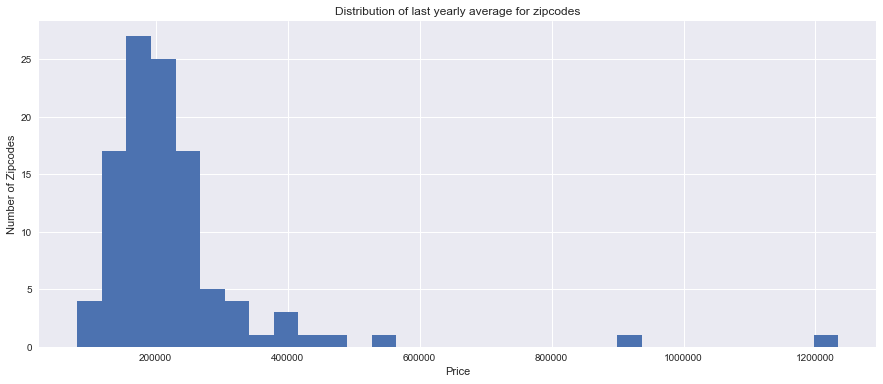

In [29]:
# Plotting a histogram for the price distribution of zipcodes
plt.figure(figsize=(15,6))
plt.hist(Idaho['Last12MonthAvg'], bins='auto');
plt.ylabel('Number of Zipcodes');
plt.xlabel('Price');
plt.title('Distribution of last yearly average for zipcodes');

## Calculate ROI (1yr, 5yr, 10yr) and CV

In [30]:
#Calculate ROI for 1 year, 5 year, 10 year
Idaho['1yr_ROI'] = (Idaho['2018-04'] / Idaho['2017-04']) - 1
Idaho['5yr_ROI'] = (Idaho['2018-04'] / Idaho['2013-04']) - 1
Idaho['10yr_ROI'] = (Idaho['2018-04'] / Idaho['2008-04']) - 1

In [31]:
#Calculate CV
Idaho['std'] = Idaho.loc[:,'2006-01':'2018-04'].std(axis=1)
Idaho['mean'] = Idaho.loc[:,'2006-01':'2018-04'].mean(axis=1)
Idaho['CV'] = Idaho['std'] / Idaho['mean']

In [32]:
Idaho.head()

RegionName        City State   2006-01   2006-02   2006-03   2006-04   2006-05   2006-06   2006-07   2006-08   2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09   2010-10   2010-11   2010-12   2011-01   2011-02   2011-03   2011-04   2011-05   2011-06   2011-07   2011-08   2011-09   2011-10   2011-11   2011-12   2012-01   2012-02   2012-03   2012-04   2012-05   2012-06   2012-07   2012-08   2012-09   2012-10   2012-11   2012-12   2013-01   2013-02   2013-03   2013-04   2013-05   2013-06   2013-07   2013-08   2013-09   2013-10   2013-11   2013-12  \
448        83301  Twin Falls    ID  132400.0  133100.0  134100.0  135300.0  136500.0  137800.0  139200.0  140600.0  142100.0  143700.0  145300.0  146700.0  147900.0  148700.0  149400.0  150000.0  150300.0  150400.0  150500.0  150500.0  150400.0  150300.0  150400.0  150400.0  150200.0  149800.0  149400.0  148900.0  148000.0  146800.0  145700.0  144700.0  143800.0  143000.0  142300.0  141700.0  141200.0  140600.0  140300.0  140000.0  139400.0  138300.0  137200.0  135800.0  134500.0  133500.0  132600.0  132100.0  131900.0  132100.0  131500.0  130000.0  128900.0  128600.0  128000.0  126800.0  125400.0  124100.0  122700.0  121000.0  119400.0  118000.0  116800.0  116100.0  116100.0  116400.0  116600.0  116700.0  116900.0  117000.0  116800.0  116900.0  117200.0  117300.0  117300.0  117600.0  118200.0  118900.0  119100.0  119300.0  119700.0  120200.0  120700.0  121300.0  122200.0  123200.0  124200.0  125100.0  126100.0  126700.0  128600.0  132900.0  137400.0  140400.0  142500.0  143700.0   
596        83709       Boise    ID  199200.0  203300.0  207200.0  211500.0  215900.0  220000.0  223300.0  225300.0  225800.0  225000.0  223700.0  222500.0  221700.0  220600.0  219500.0  218800.0  218400.0  217900.0  217600.0  217500.0  217400.0  217400.0  217300.0  217300.0  217600.0  217600.0  217100.0  216500.0  215600.0  213800.0  211500.0  208800.0  206200.0  203700.0  201300.0  199100.0  197400.0  195500.0  193300.0  191000.0  188700.0  186100.0  183900.0  182200.0  180700.0  179300.0  178100.0  176800.0  173900.0  173200.0  173800.0  172700.0  170600.0  170200.0  169200.0  167700.0  165900.0  164300.0  163200.0  162300.0  161700.0  159800.0  157300.0  155400.0  153500.0  151300.0  150100.0  149300.0  148600.0  148500.0  148200.0  147000.0  146100.0  146400.0  147000.0  147800.0  148900.0  149700.0  150100.0  150600.0  151600.0  152900.0  154300.0  156100.0  158200.0  159400.0  160200.0  161900.0  164700.0  168200.0  171800.0  174700.0  176900.0  178400.0  180400.0  183100.0   
1178       83686       Nampa    ID  147100.0  148000.0  149400.0  151500.0  153800.0  156300.0  158900.0  161400.0  164100.0  166500.0  168800.0  170900.0  172600.0  173800.0  174900.0  176200.0  177600.0  178500.0  178900.0  179200.0  179800.0  180600.0  181400.0  182300.0  183000.0  182900.0  182400.0  181800.0  181000.0  179500.0  177200.0  174500.0  172300.0  170200.0  168200.0  166300.0  164500.0  162300.0  160000.0  157900.0  155600.0  153200.0  151300.0  150100.0  149900.0  149700.0  149200.0  148800.0  148900.0  149200.0  147100.0  142100.0  137200.0  134300.0  132100.0  130000.0  127600.0  125800.0  123300.0  119500.0  116800.0  116100.0  116300.0  116900.0  117300.0  118100.0  119600.0  119600.0  117300.0  114500.0  113400.0  114000.0  113700.0  112100.0  111500.0  112500.0  114000.0  114900.0  115600.0  117300.0  119400.0  121100.0  122300.0  123300.0  124500.0  126400.0  128600.0  130600.0  132600.0  134000.0  134900.0  135500.0  136800.0  138500.0  139900.0  140800.0   
1343       837

In [33]:
print('Choosing to use 5yr ROI for historic ROI metric.')
print('The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.')
print('Was thinking of using ')

Choosing to use 5yr ROI for historic ROI metric.
The least you should hold a Property or REIT is 5 years to see gains on income/appreciation.
Was thinking of using 


## Narrowing zipcodes down to historic best 25 candidates

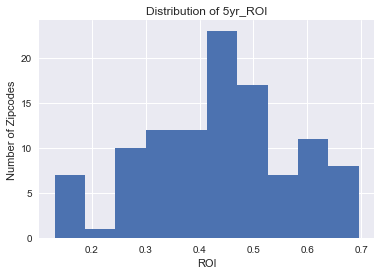

In [34]:
#Looking at distribution of 5yr_ROI
Idaho['5yr_ROI'].hist()
plt.title('Distribution of 5yr_ROI');
plt.ylabel('Number of Zipcodes')
plt.xlabel('ROI');

In [35]:
#Taking the top 25 zipcodes that have the best 5yr_ROI
Idaho_25 = Idaho.sort_values(by=['5yr_ROI'], ascending=False)[0:25]

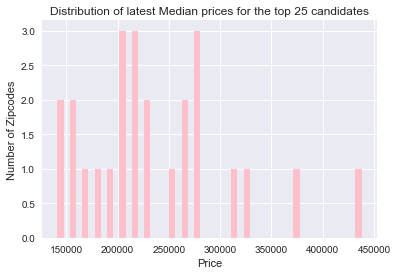

In [36]:
#Looking at the median price distribution of the top 25
Idaho_25['2018-04'].hist(bins=25, color='pink',rwidth=0.5)
plt.title('Distribution of latest Median prices for the top 25 candidates');
plt.xlabel('Price');
plt.ylabel('Number of Zipcodes');

## Turning the top 25 zip codes into long format

In [37]:
#This will take in the data(series) and turn it into a df(long format)
def LongFormat(data):
    
    #Turns series into df
    df = pd.DataFrame(data)
    
    #Drops the unwanted identity entries and calculations
    df = df.drop(labels=['RegionName','City','State','Last12MonthAvg',
                                 '1yr_ROI', '5yr_ROI', '10yr_ROI', 'std', 'mean', 'CV'],axis=0)
    
    #Turns the index into date time
    df.index = pd.to_datetime(df.index)
    df = df.asfreq('MS')
    
    #Labels the prices as value
    df.columns = ['value']
    
    return df

In [38]:
# Pulls each zipcode entry from the dataframe and appends the data to a list
Idaho_25_list = []
for i in range(len(Idaho_25)):
    Idaho_25_list.append(Idaho_25.iloc[i][:])

#Creating a dictionary with the zipcode as the key and the long format dataframe as the value
Idaho_25_dict = {}
for x in Idaho_25_list:
    Idaho_25_dict[str(x[0])] = LongFormat(x)

In [39]:
Idaho_25_dict.keys()

dict_keys(['83703', '83814', '83676', '83605', '83702', '83705', '83651', '83350', '83801', '83845', '83347', '83607', '83336', '83706', '83655', '83835', '83687', '83714', '83709', '83704', '83815', '83686', '83660', '83276', '83858'])

In [40]:
Idaho_25_dict['83703'].head()

value
2006-01-01  182900
2006-02-01  186600
2006-03-01  190000
2006-04-01  193800
2006-05-01  197900

## Looking at the price plots

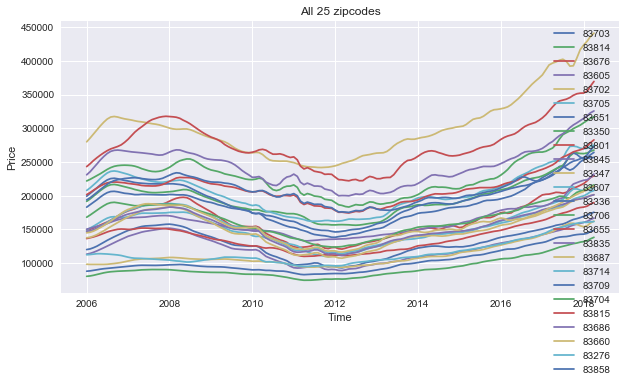

In [41]:
# Plotting all 25 zipcodes

fig, ax = plt.subplots(figsize=(10,5))

for k,v in Idaho_25_dict.items():
        ax.plot(v, label=k)
        ax.set_ylabel('Price')
        ax.set_xlabel('Time')
        ax.legend()
        ax.set_title('All 25 zipcodes')
        

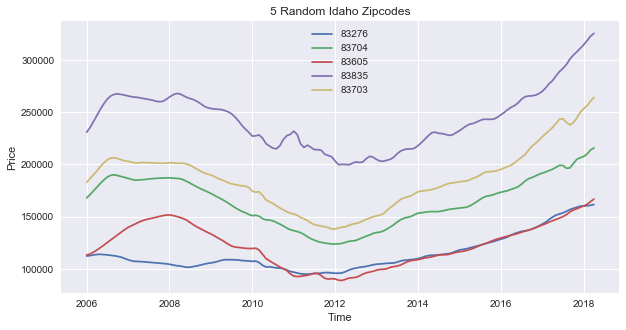

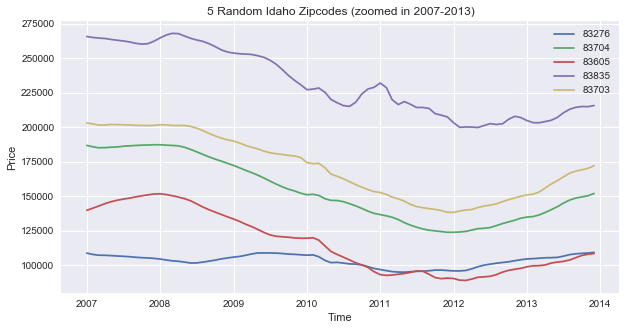

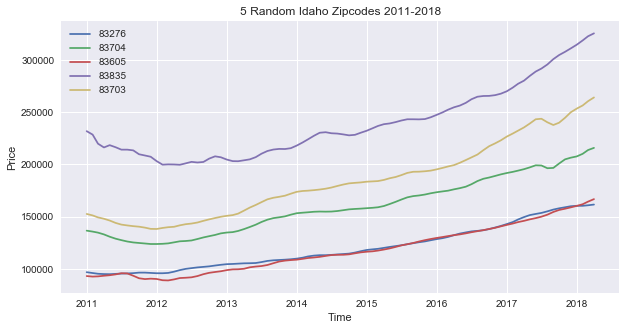

In [42]:
# Plotting 5 random zipcodes from the 25 zipcodes

zipcodes = list(Idaho_25_dict.keys())
random_zips = np.random.choice(range(25), 5, replace=False)


# Looking at whole time stamp
fig, ax = plt.subplots(figsize=(10,5))

for r in random_zips:
    ax.plot(Idaho_25_dict[zipcodes[r]],label=zipcodes[r])
    ax.set_ylabel('Price')
    ax.set_xlabel('Time')
    ax.legend(loc='best')
    ax.set_title('5 Random Idaho Zipcodes')

# Looking between 2007-2013
fig2, ax2 = plt.subplots(figsize=(10,5))
for r in random_zips:
    ax2.plot(Idaho_25_dict[zipcodes[r]]['2007':'2013'],label=zipcodes[r])
    ax2.set_ylabel('Price')
    ax2.set_xlabel('Time')
    ax2.legend(loc='best')
    ax2.set_title('5 Random Idaho Zipcodes (zoomed in 2007-2013)')

    
# Looking from 2011-2018    
fig3, ax3 = plt.subplots(figsize=(10,5))
for r in random_zips:
    ax3.plot(Idaho_25_dict[zipcodes[r]]['2011':],label=zipcodes[r])
    ax3.set_ylabel('Price')
    ax3.set_xlabel('Time')
    ax3.legend(loc='best')
    ax3.set_title('5 Random Idaho Zipcodes 2011-2018')

In [43]:
print('Here we can see that in 2008 there was a crash for the whole market.')
print('We can also see that the housing prices seem to have started to recover in 2012.')
print('Looking at the trends I think it would be best to start analyzing the data from 2011.')
print('This way it will take out the anomaly of the crash.')
print('We dont want to overestimate the prices either so I believe that having the one year of recovery will help the model.')

Here we can see that in 2008 there was a crash for the whole market.
We can also see that the housing prices seem to have started to recover in 2012.
Looking at the trends I think it would be best to start analyzing the data from 2011.
This way it will take out the anomaly of the crash.
We dont want to overestimate the prices either so I believe that having the one year of recovery will help the model.


## Shortening the timeseries to 2011-2018

In [44]:
# Creating a new dataframe that covers from 2011-2018
Idaho_25_short_dict={}

for k,v in Idaho_25_dict.items():
    Idaho_25_short_dict[k] = v['2011':]

In [45]:
Idaho_25_short_dict['83703'].head()

value
2011-01-01  152600
2011-02-01  151200
2011-03-01  149300
2011-04-01  148000
2011-05-01  146300

## Seasonal Decompose

In [46]:
# Checking to see if there is any sort of seasonality to the zipcodes
# Randomly chose '83814' to look at

Text(0, 0.5, 'Price')

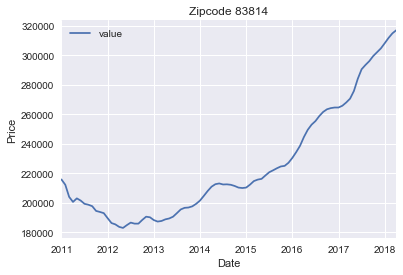

In [47]:
Idaho_25_short_dict['83814'].plot();
plt.title('Zipcode 83814');
plt.xlabel('Date')
plt.ylabel('Price')

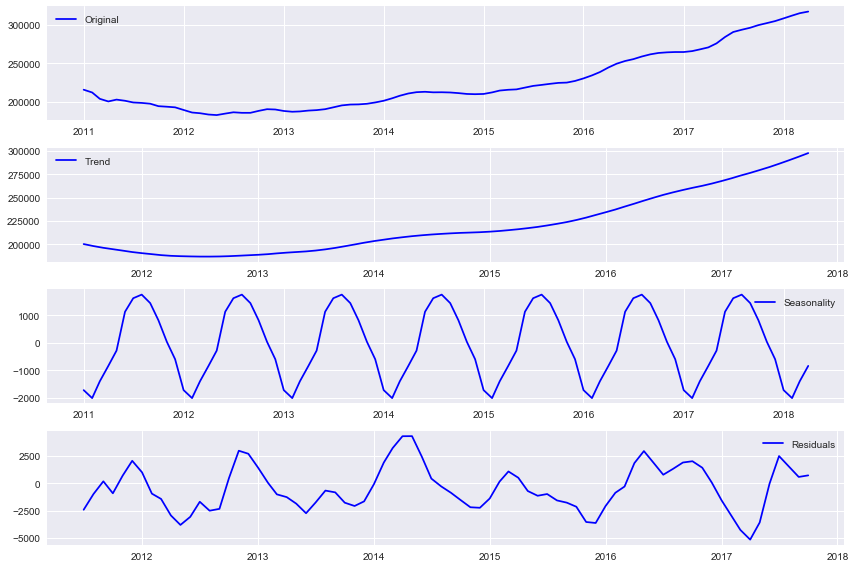

In [48]:
# Taking the decomposition of '83814'
decomposition = seasonal_decompose(Idaho_25_short_dict['83814'])

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the original data
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(Idaho_25_short_dict['83814'], label='Original', color='blue')
plt.legend(loc='best')

# Plotting the Trend of the data
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')

# Plotting the Seasonality of the data
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')

# Plotting the Residuals of the data
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

The time difference between the two minimums is 365 days 00:00:00


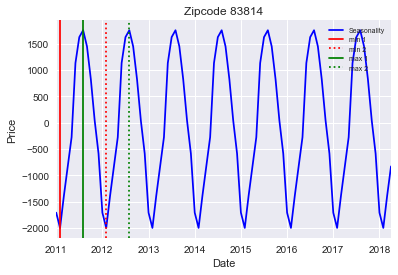

In [49]:
# Looking at the seasonal plot closer

# Plotting the seasonality plot
ax = seasonal.plot(label='Seasonality', color='blue')

# Finding the time stamps of the mins and maxs
min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

# Adding verticle lines for the mins/maxs
ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')

# Graph properties
plt.legend(loc='upper right', fontsize='x-small')
plt.xlabel('Date')
plt.title('Zipcode 83814')
plt.ylabel('Price')

print(f'The time difference between the two minimums is {min_2-min_}')

It looks like the seasonal period is one year, our data is recorded monthly so that means the number of steps in a seasonal period is 12.

## Maps (Uncomment to run)

In [50]:
with urlopen('https://raw.githubusercontent.com/OpenDataDE/State-zip-code-GeoJSON/master/id_idaho_zip_codes_geo.min.json') as response:
    Idaho_Map = json.load(response)

Idaho_Map["features"][0]

{'type': 'Feature',
 'properties': {'STATEFP10': '16',
  'ZCTA5CE10': '83634',
  'GEOID10': '1683634',
  'CLASSFP10': 'B5',
  'MTFCC10': 'G6350',
  'FUNCSTAT10': 'S',
  'ALAND10': 387964176,
  'AWATER10': 1575894,
  'INTPTLAT10': '+43.4557812',
  'INTPTLON10': '-116.3284527',
  'PARTFLG10': 'N'},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-116.493818, 43.437039],
    [-116.513454, 43.437057],
    [-116.513451, 43.437153],
    [-116.51345, 43.437209],
    [-116.513437, 43.437752],
    [-116.513499, 43.439844],
    [-116.513507, 43.440787],
    [-116.513487, 43.441847],
    [-116.513496, 43.442783],
    [-116.5135, 43.443172],
    [-116.513492, 43.44453],
    [-116.513434, 43.444561],
    [-116.513426, 43.444571],
    [-116.513415, 43.444584],
    [-116.513407, 43.444843],
    [-116.513398, 43.44512],
    [-116.513406, 43.447367],
    [-116.51339, 43.44746],
    [-116.513393, 43.447498],
    [-116.513397, 43.447549],
    [-116.513403, 43.447612],
    [-116.513415, 43.447742],
 

### Using plotly express

In [51]:
# Don't run this will make the map but it will be too large of a size, deal with this later.
# Figure for all 110 zipcodes

#fig = px.choropleth(Idaho, geojson=Idaho_Map, color="5yr_ROI",
#                    locations="RegionName", featureidkey="properties.ZCTA5CE10",
#                    projection="mercator", hover_data=['City']
#                   )
#fig.update_geos(fitbounds="locations", visible=True)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

In [52]:
# Don't run this will make the map but it will be too large of a size, deal with this later.
# Figure for top 25 zipcodes

#fig = px.choropleth(Idaho_25, geojson=Idaho_Map, color="5yr_ROI",
#                    locations="RegionName", featureidkey="properties.ZCTA5CE10",
#                    projection="mercator", hover_data=['City']
#                   )
#fig.update_geos(fitbounds="locations", visible=True)
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig.show()

### Using ipyLeaflet

In [65]:
# Making a copy of the geojson file
Idaho_Map_copy = Idaho_Map.copy()

# Going through the geojson file and taking the zip code id out of the properties and putting
# it under feature
for feature in Idaho_Map_copy['features']:
    properties = feature['properties']
    feature.update(id=properties['ZCTA5CE10'])

# Making a dictionary for the zipcodes we have information on to use in choropleth
leaflet_Idaho = dict(zip(Idaho['RegionName'].tolist(), Idaho['5yr_ROI'].tolist()))
leaflet_Idaho = {str(key): value for key, value in leaflet_Idaho.items()}

# list to store zipcodes in geojson file
Zip_list_geo = [feature['id'] for feature in Idaho_Map_copy['features']]


# for feature in Idaho_Map_test['features']:
#     Zip_list_geo.append(feature['id'])

# Adding 0's for zipcodes we don't have info on, there needs to be a value so that the map
# doesn't throw an error
for zipcode in Zip_list_geo:
    if zipcode not in leaflet_Idaho:
        leaflet_Idaho[str(zipcode)] = float(0)


# Actual coding for the map
Idaho_layer = Choropleth(
    geo_data=Idaho_Map_copy,
    choro_data=leaflet_Idaho,
    key_on = 'id',
    value_min = 0,
    #value_max = find out
    )

# Need to resize map to fit all of Idaho
# Need to add legend
# Need to add hover data
Idaho_choro = Map(basemap=basemaps.OpenStreetMap.BlackAndWhite, center = [44,-114], zoom = 5.5)
Idaho_choro.add_layer(Idaho_layer)
Idaho_choro

Map(center=[44, -114], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

# Modeling

## Creating initial model for one zipcode (83814) before running through all 25

### Finding out what parameters to use by auto_arima

Using pmd arima to gather the parameters that are best for modeling

In [189]:
print('The data covers {} months.'.format(len(Idaho_25_short_dict['83814'])))

The data covers 88 months.


In [190]:
# Train size is 6 years and 10 months (82 months), test size is 6 months
train, test = train_test_split(Idaho_25_short_dict['83814'], train_size=82)

In [191]:
# Checking train time stamps
print(train.index[0])
print(train.index[-1])

2011-01-01 00:00:00
2017-10-01 00:00:00


In [192]:
# Running auto_arima
auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12,
                           max_order=None,trace=True)

# Plotting auto_arima summary
display(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1417.804, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1412.730, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1420.769, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1411.937, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1412.706, Time=0.13 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1413.131, Time=0.50 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1404.727, Time=0.05 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1405.170, Time=0.11 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1405.131, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=1404.145, Time=0.38 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=1406.143, Time=1.24 sec
 ARIMA(2,2,0)(1,0,2)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(2,2,0)(0,0,2)[12]             : AIC=1405.579, Time=0.27 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=1405.648, Time=0.34 sec
 ARIMA(2,2,0)(2,0,2)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -682.049
Date:                              Tue, 27 Apr 2021   AIC                           1378.097
Time:                                      15:56:22   BIC                           1394.771
Sample:                                           0   HQIC                          1384.782
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0098      0.058      0.170      0.865      -0.103       0.123
ar.L2         -0.0689      0.037     -1.840      0.066      -0.142       0.004
ar.L3         -0.0351      0.059     -0.593      0.553      -0.151       0.081
ar.L4          0.0401      0.062      0.647      0.518      -0.081       0.162
ar.S.L12       0.8483      0.320      2.648      0.008       0.220       1.476
ma.S.L12      -0.8620      0.316     -2.724      0.006      -1.482      -0.242
sigma2      1.225e+06   1.35e-07    9.1e+12      0.000    1.22e+06    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.13   Prob(JB):                         0.81
Heteroskedasticity (H):               0.97   Skew:                             0.17
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.32e+29. Standard errors may be unstable.
"""

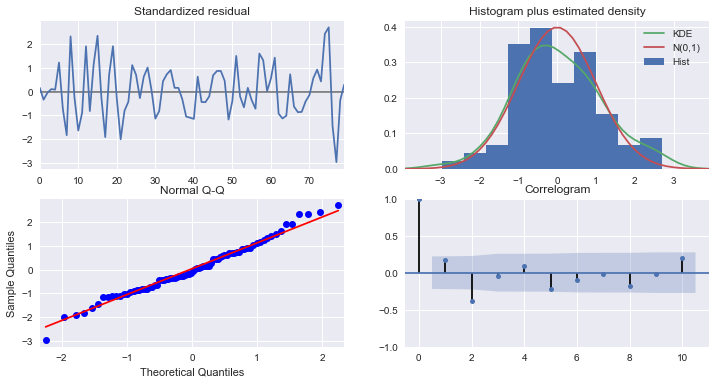

In [193]:
# Plotting auto_arima diagnostics
auto_model.plot_diagnostics(figsize=(12,6));

In [194]:
# Getting auto_arima parameters
auto_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (4, 2, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

### Using best params to make an initial model

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -531.216
Date:                              Tue, 27 Apr 2021   AIC                           1076.431
Time:                                      15:56:23   BIC                           1091.543
Sample:                                  01-01-2011   HQIC                          1082.384
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5411      0.131      4.140      0.000       0.285       0.797
ar.L2         -0.7451      0.145     -5.156      0.000      -1.028      -0.462
ar.L3          0.3181      0.161      1.979      0.048       0.003       0.633
ar.L4         -0.1545      0.140     -1.107      0.268      -0.428       0.119
ar.S.L12       0.0737      0.295      0.250      0.803      -0.505       0.652
ma.S.L12       0.0695      0.304      0.228      0.819      -0.527       0.666
sigma2      9.496e+05   1.98e+05      4.801      0.000    5.62e+05    1.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.77   Prob(JB):                         0.40
Heteroskedasticity (H):               3.07   Skew:                             0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

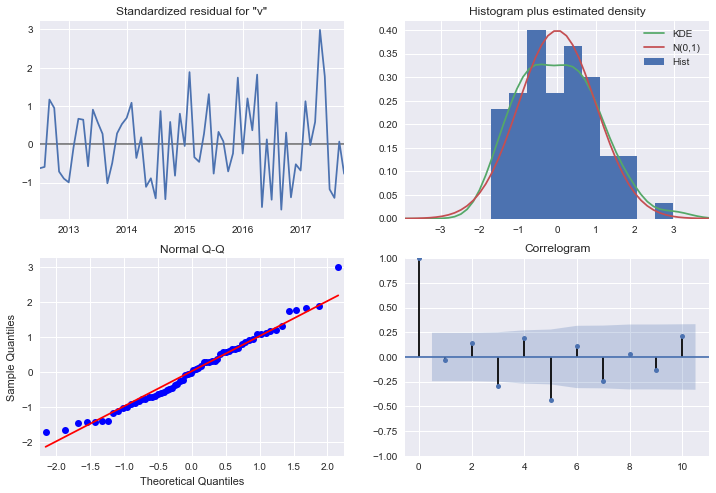

In [195]:
# Using the best params to train the model
Test_model = SARIMAX(train['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
output = Test_model.fit()

# Displays model summary and model diagnostics
display(output.summary());
output.plot_diagnostics(figsize=(12,8));

In [196]:
# Taking the initial model and checking the predictions it makes with the trained data.
# Non dynamic
predictions = output.get_prediction(start='2016-10-01',end='2017-10-01',dynamic=False)
predictions_conf = predictions.conf_int()

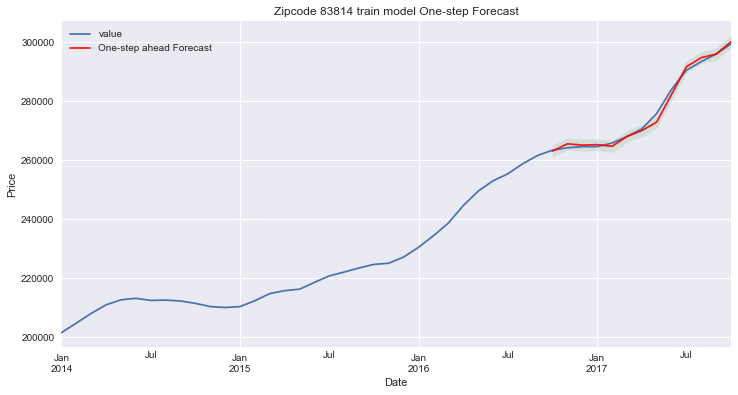

In [197]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = train['2014':].plot()

# Plot predicted values
predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predictions_conf.index,
                predictions_conf.iloc[:, 0],
                predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.title('Zipcode 83814 train model One-step Forecast')
plt.show()


In [198]:
# Getting predicted prices and real prices
y_hat = predictions.predicted_mean
real_values = train['2016-10-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1489714.92


In [199]:
# Taking the initial model and checking the predictions it makes with the trained data.
# dynamic
predictions_dyn = output.get_prediction(start='2016-10-01',end='2017-10-01',
                                    dynamic=True, full_results=True)
predictions_dyn_conf = predictions_dyn.conf_int()

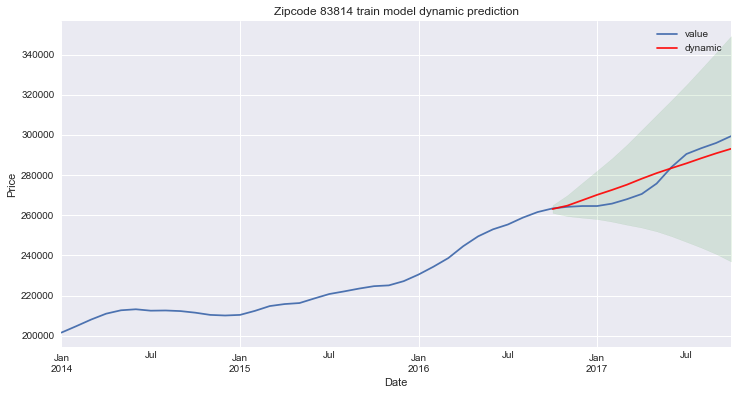

In [200]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = train['2014':].plot()

# Plot predicted values
predictions_dyn.predicted_mean.plot(ax=ax, label='dynamic', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(predictions_dyn_conf.index,
                predictions_dyn_conf.iloc[:, 0],
                predictions_dyn_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.title('Zipcode 83814 train model dynamic prediction')
plt.show()

In [201]:
# Getting the dynamic pediction and the actual values
y_hat = predictions_dyn.predicted_mean
real_values = train['2016-10-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 25859273.6


The dynamic forecasting does much worse than the one-step forecasting. Dynamic is more true to how the actual model will perform.

In [202]:
# Looking at the forecast for the "test" data. To see if it is able to forecast well.
forecast = output.get_forecast(steps = 6)
forecast_conf = forecast.conf_int()

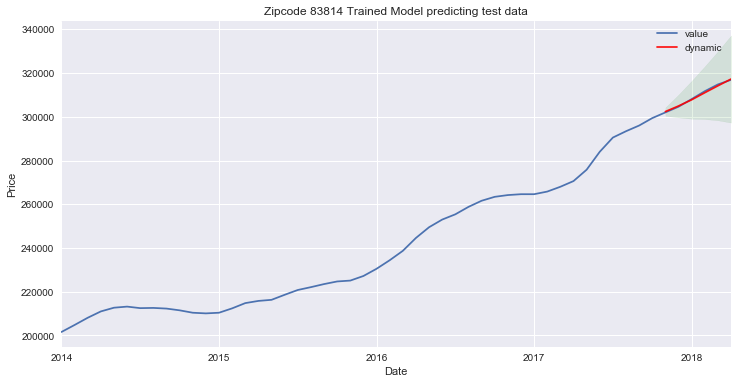

In [203]:
# Plot real vs predicted values along with confidence interval

# Plot observed values
ax = Idaho_25_short_dict['83814']['2014':].plot()

# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='dynamic', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.title('Zipcode 83814 Trained Model predicting test data')
plt.show()

In [204]:
y_hat = forecast.predicted_mean
real_values = Idaho_25_short_dict['83814']['2017-10-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 223454.17


### Making the final model to predict future prices

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -578.799
Date:                              Tue, 27 Apr 2021   AIC                           1171.597
Time:                                      15:56:28   BIC                           1187.337
Sample:                                  01-01-2011   HQIC                          1177.849
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5474      0.122      4.503      0.000       0.309       0.786
ar.L2         -0.7606      0.134     -5.676      0.000      -1.023      -0.498
ar.L3          0.3367      0.143      2.355      0.019       0.057       0.617
ar.L4         -0.1840      0.127     -1.452      0.147      -0.432       0.064
ar.S.L12       0.0807      0.266      0.304      0.761      -0.440       0.602
ma.S.L12       0.0748      0.275      0.272      0.786      -0.464       0.614
sigma2      8.919e+05   1.71e+05      5.223      0.000    5.57e+05    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.70   Prob(JB):                         0.36
Heteroskedasticity (H):               2.28   Skew:                             0.42
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

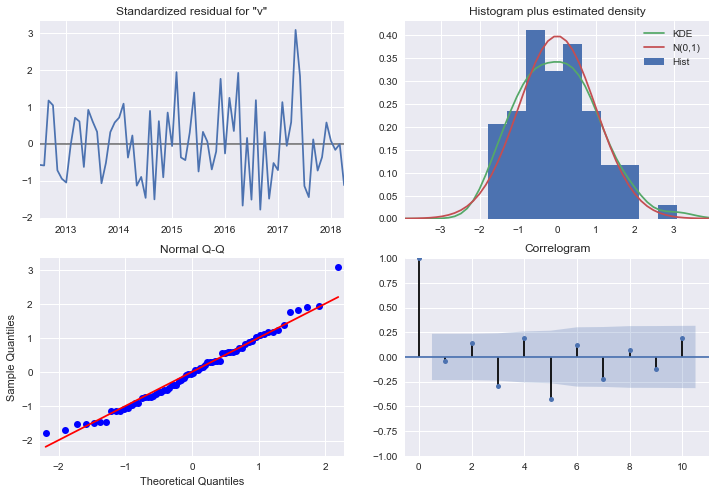

In [205]:
# Making a model for the data we have (train + test) and seeing future predictions
Final_model = SARIMAX(Idaho_25_short_dict['83814']['value'].astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
Final_output = Final_model.fit()

# Displaying the model summary and diagnostics
display(Final_output.summary());
Final_output.plot_diagnostics(figsize=(12,8));

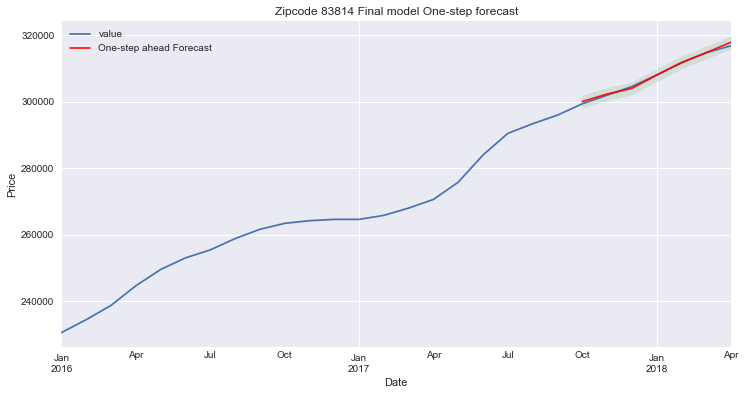

In [206]:
# Checking one step prediction on the last year of data
Final_predictions = Final_output.get_prediction(start='2017-10-01',end='2018-04-01',dynamic=False)
Final_predictions_conf = Final_predictions.conf_int()

# Plot observed values
ax = Idaho_25_short_dict['83814']['value']['2016':].plot()

# Plot predicted values
Final_predictions.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(Final_predictions_conf.index,
                Final_predictions_conf.iloc[:, 0],
                Final_predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.title('Zipcode 83814 Final model One-step forecast')
plt.show()

In [207]:
# Getting the predictions and actual values
y_hat = Final_predictions.predicted_mean
real_values = Idaho_25_short_dict['83814']['2017-10-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 291583.13


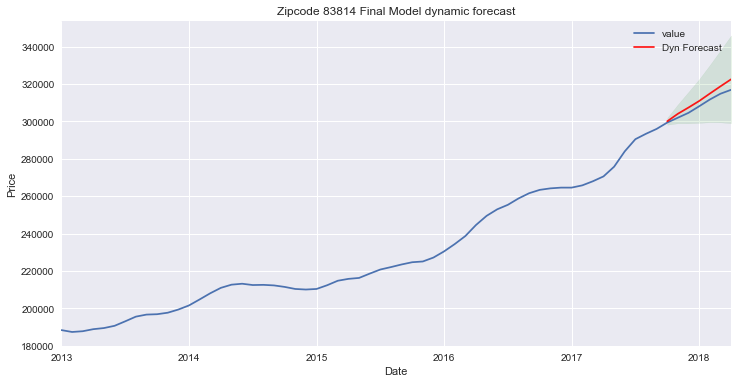

In [208]:
# Checking one step prediction on the last year of data
Final_dyn_predictions = Final_output.get_prediction(start='2017-10-01',end='2018-04-01',dynamic=True)
Final_dyn_predictions_conf = Final_dyn_predictions.conf_int()

# Plot observed values
ax = Idaho_25_short_dict['83814']['value']['2013':].plot()

# Plot predicted values
Final_dyn_predictions.predicted_mean.plot(ax=ax, label='Dyn Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(Final_dyn_predictions_conf.index,
                Final_dyn_predictions_conf.iloc[:, 0],
                Final_dyn_predictions_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.title('Zipcode 83814 Final Model dynamic forecast')
plt.legend()
plt.show()

In [209]:
# Getting predicted values and real values
y_hat = Final_dyn_predictions.predicted_mean
real_values = Idaho_25_short_dict['83814']['2017-10-01':]['value']

# Compute the mean square error
mse = ((real_values-y_hat)**2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 11164021.6


In [210]:
# Getting the next year's price predictions and the confidence interval
future_year = Final_output.get_forecast(steps=12)
future_year_conf = future_year.conf_int()

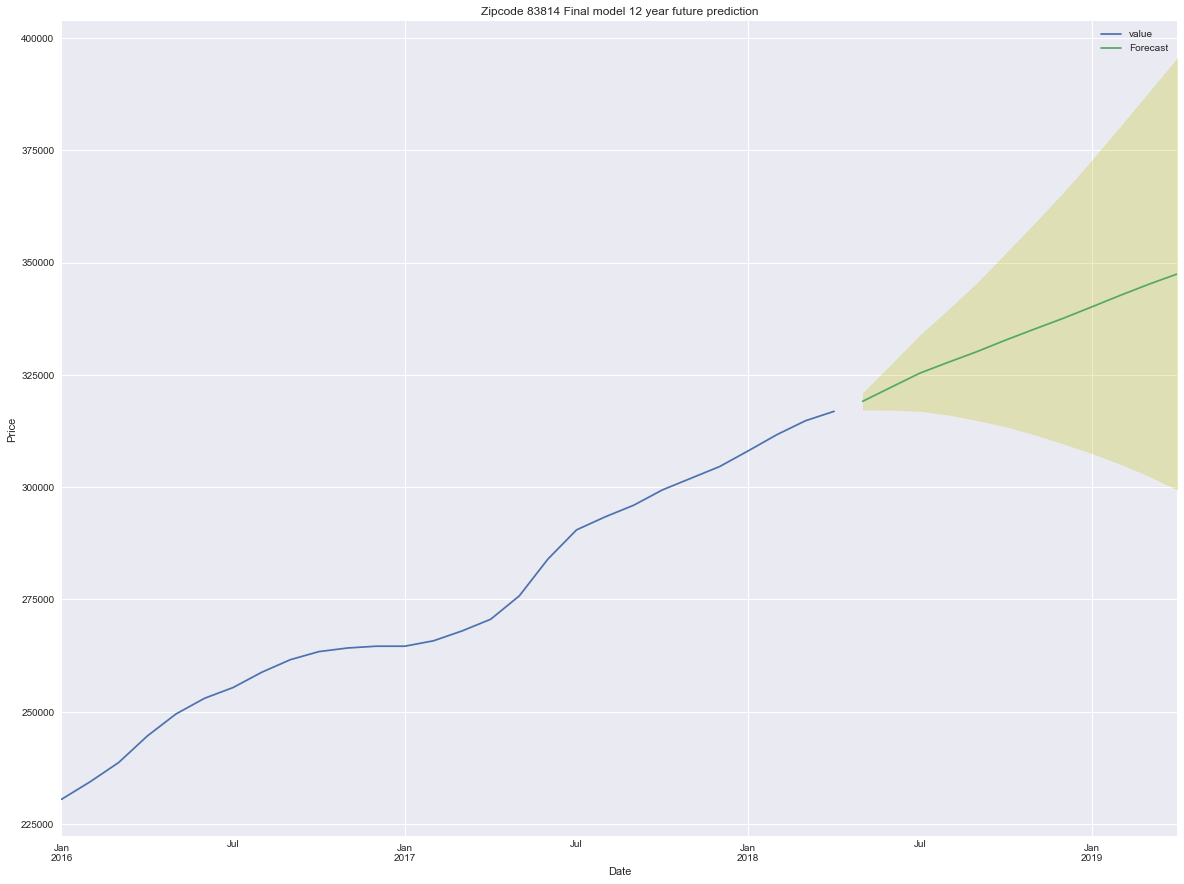

In [211]:
# Plotting the next predicted years prices
ax=Idaho_25_short_dict['83814']['2016':].plot(label='Observed', figsize=(20,15))

future_year.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(future_year_conf.index,
                future_year_conf.iloc[:,0],
                future_year_conf.iloc[:,1],
                color='y',
                alpha=0.25)

ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.title('Zipcode 83814 Final model 12 year future prediction')
plt.legend()
plt.show()

In [212]:
# Looking at the 1 year predicted forecast
future_year.predicted_mean[-1]

347509.2204903276

## Going through all 25 zipcodes and modeling

Modeling for zipcode 83703
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1331.296, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1334.422, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1334.685, Time=0.15 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1332.986, Time=0.12 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1332.985, Time=0.23 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1332.777, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1333.081, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1334.489, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1333.128, Time=0.02 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.304 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -664.648
Date:                Tue, 27 Apr 2021   AIC                           1331.296
Time:                        15:56:33   BIC                           1333.678
Sample:                             0   HQIC                          1332.251
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.631e+05   6.25e+04     15.413      0.000    8.41e+05    1.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.99   Jarque-Bera (JB):               326.99
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               6.10   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -656.709
Date:                Tue, 27 Apr 2021   AIC                           1315.417
Time:                        15:56:33   BIC                           1317.787
Sample:                    01-01-2011   HQIC                          1316.367
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.716e+05   6.36e+04     15.274      0.000    8.47e+05     1.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.13   Jarque-Bera (JB):               318.81
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               6.25   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -709.431
Date:                Tue, 27 Apr 2021   AIC                           1420.862
Time:                        15:56:33   BIC                           1423.305
Sample:                    01-01-2011   HQIC                          1421.845
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.039e+06   7.14e+04     14.556      0.000    8.99e+05    1.18e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.55   Jarque-Bera (JB):               226.74
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.08   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

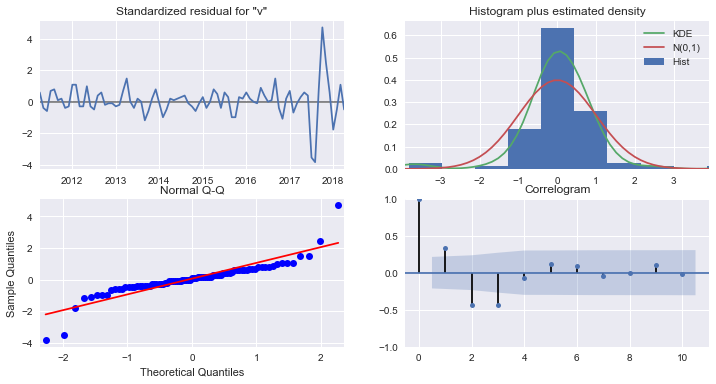

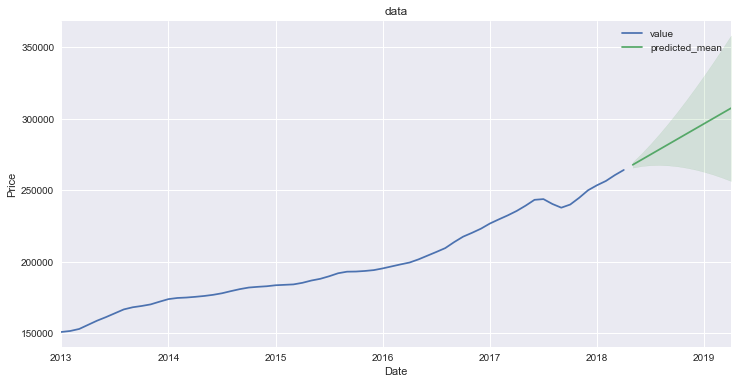

Modeling for zipcode 83814
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1417.804, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1412.730, Time=0.40 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1420.769, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1411.937, Time=0.04 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1412.706, Time=0.19 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1413.131, Time=0.41 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1404.727, Time=0.04 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1405.170, Time=0.13 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1405.131, Time=0.14 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=1404.145, Time=0.43 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=1406.143, Time=1.25 sec
 ARIMA(2,2,0)(1,0,2)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(2,2,0)(0,0,2)[12]             : AIC=1405.579, Time=0.23 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=1405.648, Time=0.20 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -682.049
Date:                              Tue, 27 Apr 2021   AIC                           1378.097
Time:                                      15:57:03   BIC                           1394.771
Sample:                                           0   HQIC                          1384.782
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0098      0.058      0.170      0.865      -0.103       0.123
ar.L2         -0.0689      0.037     -1.840      0.066      -0.142       0.004
ar.L3         -0.0351      0.059     -0.593      0.553      -0.151       0.081
ar.L4          0.0401      0.062      0.647      0.518      -0.081       0.162
ar.S.L12       0.8483      0.320      2.648      0.008       0.220       1.476
ma.S.L12      -0.8620      0.316     -2.724      0.006      -1.482      -0.242
sigma2      1.225e+06   1.35e-07    9.1e+12      0.000    1.22e+06    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.35   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.13   Prob(JB):                         0.81
Heteroskedasticity (H):               0.97   Skew:                             0.17
Prob(H) (two-sided):                  0.95   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.32e+29. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -531.216
Date:                              Tue, 27 Apr 2021   AIC                           1076.431
Time:                                      15:57:04   BIC                           1091.543
Sample:                                  01-01-2011   HQIC                          1082.384
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5411      0.131      4.140      0.000       0.285       0.797
ar.L2         -0.7451      0.145     -5.156      0.000      -1.028      -0.462
ar.L3          0.3181      0.161      1.979      0.048       0.003       0.633
ar.L4         -0.1545      0.140     -1.107      0.268      -0.428       0.119
ar.S.L12       0.0737      0.295      0.250      0.803      -0.505       0.652
ma.S.L12       0.0695      0.304      0.228      0.819      -0.527       0.666
sigma2      9.496e+05   1.98e+05      4.801      0.000    5.62e+05    1.34e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.77   Prob(JB):                         0.40
Heteroskedasticity (H):               3.07   Skew:                             0.40
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -578.799
Date:                              Tue, 27 Apr 2021   AIC                           1171.597
Time:                                      15:57:04   BIC                           1187.337
Sample:                                  01-01-2011   HQIC                          1177.849
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5474      0.122      4.503      0.000       0.309       0.786
ar.L2         -0.7606      0.134     -5.676      0.000      -1.023      -0.498
ar.L3          0.3367      0.143      2.355      0.019       0.057       0.617
ar.L4         -0.1840      0.127     -1.452      0.147      -0.432       0.064
ar.S.L12       0.0807      0.266      0.304      0.761      -0.440       0.602
ma.S.L12       0.0748      0.275      0.272      0.786      -0.464       0.614
sigma2      8.919e+05   1.71e+05      5.223      0.000    5.57e+05    1.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 2.06
Prob(Q):                              0.70   Prob(JB):                         0.36
Heteroskedasticity (H):               2.28   Skew:                             0.42
Prob(H) (two-sided):                  0.05   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

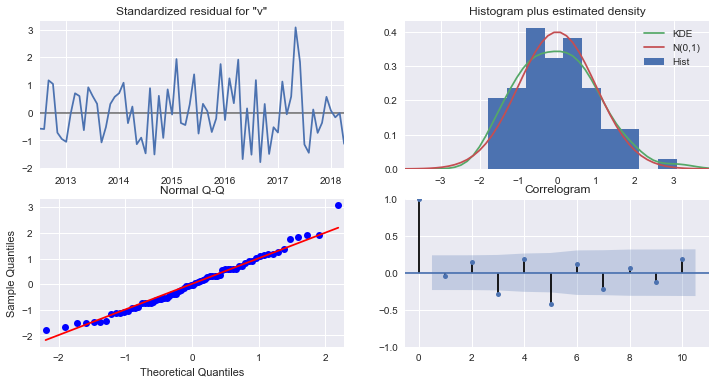

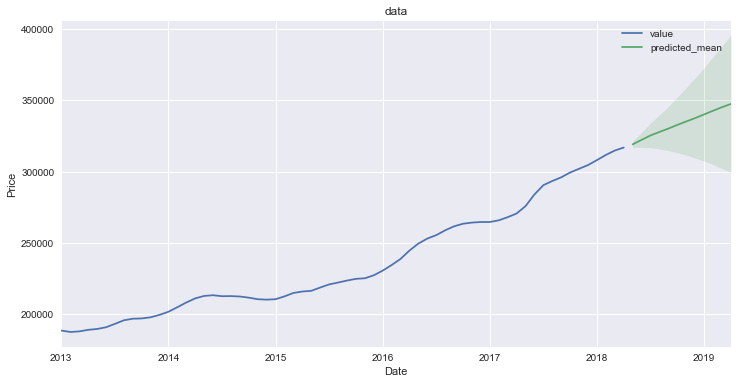

Modeling for zipcode 83676
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1370.153, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1373.442, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1373.598, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1371.328, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1373.529, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1375.161, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1372.342, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1372.541, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1372.049, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.438 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -684.076
Date:                Tue, 27 Apr 2021   AIC                           1370.153
Time:                        15:57:05   BIC                           1372.535
Sample:                             0   HQIC                          1371.108
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.565e+06   2.52e+05      6.221      0.000    1.07e+06    2.06e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                 0.02
Prob(Q):                              0.01   Prob(JB):                         0.99
Heteroskedasticity (H):               1.51   Skew:                            -0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -675.909
Date:                Tue, 27 Apr 2021   AIC                           1353.817
Time:                        15:57:05   BIC                           1356.187
Sample:                    01-01-2011   HQIC                          1354.767
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.58e+06   2.57e+05      6.153      0.000    1.08e+06    2.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.98   Jarque-Bera (JB):                 0.03
Prob(Q):                              0.01   Prob(JB):                         0.99
Heteroskedasticity (H):               1.39   Skew:                            -0.01
Prob(H) (two-sided):                  0.41   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -727.547
Date:                Tue, 27 Apr 2021   AIC                           1457.094
Time:                        15:57:06   BIC                           1459.536
Sample:                    01-01-2011   HQIC                          1458.076
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.591e+06   2.52e+05      6.307      0.000     1.1e+06    2.09e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.56   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.02   Prob(JB):                         0.95
Heteroskedasticity (H):               1.51   Skew:                            -0.05
Prob(H) (two-sided):                  0.28   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

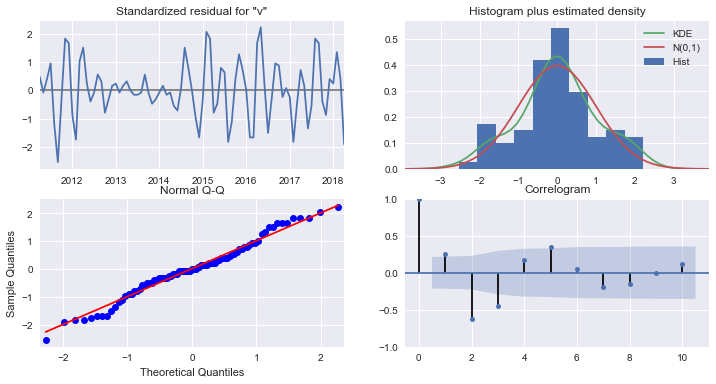

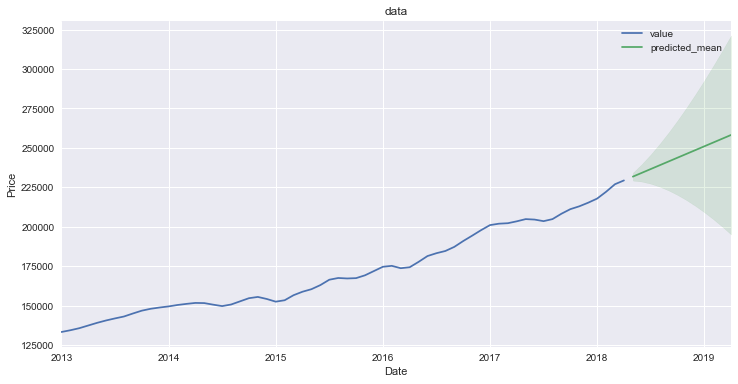

Modeling for zipcode 83605
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1238.286, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1240.534, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1240.508, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1238.877, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1238.894, Time=0.11 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1240.863, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1239.949, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1239.899, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1239.576, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1240.046, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.831 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -618.143
Date:                Tue, 27 Apr 2021   AIC                           1238.286
Time:                        15:57:09   BIC                           1240.668
Sample:                             0   HQIC                          1239.241
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.011e+05   3.38e+04      8.900      0.000    2.35e+05    3.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.24   Jarque-Bera (JB):                15.28
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -610.102
Date:                Tue, 27 Apr 2021   AIC                           1222.203
Time:                        15:57:09   BIC                           1224.573
Sample:                    01-01-2011   HQIC                          1223.152
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.988e+05   3.33e+04      8.963      0.000    2.33e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.96   Jarque-Bera (JB):                16.07
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -655.725
Date:                Tue, 27 Apr 2021   AIC                           1313.449
Time:                        15:57:09   BIC                           1315.892
Sample:                    01-01-2011   HQIC                          1314.432
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.938e+05   3.19e+04      9.211      0.000    2.31e+05    3.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.62   Jarque-Bera (JB):                16.24
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

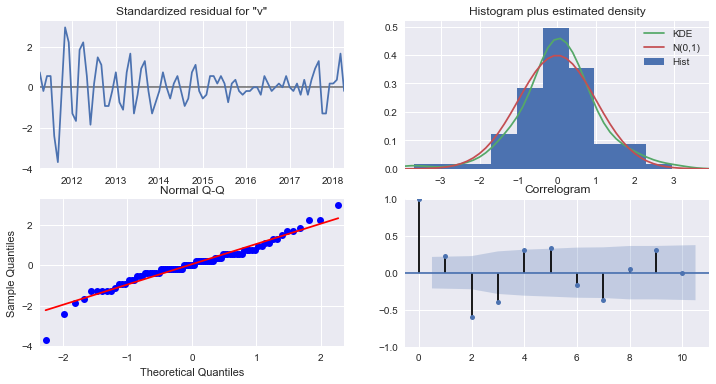

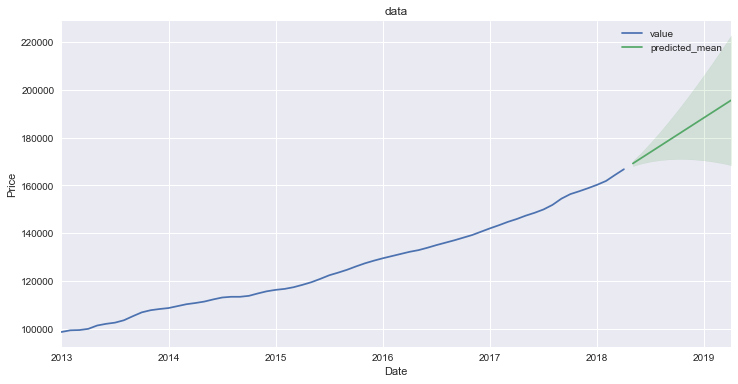

Modeling for zipcode 83702
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1395.782, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1399.600, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1399.691, Time=0.27 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1398.410, Time=0.09 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1405.341, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1406.622, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1397.646, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1397.741, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1399.532, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1397.752, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.729 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -696.891
Date:                Tue, 27 Apr 2021   AIC                           1395.782
Time:                        15:57:11   BIC                           1398.164
Sample:                             0   HQIC                          1396.737
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.156e+06   1.51e+05     14.305      0.000    1.86e+06    2.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):               229.52
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):              10.46   Skew:                             0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -688.640
Date:                Tue, 27 Apr 2021   AIC                           1379.281
Time:                        15:57:11   BIC                           1381.650
Sample:                    01-01-2011   HQIC                          1380.230
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       2.18e+06   1.54e+05     14.143      0.000    1.88e+06    2.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):               219.64
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):              10.34   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -765.451
Date:                Tue, 27 Apr 2021   AIC                           1532.902
Time:                        15:57:11   BIC                           1535.345
Sample:                    01-01-2011   HQIC                          1533.885
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.881e+06   2.22e+05     17.507      0.000    3.45e+06    4.32e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.09   Jarque-Bera (JB):               572.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              18.88   Skew:                             1.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

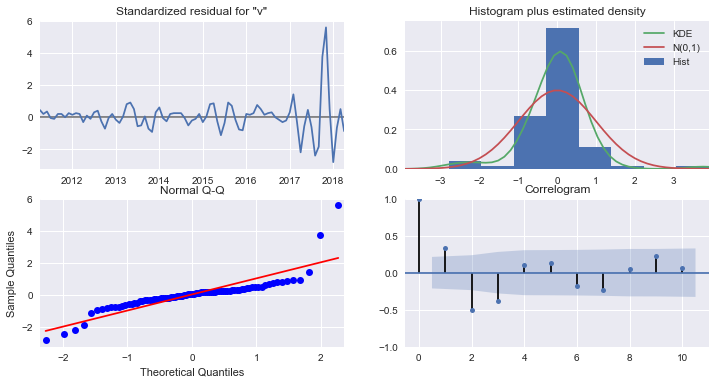

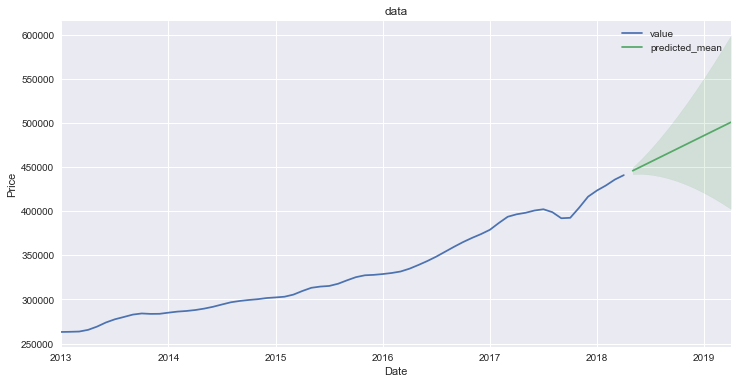

Modeling for zipcode 83705
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1262.282, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1263.923, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1264.232, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1263.299, Time=0.27 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1263.317, Time=0.16 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1264.738, Time=0.50 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1262.914, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1263.216, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1264.524, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1263.277, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 1.200 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -630.141
Date:                Tue, 27 Apr 2021   AIC                           1262.282
Time:                        15:57:13   BIC                           1264.664
Sample:                             0   HQIC                          1263.237
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.064e+05   3.95e+04     10.281      0.000    3.29e+05    4.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                37.77
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -0.01
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -622.321
Date:                Tue, 27 Apr 2021   AIC                           1246.643
Time:                        15:57:13   BIC                           1249.012
Sample:                    01-01-2011   HQIC                          1247.592
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.069e+05   3.96e+04     10.266      0.000    3.29e+05    4.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                39.28
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):               2.05   Skew:                            -0.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         6.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -690.344
Date:                Tue, 27 Apr 2021   AIC                           1382.688
Time:                        15:57:13   BIC                           1385.130
Sample:                    01-01-2011   HQIC                          1383.670
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.633e+05   5.07e+04     13.095      0.000    5.64e+05    7.63e+05
===================================================================================
Ljung-Box (L1) (Q):                  13.39   Jarque-Bera (JB):               170.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.44   Skew:                            -1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

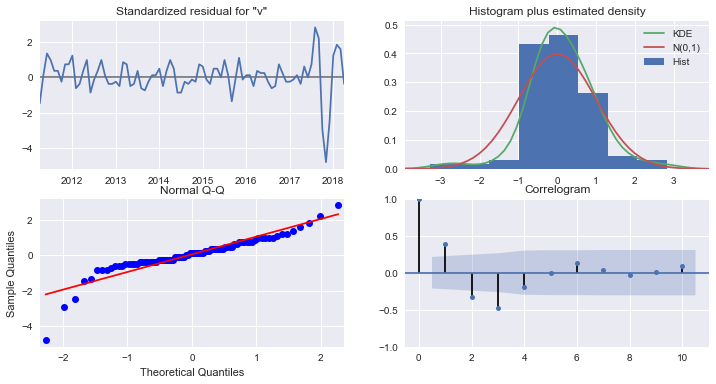

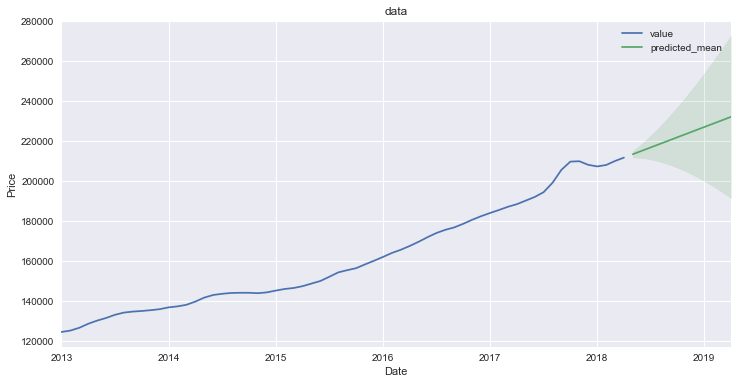

Modeling for zipcode 83651
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1243.646, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1244.214, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1244.069, Time=0.11 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1242.486, Time=0.10 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1244.224, Time=0.14 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1242.392, Time=0.08 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=1244.095, Time=0.26 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1244.120, Time=0.06 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1245.012, Time=0.18 sec
 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=1244.115, Time=0.04 sec

Best model:  ARIMA(0,2,0)(0,0,1)[12]          
Total fit time: 1.486 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -619.196
Date:                              Tue, 27 Apr 2021   AIC                           1242.392
Time:                                      15:57:16   BIC                           1247.156
Sample:                                           0   HQIC                          1244.302
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0503      0.039      1.277      0.202      -0.027       0.128
sigma2      3.068e+05    3.6e+04      8.527      0.000    2.36e+05    3.77e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.73   Jarque-Bera (JB):                 9.18
Prob(Q):                              0.02   Prob(JB):                         0.01
Heteroskedasticity (H):               0.22   Skew:                            -0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -500.250
Date:                              Tue, 27 Apr 2021   AIC                           1004.500
Time:                                      15:57:16   BIC                           1008.909
Sample:                                  01-01-2011   HQIC                          1006.244
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2052      0.167      1.225      0.221      -0.123       0.533
sigma2       1.77e+05   2.82e+04      6.277      0.000    1.22e+05    2.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.16   Jarque-Bera (JB):                 5.18
Prob(Q):                              0.14   Prob(JB):                         0.08
Heteroskedasticity (H):               0.52   Skew:                             0.64
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -545.306
Date:                              Tue, 27 Apr 2021   AIC                           1094.611
Time:                                      15:57:16   BIC                           1099.192
Sample:                                  01-01-2011   HQIC                          1096.437
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2265      0.165      1.374      0.169      -0.097       0.550
sigma2      1.782e+05   2.84e+04      6.271      0.000    1.23e+05    2.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.04   Jarque-Bera (JB):                 3.88
Prob(Q):                              0.15   Prob(JB):                         0.14
Heteroskedasticity (H):               0.63   Skew:                             0.54
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

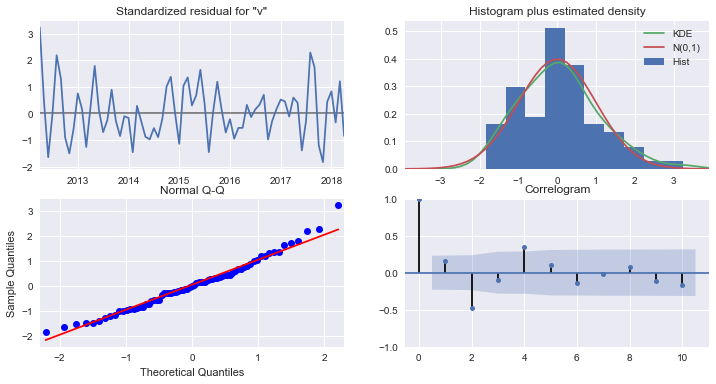

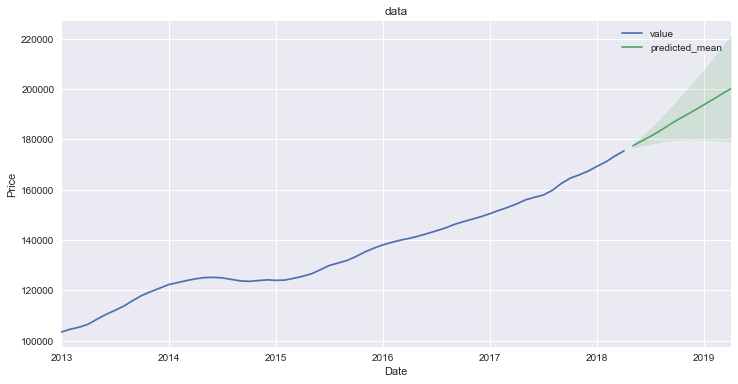

Modeling for zipcode 83350
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1128.109, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1131.839, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1131.787, Time=0.08 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1129.833, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1129.801, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1130.110, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1130.097, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1132.079, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1129.309, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.628 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -563.055
Date:                Tue, 27 Apr 2021   AIC                           1128.109
Time:                        15:57:18   BIC                           1130.491
Sample:                             0   HQIC                          1129.064
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.596e+04   1.25e+04      6.083      0.000    5.15e+04       1e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.55   Jarque-Bera (JB):                 0.16
Prob(Q):                              0.21   Prob(JB):                         0.92
Heteroskedasticity (H):               1.43   Skew:                            -0.09
Prob(H) (two-sided):                  0.36   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -556.253
Date:                Tue, 27 Apr 2021   AIC                           1114.505
Time:                        15:57:18   BIC                           1116.875
Sample:                    01-01-2011   HQIC                          1115.454
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.639e+04   1.26e+04      6.044      0.000    5.16e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.22   Prob(JB):                         0.94
Heteroskedasticity (H):               1.46   Skew:                            -0.07
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -608.897
Date:                Tue, 27 Apr 2021   AIC                           1219.794
Time:                        15:57:18   BIC                           1222.237
Sample:                    01-01-2011   HQIC                          1220.777
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.756e+04   1.15e+04      8.460      0.000     7.5e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 8.22
Prob(Q):                              0.56   Prob(JB):                         0.02
Heteroskedasticity (H):               2.61   Skew:                             0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

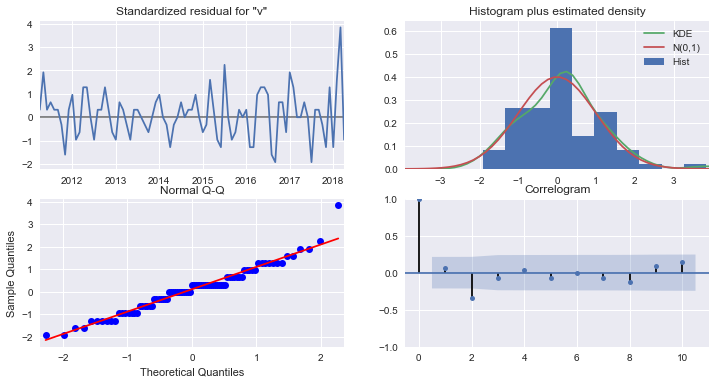

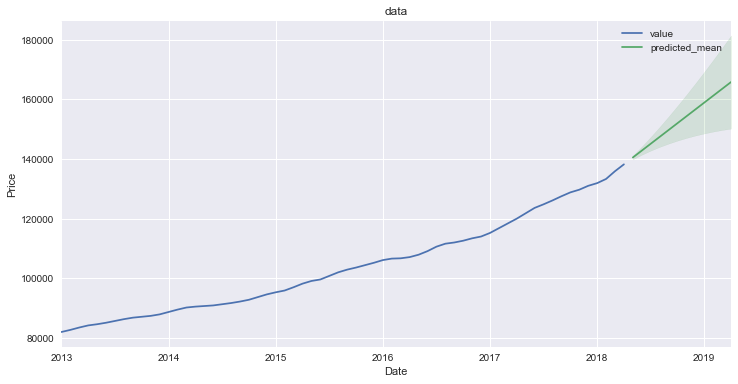

Modeling for zipcode 83801
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1432.943, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1426.855, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1433.428, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1427.142, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1426.656, Time=0.08 sec
 ARIMA(1,2,0)(3,0,0)[12]             : AIC=1428.588, Time=0.19 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=1428.522, Time=0.39 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1427.462, Time=0.17 sec
 ARIMA(1,2,0)(3,0,1)[12]             : AIC=1430.548, Time=0.51 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1432.651, Time=0.28 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=1419.090, Time=0.11 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1421.121, Time=0.13 sec
 ARIMA(2,2,0)(3,0,0)[12]             : AIC=1421.003, Time=0.30 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=1420.846, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -690.409
Date:                            Tue, 27 Apr 2021   AIC                           1394.817
Time:                                    15:57:33   BIC                           1411.491
Sample:                                         0   HQIC                          1401.502
                                             - 82                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0056      0.052      0.108      0.914      -0.096       0.107
ar.L2         -0.0592      0.040     -1.481      0.138      -0.138       0.019
ar.L3         -0.0285      0.048     -0.596      0.551      -0.122       0.065
ar.L4          0.0323      0.061      0.531      0.596      -0.087       0.152
ar.S.L12      -0.0162      0.006     -2.866      0.004      -0.027      -0.005
ar.S.L24      -0.0176      0.026     -0.681      0.496      -0.068       0.033
sigma2      1.451e+06   3.06e-09   4.74e+14      0.000    1.45e+06    1.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.50   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.11   Prob(JB):                         0.27
Heteroskedasticity (H):               0.34   Skew:                             0.31
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.67e+30. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -412.721
Date:                            Tue, 27 Apr 2021   AIC                            839.442
Time:                                    15:57:33   BIC                            853.101
Sample:                                01-01-2011   HQIC                           844.679
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4995      0.122      4.092      0.000       0.260       0.739
ar.L2         -0.1028      0.155     -0.663      0.508      -0.407       0.201
ar.L3         -0.3899      0.170     -2.294      0.022      -0.723      -0.057
ar.L4          0.0201      0.193      0.104      0.917      -0.359       0.399
ar.S.L12      -0.1057      0.086     -1.231      0.218      -0.274       0.063
ar.S.L24      -0.1431      0.057     -2.514      0.012      -0.255      -0.032
sigma2      4.586e+05   1.19e+05      3.843      0.000    2.25e+05    6.93e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.26
Prob(Q):                              0.66   Prob(JB):                         0.88
Heteroskedasticity (H):               0.71   Skew:                            -0.14
Prob(H) (two-sided):                  0.49   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -473.148
Date:                            Tue, 27 Apr 2021   AIC                            960.295
Time:                                    15:57:34   BIC                            974.718
Sample:                                01-01-2011   HQIC                           965.913
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5740      0.107      5.341      0.000       0.363       0.785
ar.L2         -0.3130      0.166     -1.882      0.060      -0.639       0.013
ar.L3         -0.3827      0.194     -1.972      0.049      -0.763      -0.002
ar.L4          0.1158      0.166      0.696      0.486      -0.210       0.442
ar.S.L12      -0.0532      0.107     -0.498      0.619      -0.263       0.156
ar.S.L24      -0.1471      0.068     -2.175      0.030      -0.280      -0.015
sigma2      7.132e+05   1.34e+05      5.329      0.000    4.51e+05    9.76e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.86   Prob(JB):                         0.44
Heteroskedasticity (H):               1.64   Skew:                             0.14
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

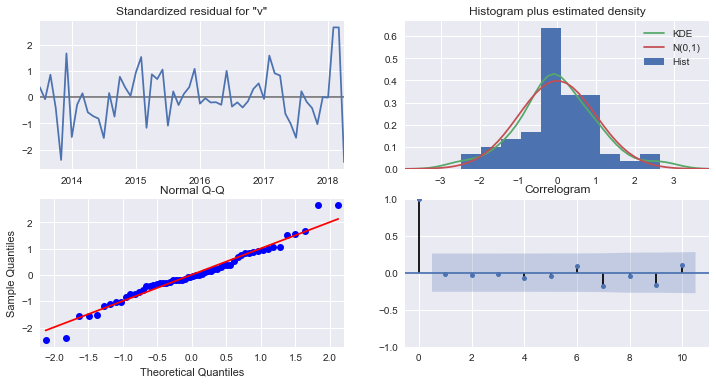

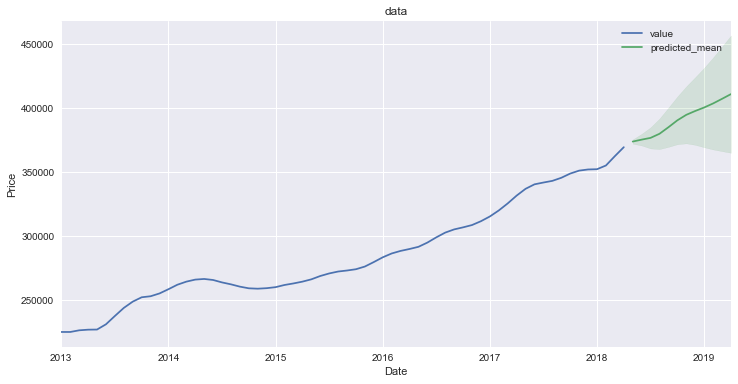

Modeling for zipcode 83845
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1316.031, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1319.784, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1320.374, Time=0.03 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1317.851, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1317.851, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1317.967, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1317.964, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1322.381, Time=0.02 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1317.280, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.584 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -657.016
Date:                Tue, 27 Apr 2021   AIC                           1316.031
Time:                        15:57:36   BIC                           1318.413
Sample:                             0   HQIC                          1316.986
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.958e+05    4.7e+04     16.931      0.000    7.04e+05    8.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.63   Jarque-Bera (JB):               507.40
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):              19.95   Skew:                             1.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -649.294
Date:                Tue, 27 Apr 2021   AIC                           1300.587
Time:                        15:57:36   BIC                           1302.957
Sample:                    01-01-2011   HQIC                          1301.536
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.051e+05   4.81e+04     16.727      0.000    7.11e+05    8.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               485.88
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):              19.99   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -708.222
Date:                Tue, 27 Apr 2021   AIC                           1418.443
Time:                        15:57:36   BIC                           1420.886
Sample:                    01-01-2011   HQIC                          1419.426
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.01e+06   6.92e+04     14.590      0.000    8.74e+05    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.64   Jarque-Bera (JB):               226.75
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              25.56   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

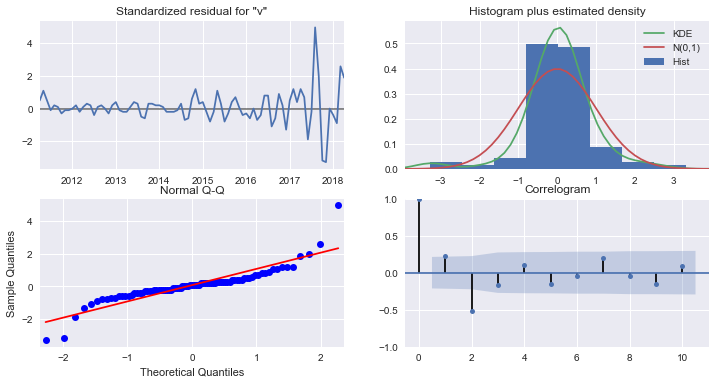

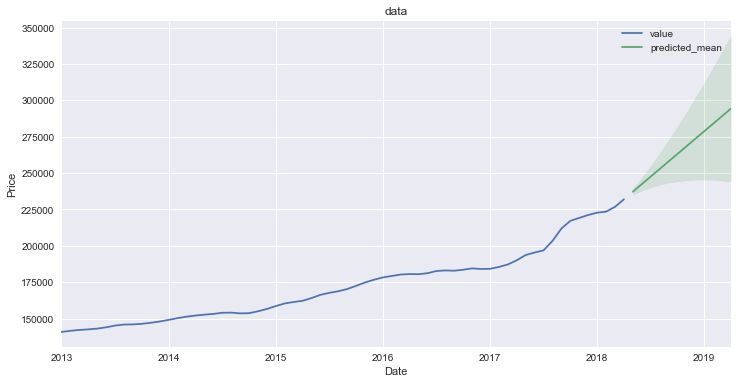

Modeling for zipcode 83347
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1190.368, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1194.170, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1194.154, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1192.136, Time=0.05 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1192.156, Time=0.06 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1192.408, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1192.367, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1192.367, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1192.293, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.623 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -594.184
Date:                Tue, 27 Apr 2021   AIC                           1190.368
Time:                        15:57:37   BIC                           1192.750
Sample:                             0   HQIC                          1191.323
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.654e+05   1.45e+04     11.417      0.000    1.37e+05    1.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.37   Jarque-Bera (JB):                93.02
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):               3.43   Skew:                            -1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -587.134
Date:                Tue, 27 Apr 2021   AIC                           1176.268
Time:                        15:57:37   BIC                           1178.638
Sample:                    01-01-2011   HQIC                          1177.218
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.669e+05   1.48e+04     11.309      0.000    1.38e+05    1.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.33   Jarque-Bera (JB):                88.69
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               3.38   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -667.648
Date:                Tue, 27 Apr 2021   AIC                           1337.296
Time:                        15:57:37   BIC                           1339.739
Sample:                    01-01-2011   HQIC                          1338.278
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.886e+05   2.76e+04     14.074      0.000    3.34e+05    4.43e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.16   Jarque-Bera (JB):               191.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.87   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

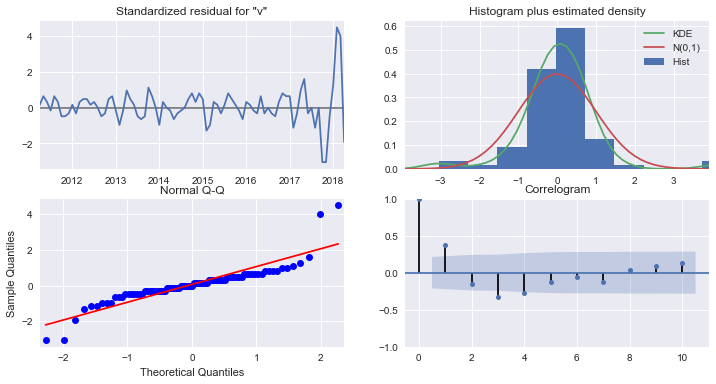

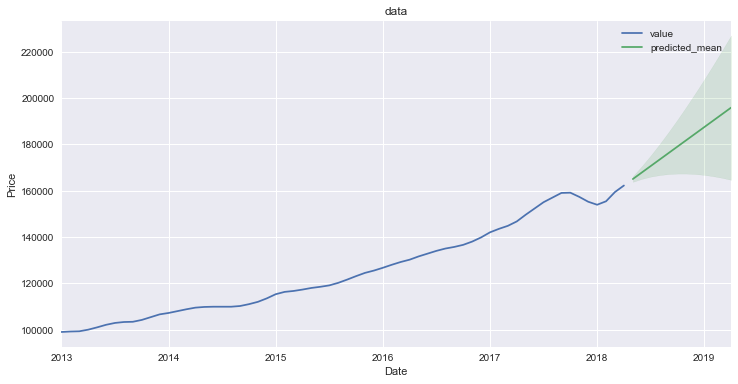

Modeling for zipcode 83607
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1275.261, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1276.521, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1276.975, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1275.182, Time=0.06 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1277.155, Time=0.16 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1277.163, Time=0.33 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1275.170, Time=0.06 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=1277.160, Time=0.18 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=inf, Time=0.48 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1276.509, Time=0.05 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1277.372, Time=0.16 sec
 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=1276.760, Time=0.04 sec

Best model:  ARIMA(0,2,0)(0,0,1)[12]          
Total fit time: 1.645 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -635.585
Date:                              Tue, 27 Apr 2021   AIC                           1275.170
Time:                                      15:57:40   BIC                           1279.934
Sample:                                           0   HQIC                          1277.080
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0301      0.032      0.941      0.347      -0.033       0.093
sigma2      4.624e+05   5.11e+04      9.044      0.000    3.62e+05    5.63e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.74   Jarque-Bera (JB):                15.92
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.22
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -516.728
Date:                              Tue, 27 Apr 2021   AIC                           1037.457
Time:                                      15:57:40   BIC                           1041.866
Sample:                                  01-01-2011   HQIC                          1039.202
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0451      0.160     -0.281      0.778      -0.359       0.269
sigma2      2.933e+05   4.43e+04      6.618      0.000    2.06e+05     3.8e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.18   Jarque-Bera (JB):                 4.82
Prob(Q):                              0.28   Prob(JB):                         0.09
Heteroskedasticity (H):               1.07   Skew:                             0.61
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -567.087
Date:                              Tue, 27 Apr 2021   AIC                           1138.174
Time:                                      15:57:40   BIC                           1142.755
Sample:                                  01-01-2011   HQIC                          1139.999
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1335      0.108     -1.232      0.218      -0.346       0.079
sigma2      3.434e+05   5.81e+04      5.911      0.000     2.3e+05    4.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.91   Jarque-Bera (JB):                 1.65
Prob(Q):                              0.17   Prob(JB):                         0.44
Heteroskedasticity (H):               1.47   Skew:                             0.35
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

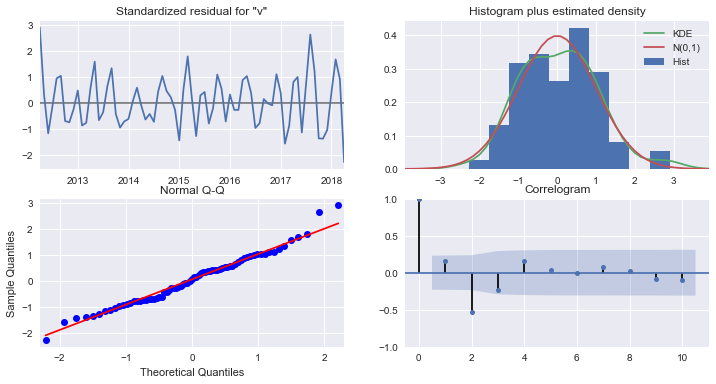

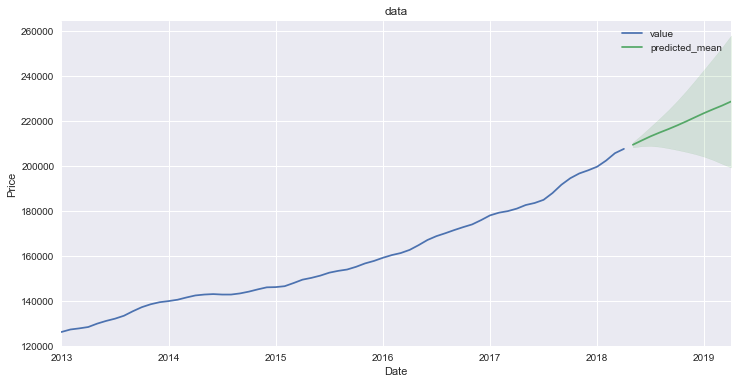

Modeling for zipcode 83336
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1161.245, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1164.506, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1164.311, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1163.242, Time=0.03 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1163.242, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1165.198, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1162.509, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1162.315, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1163.323, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1162.717, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.663 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -579.623
Date:                Tue, 27 Apr 2021   AIC                           1161.245
Time:                        15:57:42   BIC                           1163.627
Sample:                             0   HQIC                          1162.200
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.149e+05   1.88e+04      6.099      0.000     7.8e+04    1.52e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.50   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               2.35   Skew:                            -0.11
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -572.831
Date:                Tue, 27 Apr 2021   AIC                           1147.662
Time:                        15:57:42   BIC                           1150.032
Sample:                    01-01-2011   HQIC                          1148.612
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.162e+05   1.93e+04      6.017      0.000    7.83e+04    1.54e+05
===================================================================================
Ljung-Box (L1) (Q):                  10.16   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               2.28   Skew:                            -0.10
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -626.571
Date:                Tue, 27 Apr 2021   AIC                           1255.142
Time:                        15:57:42   BIC                           1257.585
Sample:                    01-01-2011   HQIC                          1256.124
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.478e+05   1.92e+04      7.705      0.000     1.1e+05    1.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.77   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.01   Prob(JB):                         0.13
Heteroskedasticity (H):               3.61   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

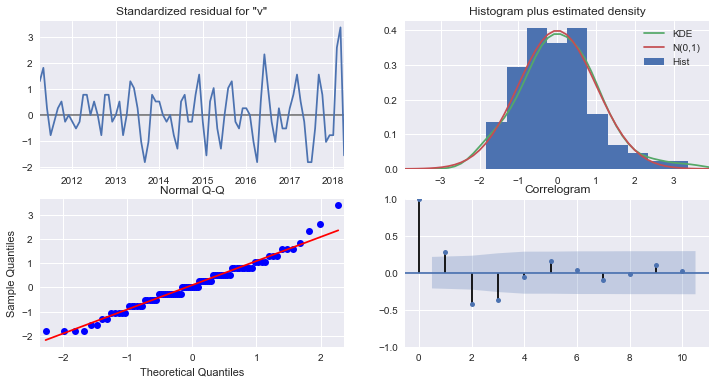

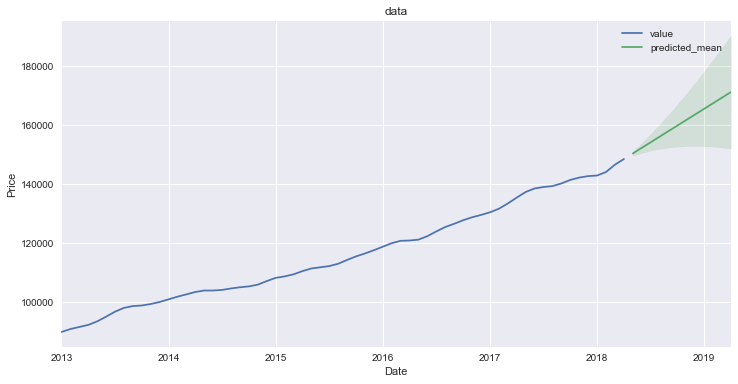

Modeling for zipcode 83706
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1295.899, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1298.909, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1299.507, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1298.020, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1297.877, Time=0.05 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1296.936, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1296.843, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1299.169, Time=0.05 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1297.351, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.496 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -646.950
Date:                Tue, 27 Apr 2021   AIC                           1295.899
Time:                        15:57:43   BIC                           1298.281
Sample:                             0   HQIC                          1296.854
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.186e+05   5.24e+04     11.802      0.000    5.16e+05    7.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.14   Jarque-Bera (JB):                90.95
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               3.65   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -639.071
Date:                Tue, 27 Apr 2021   AIC                           1280.143
Time:                        15:57:43   BIC                           1282.512
Sample:                    01-01-2011   HQIC                          1281.092
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.219e+05    5.3e+04     11.737      0.000    5.18e+05    7.26e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.80   Jarque-Bera (JB):                92.12
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.79   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -698.943
Date:                Tue, 27 Apr 2021   AIC                           1399.886
Time:                        15:57:44   BIC                           1402.328
Sample:                    01-01-2011   HQIC                          1400.868
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.119e+05   6.72e+04     12.085      0.000     6.8e+05    9.44e+05
===================================================================================
Ljung-Box (L1) (Q):                  16.12   Jarque-Bera (JB):               105.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.20   Skew:                            -1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

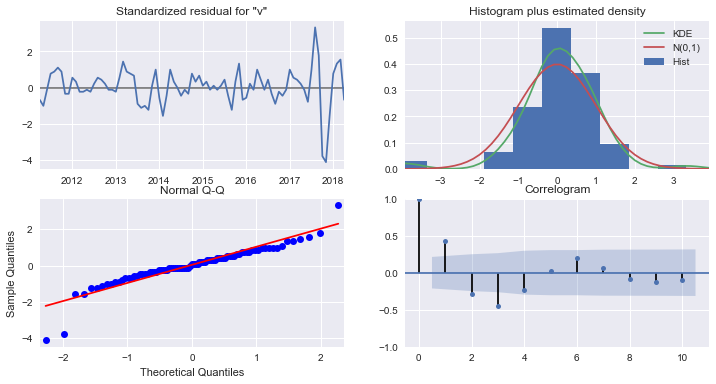

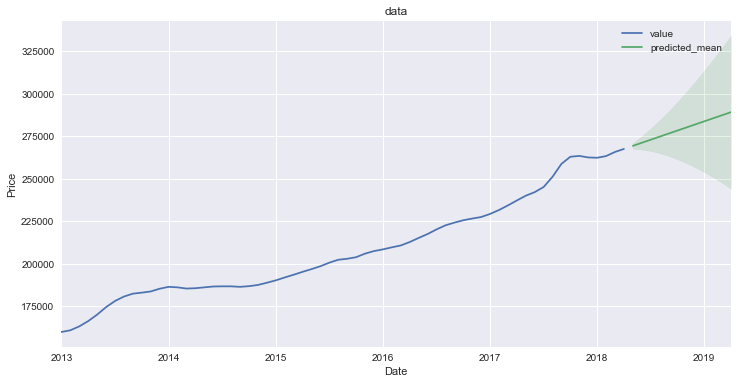

Modeling for zipcode 83655
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1170.668, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1174.129, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1174.095, Time=0.10 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1172.208, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1172.128, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.17 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1172.663, Time=0.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1173.221, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1167.735, Time=0.19 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1175.788, Time=0.12 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1175.755, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1177.692, Time=0.15 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1160.302, Time=0.04 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1161.356, Time=0.13 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -576.151
Date:                Tue, 27 Apr 2021   AIC                           1160.302
Time:                        15:57:47   BIC                           1169.831
Sample:                             0   HQIC                          1164.122
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6003      0.152      3.949      0.000       0.302       0.898
ar.L2         -0.1253      0.060     -2.085      0.037      -0.243      -0.008
ma.L1         -0.6292      0.139     -4.512      0.000      -0.903      -0.356
sigma2      8.868e+04   1.56e+04      5.679      0.000    5.81e+04    1.19e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):                 0.06
Prob(Q):                              0.34   Prob(JB):                         0.97
Heteroskedasticity (H):               0.71   Skew:                            -0.06
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -554.731
Date:                Tue, 27 Apr 2021   AIC                           1117.461
Time:                        15:57:47   BIC                           1126.888
Sample:                    01-01-2011   HQIC                          1121.235
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2573      0.165      1.563      0.118      -0.065       0.580
ar.L2         -0.4836      0.089     -5.439      0.000      -0.658      -0.309
ma.L1         -0.0753      0.183     -0.411      0.681      -0.434       0.284
sigma2      8.868e+04   1.76e+04      5.034      0.000    5.42e+04    1.23e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.75   Prob(JB):                         0.64
Heteroskedasticity (H):               0.82   Skew:                             0.13
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -608.632
Date:                Tue, 27 Apr 2021   AIC                           1225.265
Time:                        15:57:47   BIC                           1234.988
Sample:                    01-01-2011   HQIC                          1229.174
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2696      0.114      2.375      0.018       0.047       0.492
ar.L2         -0.6553      0.088     -7.452      0.000      -0.828      -0.483
ma.L1         -0.0675      0.157     -0.430      0.667      -0.376       0.240
sigma2      1.172e+05   1.96e+04      5.972      0.000    7.87e+04    1.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.87   Prob(JB):                         0.70
Heteroskedasticity (H):               1.67   Skew:                             0.22
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

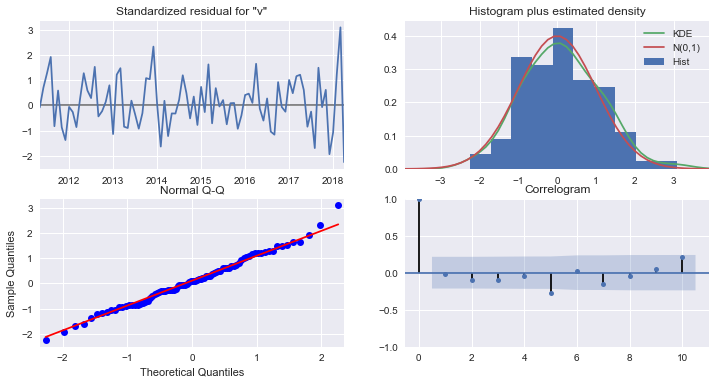

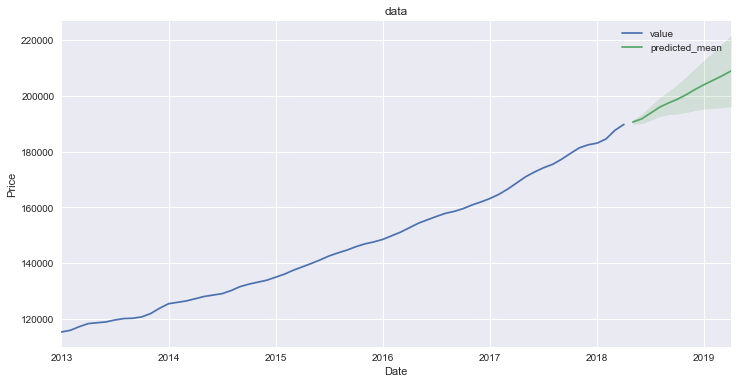

Modeling for zipcode 83835
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1418.727, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1409.729, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1408.613, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1409.315, Time=0.08 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1420.381, Time=0.14 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1419.975, Time=0.10 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1419.390, Time=0.03 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=1421.450, Time=0.30 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1418.242, Time=0.07 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1417.336, Time=0.07 sec
 ARIMA(0,2,2)(0,0,1)[12]             : AIC=1407.324, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1409.568, Time=0.04 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=1408.210, Time=0.30 sec
 ARIMA(0,2,2)(0,0,2)[12]             : AIC=1407.773, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -668.056
Date:                Tue, 27 Apr 2021   AIC                           1348.112
Time:                        15:57:57   BIC                           1362.404
Sample:                             0   HQIC                          1353.842
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4806      0.051     -9.462      0.000      -0.580      -0.381
ar.L2         -0.7816      0.035    -22.275      0.000      -0.850      -0.713
ar.L3         -0.0207      0.026     -0.800      0.424      -0.072       0.030
ma.L1          0.5195      0.043     11.985      0.000       0.435       0.604
ma.L2          0.7517      0.039     19.091      0.000       0.675       0.829
sigma2      9.237e+05   1.06e-08   8.73e+13      0.000    9.24e+05    9.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.14   Jarque-Bera (JB):                 2.37
Prob(Q):                              0.01   Prob(JB):                         0.31
Heteroskedasticity (H):               0.58   Skew:                            -0.39
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.71e+29. Standard errors may be unstable.
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -637.961
Date:                Tue, 27 Apr 2021   AIC                           1287.923
Time:                        15:57:57   BIC                           1301.986
Sample:                    01-01-2011   HQIC                          1293.548
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5742      0.103     -5.597      0.000      -0.775      -0.373
ar.L2         -0.6711      0.104     -6.461      0.000      -0.875      -0.468
ar.L3         -0.2579      0.042     -6.151      0.000      -0.340      -0.176
ma.L1          0.9341      0.155      6.036      0.000       0.631       1.237
ma.L2          0.2536      0.061      4.163      0.000       0.134       0.373
sigma2      9.237e+05   1.98e+05      4.675      0.000    5.36e+05    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):                 1.23
Prob(Q):                              0.35   Prob(JB):                         0.54
Heteroskedasticity (H):               0.47   Skew:                            -0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(3, 2, 2)   Log Likelihood                -685.455
Date:                Tue, 27 Apr 2021   AIC                           1382.910
Time:                        15:57:57   BIC                           1397.423
Sample:                    01-01-2011   HQIC                          1388.741
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5753      0.098     -5.849      0.000      -0.768      -0.382
ar.L2         -0.6640      0.101     -6.578      0.000      -0.862      -0.466
ar.L3         -0.2553      0.040     -6.411      0.000      -0.333      -0.177
ma.L1          0.9401      0.147      6.374      0.000       0.651       1.229
ma.L2          0.2557      0.060      4.280      0.000       0.139       0.373
sigma2      8.977e+05   1.83e+05      4.896      0.000    5.38e+05    1.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.81   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.37   Prob(JB):                         0.63
Heteroskedasticity (H):               0.39   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

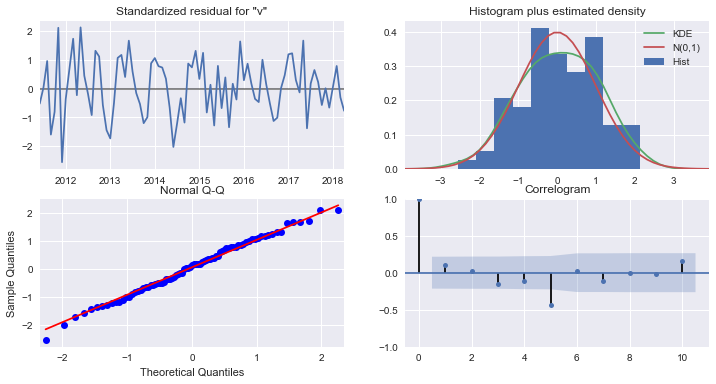

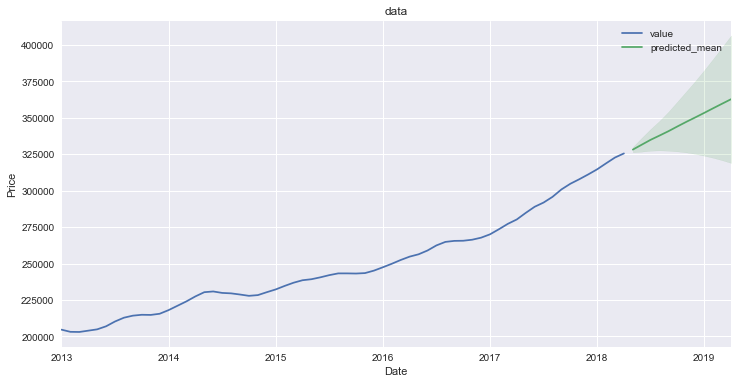

Modeling for zipcode 83687
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1277.121, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1278.888, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1278.625, Time=0.10 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1277.546, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1277.463, Time=0.08 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1278.243, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1278.195, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1279.434, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1278.859, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.620 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -637.561
Date:                Tue, 27 Apr 2021   AIC                           1277.121
Time:                        15:57:59   BIC                           1279.503
Sample:                             0   HQIC                          1278.076
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.892e+05   5.48e+04      8.920      0.000    3.82e+05    5.97e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.51   Jarque-Bera (JB):                14.52
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.36   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -629.066
Date:                Tue, 27 Apr 2021   AIC                           1260.132
Time:                        15:57:59   BIC                           1262.502
Sample:                    01-01-2011   HQIC                          1261.082
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       4.83e+05   5.36e+04      9.019      0.000    3.78e+05    5.88e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.54   Jarque-Bera (JB):                15.94
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.37   Skew:                            -0.21
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -675.308
Date:                Tue, 27 Apr 2021   AIC                           1352.615
Time:                        15:57:59   BIC                           1355.058
Sample:                    01-01-2011   HQIC                          1353.598
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.627e+05   4.87e+04      9.505      0.000    3.67e+05    5.58e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.90   Jarque-Bera (JB):                17.81
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                            -0.19
Prob(H) (two-sided):                  0.02   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

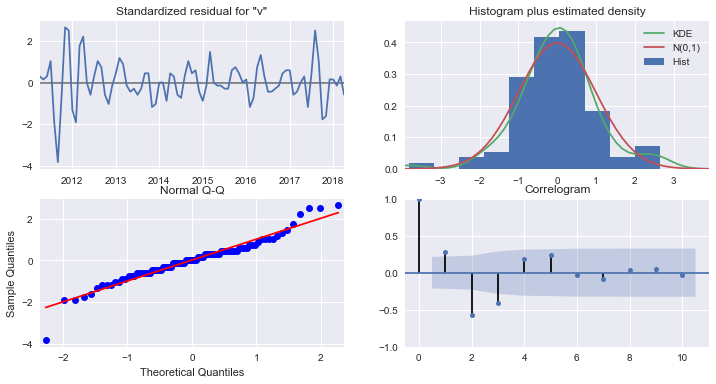

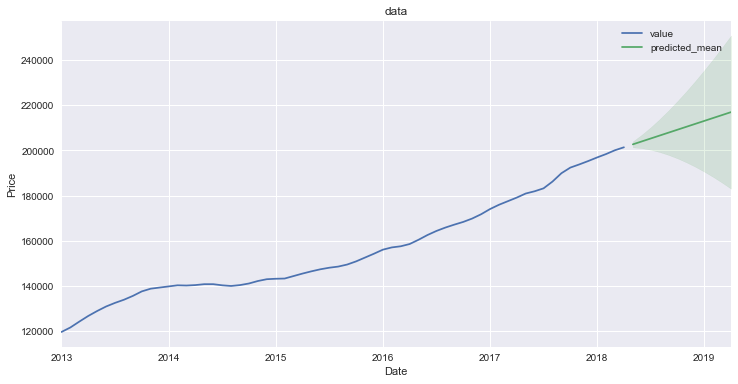

Modeling for zipcode 83714
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1386.086, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1389.976, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1389.750, Time=0.07 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1388.263, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1396.214, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1388.196, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1387.954, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1390.048, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1388.078, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.456 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -692.043
Date:                Tue, 27 Apr 2021   AIC                           1386.086
Time:                        15:58:00   BIC                           1388.468
Sample:                             0   HQIC                          1387.041
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.91e+06    1.1e+05     17.304      0.000    1.69e+06    2.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.31   Jarque-Bera (JB):               563.33
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               9.91   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -683.879
Date:                Tue, 27 Apr 2021   AIC                           1369.758
Time:                        15:58:00   BIC                           1372.128
Sample:                    01-01-2011   HQIC                          1370.708
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.932e+06   1.13e+05     17.099      0.000    1.71e+06    2.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.23   Jarque-Bera (JB):               540.47
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               9.88   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -735.628
Date:                Tue, 27 Apr 2021   AIC                           1473.256
Time:                        15:58:00   BIC                           1475.699
Sample:                    01-01-2011   HQIC                          1474.239
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.924e+06   1.12e+05     17.185      0.000     1.7e+06    2.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   8.32   Jarque-Bera (JB):               505.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.81   Skew:                            -0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

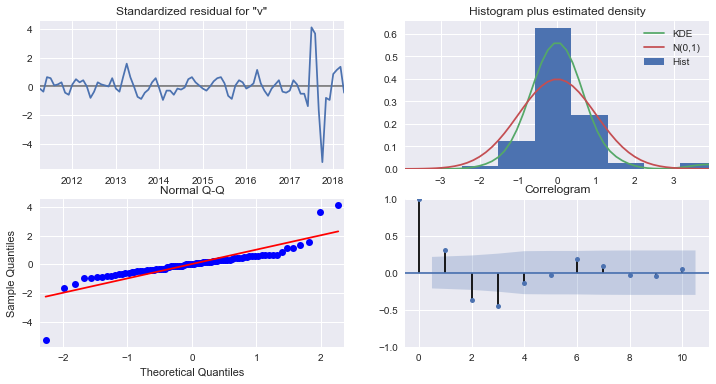

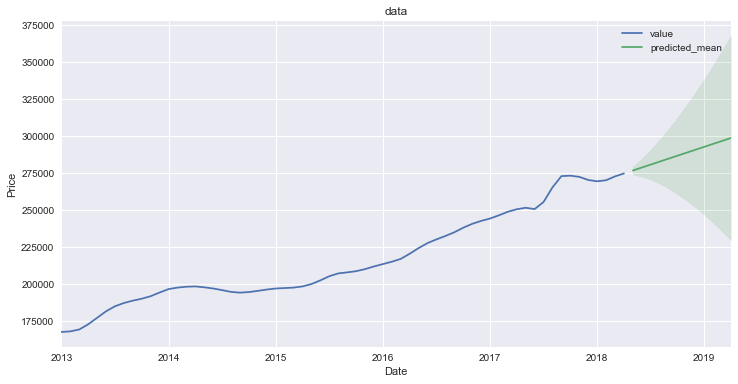

Modeling for zipcode 83709
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1355.980, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1358.694, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1358.683, Time=0.03 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1357.533, Time=0.02 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1365.656, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1365.975, Time=0.14 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1357.509, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1357.473, Time=0.02 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1359.171, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1357.812, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.441 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -676.990
Date:                Tue, 27 Apr 2021   AIC                           1355.980
Time:                        15:58:02   BIC                           1358.362
Sample:                             0   HQIC                          1356.935
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.311e+06   6.35e+04     20.642      0.000    1.19e+06    1.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.99   Jarque-Bera (JB):              1357.54
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               9.96   Skew:                            -2.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -668.889
Date:                Tue, 27 Apr 2021   AIC                           1339.778
Time:                        15:58:02   BIC                           1342.147
Sample:                    01-01-2011   HQIC                          1340.727
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.322e+06   6.46e+04     20.462      0.000     1.2e+06    1.45e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.06   Jarque-Bera (JB):              1336.48
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):              10.33   Skew:                            -2.10
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -728.876
Date:                Tue, 27 Apr 2021   AIC                           1459.752
Time:                        15:58:02   BIC                           1462.194
Sample:                    01-01-2011   HQIC                          1460.734
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.642e+06   9.28e+04     17.689      0.000    1.46e+06    1.82e+06
===================================================================================
Ljung-Box (L1) (Q):                  16.09   Jarque-Bera (JB):               641.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              13.58   Skew:                            -1.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

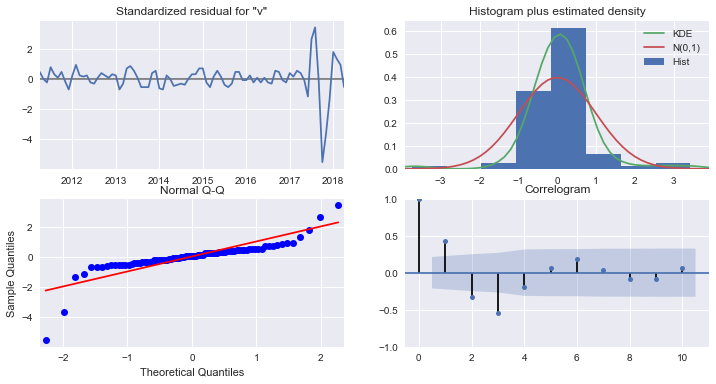

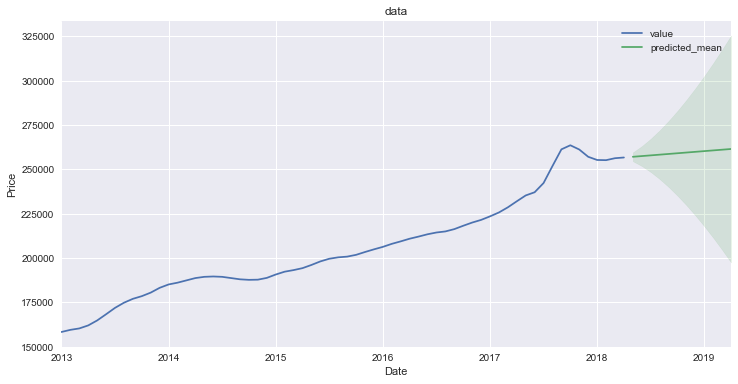

Modeling for zipcode 83704
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1295.494, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1299.508, Time=0.15 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1300.254, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1297.423, Time=0.07 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1304.127, Time=0.02 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1300.859, Time=0.13 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1297.605, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1297.214, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1300.299, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1296.964, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.601 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -646.747
Date:                Tue, 27 Apr 2021   AIC                           1295.494
Time:                        15:58:03   BIC                           1297.876
Sample:                             0   HQIC                          1296.449
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.155e+05   4.13e+04     14.894      0.000    5.34e+05    6.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.35   Jarque-Bera (JB):               279.00
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               7.45   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -639.152
Date:                Tue, 27 Apr 2021   AIC                           1280.303
Time:                        15:58:04   BIC                           1282.673
Sample:                    01-01-2011   HQIC                          1281.252
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.229e+05   4.23e+04     14.709      0.000     5.4e+05    7.06e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.17   Jarque-Bera (JB):               266.55
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               7.46   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -693.227
Date:                Tue, 27 Apr 2021   AIC                           1388.454
Time:                        15:58:04   BIC                           1390.897
Sample:                    01-01-2011   HQIC                          1389.437
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.096e+05   5.26e+04     13.484      0.000    6.06e+05    8.13e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.27   Jarque-Bera (JB):               154.72
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

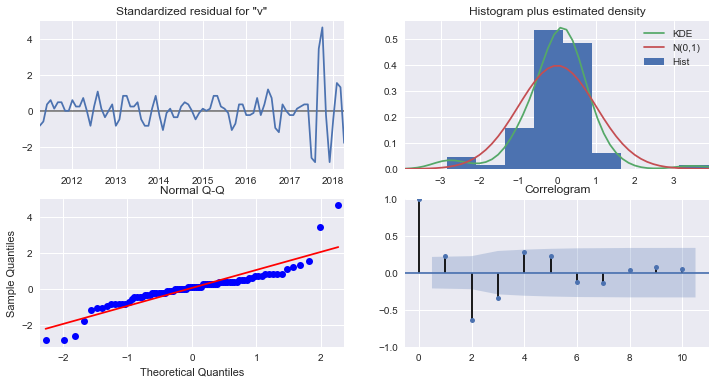

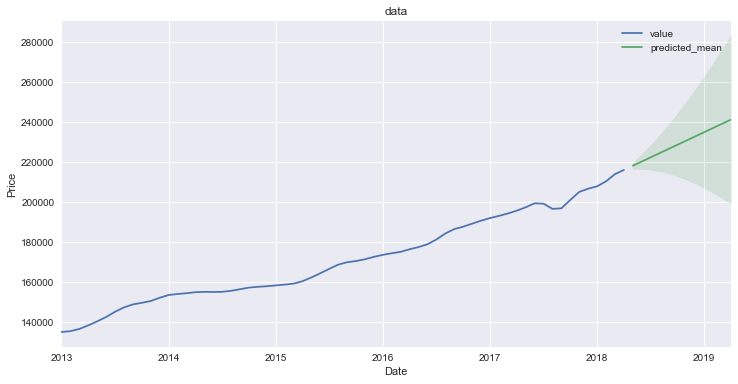

Modeling for zipcode 83815
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1390.825, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1383.629, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1393.061, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1383.656, Time=0.01 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1383.333, Time=0.26 sec
 ARIMA(1,2,0)(3,0,0)[12]             : AIC=1385.195, Time=0.34 sec
 ARIMA(1,2,0)(2,0,1)[12]             : AIC=1385.184, Time=0.29 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1383.654, Time=0.12 sec
 ARIMA(1,2,0)(3,0,1)[12]             : AIC=1387.197, Time=0.27 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1390.687, Time=0.15 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=1366.824, Time=0.28 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1375.600, Time=0.04 sec
 ARIMA(2,2,0)(3,0,0)[12]             : AIC=1374.827, Time=0.19 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=1368.584, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -661.705
Date:                            Tue, 27 Apr 2021   AIC                           1337.409
Time:                                    15:58:15   BIC                           1354.083
Sample:                                         0   HQIC                          1344.094
                                             - 82                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0256      0.087      0.294      0.768      -0.145       0.196
ar.L2         -0.0836      0.027     -3.122      0.002      -0.136      -0.031
ar.L3         -0.0463      0.052     -0.894      0.371      -0.148       0.055
ar.L4          0.0550      0.055      0.996      0.319      -0.053       0.163
ar.S.L12      -0.0199      0.011     -1.769      0.077      -0.042       0.002
ar.S.L24      -0.0246      0.013     -1.851      0.064      -0.051       0.001
sigma2      7.139e+05   1.07e+05      6.655      0.000    5.04e+05    9.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 0.92
Prob(Q):                              0.66   Prob(JB):                         0.63
Heteroskedasticity (H):               0.28   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -401.873
Date:                            Tue, 27 Apr 2021   AIC                            817.747
Time:                                    15:58:15   BIC                            831.406
Sample:                                01-01-2011   HQIC                           822.983
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4129      0.199      2.078      0.038       0.023       0.802
ar.L2         -0.4641      0.288     -1.613      0.107      -1.028       0.100
ar.L3         -0.0728      0.203     -0.358      0.720      -0.471       0.326
ar.L4         -0.0735      0.234     -0.315      0.753      -0.531       0.384
ar.S.L12      -0.0340      0.130     -0.263      0.793      -0.288       0.220
ar.S.L24      -0.0291      0.093     -0.314      0.754      -0.211       0.153
sigma2      3.022e+05   6.02e+04      5.023      0.000    1.84e+05     4.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 3.21
Prob(Q):                              0.70   Prob(JB):                         0.20
Heteroskedasticity (H):               1.69   Skew:                            -0.51
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -453.374
Date:                            Tue, 27 Apr 2021   AIC                            920.747
Time:                                    15:58:15   BIC                            935.170
Sample:                                01-01-2011   HQIC                           926.365
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4374      0.167      2.612      0.009       0.109       0.766
ar.L2         -0.5211      0.255     -2.044      0.041      -1.021      -0.021
ar.L3         -0.0568      0.144     -0.395      0.693      -0.338       0.225
ar.L4         -0.0597      0.158     -0.379      0.705      -0.369       0.249
ar.S.L12       0.0151      0.141      0.107      0.915      -0.262       0.292
ar.S.L24      -0.0357      0.105     -0.341      0.733      -0.241       0.170
sigma2      3.607e+05   6.82e+04      5.287      0.000    2.27e+05    4.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 1.96
Prob(Q):                              0.77   Prob(JB):                         0.38
Heteroskedasticity (H):               1.89   Skew:                            -0.39
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

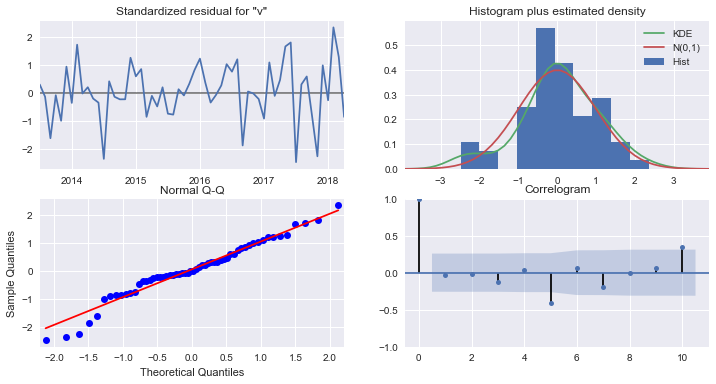

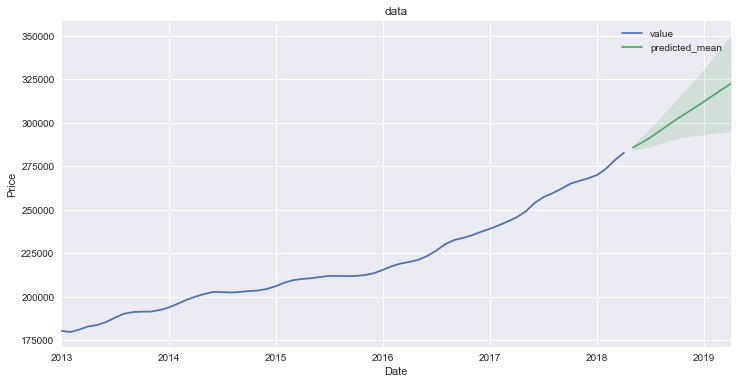

Modeling for zipcode 83686
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1263.162, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1264.478, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1264.928, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1263.240, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1263.143, Time=0.09 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1264.050, Time=0.34 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=1263.964, Time=0.15 sec
 ARIMA(0,2,0)(1,0,2)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1264.490, Time=0.03 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1265.024, Time=0.10 sec
 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=1264.828, Time=0.05 sec

Best model:  ARIMA(0,2,0)(0,0,1)[12]          
Total fit time: 1.405 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -629.571
Date:                              Tue, 27 Apr 2021   AIC                           1263.143
Time:                                      15:58:18   BIC                           1267.907
Sample:                                           0   HQIC                          1265.053
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.0318      0.027      1.182      0.237      -0.021       0.084
sigma2      3.973e+05   4.42e+04      8.985      0.000    3.11e+05    4.84e+05
===================================================================================
Ljung-Box (L1) (Q):                   5.61   Jarque-Bera (JB):                14.80
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -505.115
Date:                              Tue, 27 Apr 2021   AIC                           1014.230
Time:                                      15:58:18   BIC                           1018.639
Sample:                                  01-01-2011   HQIC                          1015.974
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1466      0.122     -1.205      0.228      -0.385       0.092
sigma2      2.098e+05   3.09e+04      6.793      0.000    1.49e+05     2.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.50   Jarque-Bera (JB):                 6.17
Prob(Q):                              0.11   Prob(JB):                         0.05
Heteroskedasticity (H):               0.63   Skew:                             0.67
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(0, 2, 0)x(0, 0, [1], 12)   Log Likelihood                -553.061
Date:                              Tue, 27 Apr 2021   AIC                           1110.122
Time:                                      15:58:18   BIC                           1114.703
Sample:                                  01-01-2011   HQIC                          1111.947
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.1765      0.140     -1.260      0.208      -0.451       0.098
sigma2      2.253e+05   3.28e+04      6.876      0.000    1.61e+05     2.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.61   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.06   Prob(JB):                         0.22
Heteroskedasticity (H):               0.92   Skew:                             0.39
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

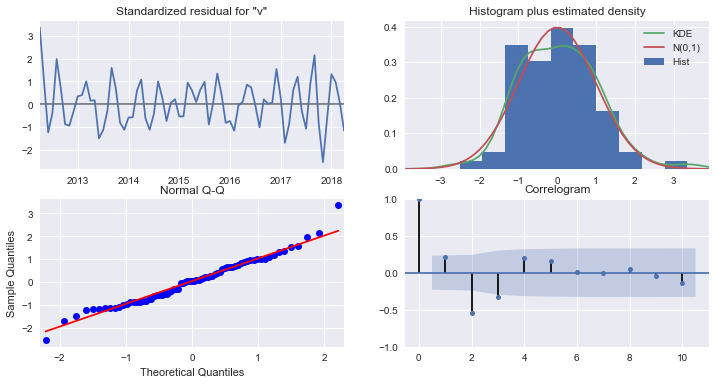

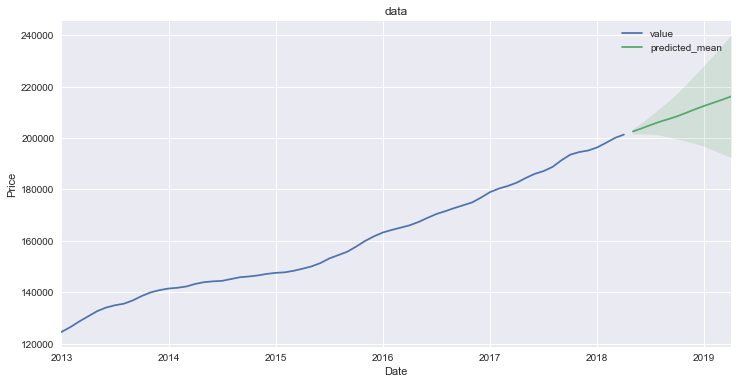

Modeling for zipcode 83660
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1322.112, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1326.539, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1326.823, Time=0.03 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1323.994, Time=0.06 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1325.235, Time=0.03 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=inf, Time=0.18 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1324.095, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1324.094, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1326.931, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1323.902, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.563 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -660.056
Date:                Tue, 27 Apr 2021   AIC                           1322.112
Time:                        15:58:20   BIC                           1324.494
Sample:                             0   HQIC                          1323.067
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.586e+05   1.38e+05      6.233      0.000    5.89e+05    1.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.95   Jarque-Bera (JB):                 0.29
Prob(Q):                              0.00   Prob(JB):                         0.87
Heteroskedasticity (H):               0.80   Skew:                            -0.15
Prob(H) (two-sided):                  0.56   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -652.210
Date:                Tue, 27 Apr 2021   AIC                           1306.420
Time:                        15:58:20   BIC                           1308.790
Sample:                    01-01-2011   HQIC                          1307.370
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       8.67e+05   1.41e+05      6.160      0.000    5.91e+05    1.14e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.70   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.00   Prob(JB):                         0.89
Heteroskedasticity (H):               0.77   Skew:                            -0.13
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -699.826
Date:                Tue, 27 Apr 2021   AIC                           1401.652
Time:                        15:58:20   BIC                           1404.094
Sample:                    01-01-2011   HQIC                          1402.634
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.288e+05   1.27e+05      6.507      0.000    5.79e+05    1.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   9.51   Jarque-Bera (JB):                 0.17
Prob(Q):                              0.00   Prob(JB):                         0.92
Heteroskedasticity (H):               0.62   Skew:                            -0.11
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

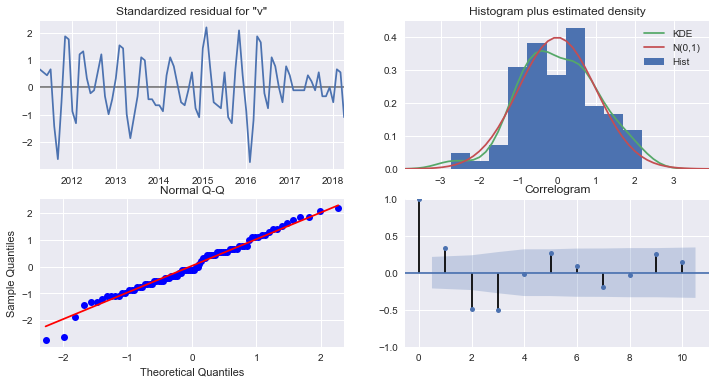

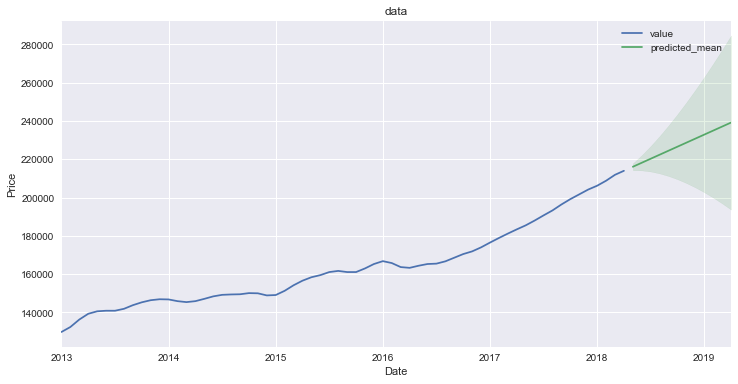

Modeling for zipcode 83276
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1155.477, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1158.409, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1158.488, Time=0.04 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1156.553, Time=0.04 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1156.624, Time=0.06 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1156.097, Time=0.20 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1157.363, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1157.166, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1158.215, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[12] intercept   : AIC=1157.008, Time=0.01 sec

Best model:  ARIMA(0,2,0)(0,0,0)[12]          
Total fit time: 0.579 seconds
Auto_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -576.738
Date:                Tue, 27 Apr 2021   AIC                           1155.477
Time:                        15:58:21   BIC                           1157.859
Sample:                             0   HQIC                          1156.432
                                 - 82                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.069e+05   1.77e+04      6.043      0.000    7.23e+04    1.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.33   Jarque-Bera (JB):                 0.10
Prob(Q):                              0.01   Prob(JB):                         0.95
Heteroskedasticity (H):               1.25   Skew:                            -0.01
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -569.980
Date:                Tue, 27 Apr 2021   AIC                           1141.960
Time:                        15:58:21   BIC                           1144.329
Sample:                    01-01-2011   HQIC                          1142.909
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.081e+05   1.81e+04      5.962      0.000    7.26e+04    1.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.11   Jarque-Bera (JB):                 0.14
Prob(Q):                              0.01   Prob(JB):                         0.93
Heteroskedasticity (H):               1.24   Skew:                             0.00
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -614.186
Date:                Tue, 27 Apr 2021   AIC                           1230.373
Time:                        15:58:21   BIC                           1232.816
Sample:                    01-01-2011   HQIC                          1231.355
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.105e+05   1.84e+04      6.018      0.000    7.45e+04    1.46e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.75   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.01   Prob(JB):                         0.85
Heteroskedasticity (H):               1.28   Skew:                             0.00
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

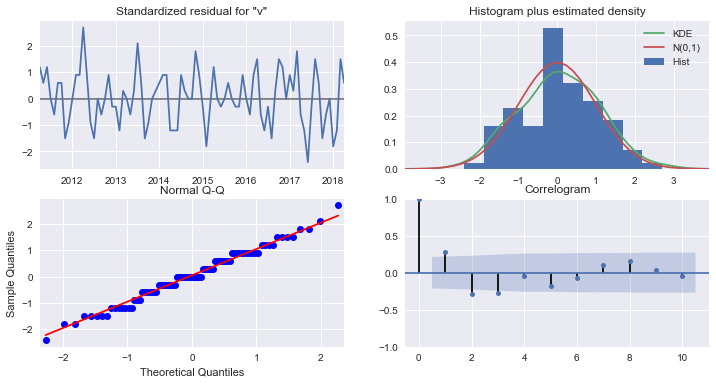

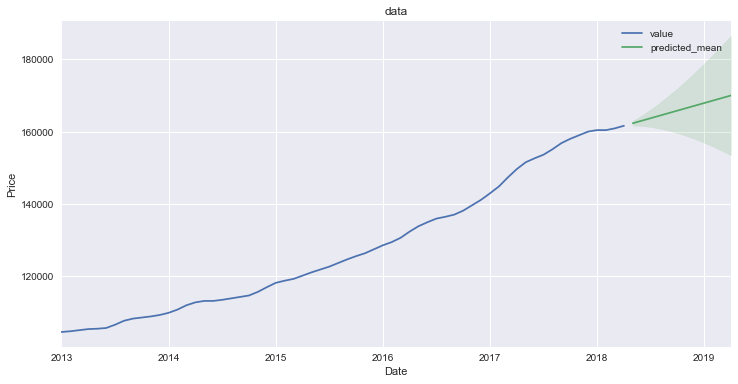

Modeling for zipcode 83858
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1402.073, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1393.605, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1403.299, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1393.367, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=1393.567, Time=0.05 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=1394.086, Time=0.14 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1383.046, Time=0.02 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=1382.772, Time=0.04 sec
 ARIMA(2,2,0)(2,0,0)[12]             : AIC=1383.089, Time=0.09 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=1382.196, Time=0.20 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=1382.707, Time=0.05 sec
 ARIMA(2,2,0)(2,0,1)[12]             : AIC=1384.087, Time=0.45 sec
 ARIMA(2,2,0)(1,0,2)[12]             : AIC=1384.087, Time=0.31 sec
 ARIMA(2,2,0)(0,0,2)[12]             : AIC=1382.996, Time=0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -670.214
Date:                              Tue, 27 Apr 2021   AIC                           1354.427
Time:                                      15:58:32   BIC                           1371.101
Sample:                                           0   HQIC                          1361.112
                                               - 82                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0248      0.072      0.347      0.729      -0.116       0.165
ar.L2         -0.0764      0.039     -1.966      0.049      -0.153      -0.000
ar.L3         -0.0405      0.052     -0.779      0.436      -0.142       0.061
ar.L4          0.0462      0.049      0.937      0.349      -0.051       0.143
ar.S.L12       0.6631      0.400      1.658      0.097      -0.121       1.447
ma.S.L12      -0.6827      0.396     -1.723      0.085      -1.460       0.094
sigma2      9.201e+05   1.25e+05      7.363      0.000    6.75e+05    1.17e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.66   Jarque-Bera (JB):                 1.88
Prob(Q):                              0.20   Prob(JB):                         0.39
Heteroskedasticity (H):               0.53   Skew:                            -0.18
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -513.261
Date:                              Tue, 27 Apr 2021   AIC                           1040.522
Time:                                      15:58:33   BIC                           1055.635
Sample:                                  01-01-2011   HQIC                          1046.476
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6663      0.133      5.020      0.000       0.406       0.926
ar.L2         -0.6834      0.148     -4.617      0.000      -0.974      -0.393
ar.L3          0.1922      0.152      1.260      0.208      -0.107       0.491
ar.L4         -0.0142      0.120     -0.119      0.905      -0.249       0.220
ar.S.L12      -0.1919      0.101     -1.895      0.058      -0.391       0.007
ma.S.L12       0.4214      0.227      1.854      0.064      -0.024       0.867
sigma2      5.217e+05   1.04e+05      5.030      0.000    3.18e+05    7.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.99   Prob(JB):                         0.79
Heteroskedasticity (H):               1.48   Skew:                            -0.19
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -566.499
Date:                              Tue, 27 Apr 2021   AIC                           1146.998
Time:                                      15:58:33   BIC                           1162.737
Sample:                                  01-01-2011   HQIC                          1153.250
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6554      0.107      6.131      0.000       0.446       0.865
ar.L2         -0.8841      0.134     -6.603      0.000      -1.146      -0.622
ar.L3          0.4632      0.125      3.707      0.000       0.218       0.708
ar.L4         -0.3828      0.117     -3.274      0.001      -0.612      -0.154
ar.S.L12       0.2353      0.136      1.737      0.082      -0.030       0.501
ma.S.L12       0.0970      0.157      0.617      0.537      -0.211       0.405
sigma2      6.149e+05   1.12e+05      5.471      0.000    3.95e+05    8.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.72   Prob(JB):                         0.98
Heteroskedasticity (H):               1.78   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

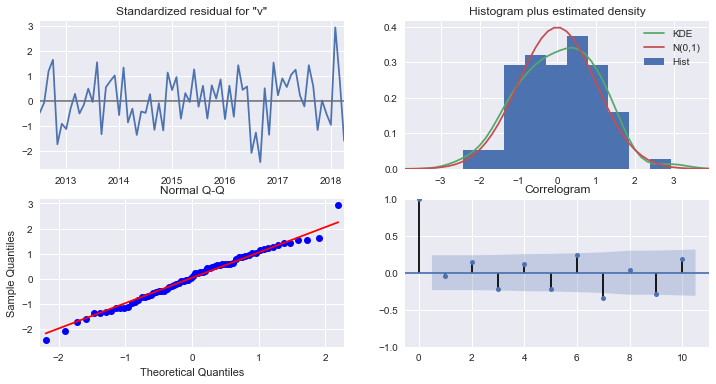

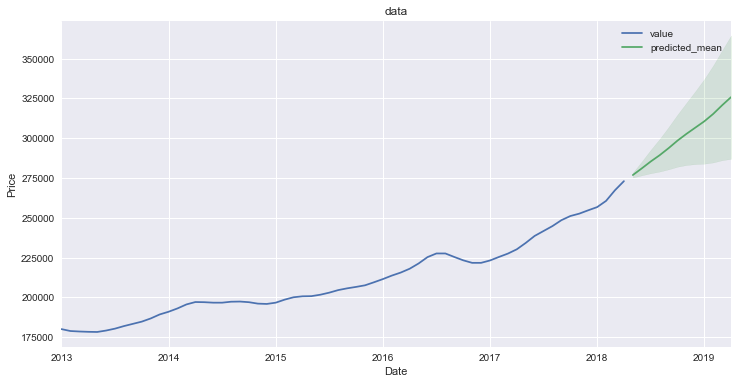

In [213]:
# Looping through the zipcodes in the dictionary and finding the best model and finding
# the one year prediction

i = 0
for k,v in Idaho_25_short_dict.items():
    
    print('Modeling for zipcode {}'.format(k))
    if i==0:
        
        # Takes the first zipcode and runs it through the autobot function
        results = autobot(v)
        results.append(k)
        
        # Takes the results from the autobot function and makes a dataframe
        results_df=pd.DataFrame(pd.Series(results))
        results_df=results_df.T
        results_df.columns=['order','seasonal_order','train_mse','train_dyn_mse',
                            'train_forecast_mse','train_forecast_rmse','final_mse',
                            'final_dyn_mse', 'final_dyn_rmse',
                            'last_known_price','1_year_forecast', '1_year_forecast_low',
                            '1_year_forecast_high', 'zip']
        i+=1
        
    elif i>0:
        
        # Takes all the other zipcodes and runs it through the autbot function
        results = autobot(v)
        results.append(k)
        
        # Adds the results to the dataframe
        results_df = results_df.append(pd.Series(results, index=results_df.columns), ignore_index=True)
        i+=1

# Sets the dataframe index as the zipcode name
results_df.set_index('zip', inplace=True)

In [214]:
# Creating a new column in df for the 1_year_future_ROI
results_df['1_year_forecast_ROI'] = (
    results_df['1_year_forecast'] - results_df['last_known_price']) / results_df['last_known_price']

# Creating a new column for 95% confidence variance
results_df['1_year_forecast_variance'] = results_df['1_year_forecast_high'] - results_df['1_year_forecast_low']

# Sorting dataframe by "1_year_future_ROI" descending
results_df_ROI_sorted = results_df.sort_values(by='1_year_forecast_ROI', ascending=False)

# Sorting dataframe by "1_year_forecast_variance"
results_df_VAR_sorted = results_df.sort_values(by='1_year_forecast_variance', ascending=True)

In [215]:
# This is the results dataframe without any sorting
results_df.head()

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_variance
zip                                                                                                                                                                                                                                                               
83703  (0, 2, 0)  (0, 0, 0, 12)     4.22e+06   1.77058e+08        5.96117e+07             7720.86  4.94286e+06   8.17039e+08        28583.9           264200          307400              256465               358335            0.163512                   101869
83814  (4, 2, 0)  (1, 0, 1, 12)  1.48971e+06   2.58593e+07             223454             472.709       291583    1.1164e+07        3341.26           316900          347509              299452               395566           0.0965895                  96113.8
83676  (0, 2, 0)  (0, 0, 0, 12)  1.63308e+06   3.81585e+07        1.79833e+06             1341.02  1.52857e+06   7.24143e+06        2690.99           229400          258200              195169               321231            0.125545                   126062
83605  (0, 2, 0)  (0, 0, 0, 12)       116154      8.68e+06           2.18e+06             1476.48       265714   1.94686e+07        4412.32           166800          195600              168514               222686            0.172662                  54171.9
83702  (0, 2, 0)  (0, 0, 0, 12)  9.30231e+06   2.81027e+08        1.07638e+09             32808.3    3.037e+07    4.0173e+09        63382.1           441000          501000              402562               599438            0.136054                   196876

In [216]:
# Getting the 5 best future ROI's
top_5_zipcodes_ROI = results_df_ROI_sorted.index[0:5]
top_5_zipcodes_VAR = results_df_VAR_sorted.index[0:5]

print('The top 5 best zipcodes for ROI {}'.format(list(top_5_zipcodes_ROI)))
print('The top 5 best zipcodes for Stability {}'.format(list(top_5_zipcodes_VAR)))

The top 5 best zipcodes for ROI ['83845', '83347', '83350', '83858', '83605']
The top 5 best zipcodes for Stability ['83655', '83350', '83276', '83336', '83651']


In [217]:
# Results dataframe sorted by ROI
results_df_ROI_sorted.head()

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_variance
zip                                                                                                                                                                                                                                                               
83845  (0, 2, 0)  (0, 0, 0, 12)  3.78538e+06   2.77442e+08        1.59527e+08             12630.4  4.63857e+06   6.72966e+08        25941.6           232000          294400              244189               344611            0.268966                   100421
83347  (0, 2, 0)  (0, 0, 0, 12)       510769     7.958e+07         1.2295e+07             3506.42  3.35429e+06   1.05701e+08        10281.1           162200          195800              164651               226949            0.207152                  62298.5
83350  (0, 2, 0)  (0, 0, 0, 12)      82307.7   4.48169e+07             728333             853.424       324286        650000        806.226           138200          165800              150192               181408            0.199711                  31216.2
83858  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470             0.19321                  77446.8
83605  (0, 2, 0)  (0, 0, 0, 12)       116154      8.68e+06           2.18e+06             1476.48       265714   1.94686e+07        4412.32           166800          195600              168514               222686            0.172662                  54171.9

In [218]:
# Results dataframe sorted by Variance
results_df_VAR_sorted.head()

order seasonal_order train_mse train_dyn_mse train_forecast_mse train_forecast_rmse final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_variance
zip                                                                                                                                                                                                                                                         
83655  (2, 2, 1)  (0, 0, 0, 12)   94350.3   3.06042e+07        1.20837e+06             1099.26    358248        688290        829.632           189700          208791              196104               221478            0.100638                  25374.6
83350  (0, 2, 0)  (0, 0, 0, 12)   82307.7   4.48169e+07             728333             853.424    324286        650000        806.226           138200          165800              150192               181408            0.199711                  31216.2
83276  (0, 2, 0)  (0, 0, 0, 12)    173846   7.18446e+07          4.995e+06             2234.95    157143   1.81671e+07        4262.29           161600          170000              153392               186608           0.0519802                    33216
83336  (0, 2, 0)  (0, 0, 0, 12)    159231   1.06154e+06        1.80667e+06             1344.12    497143        905714         951.69           148500          171300              152088               190512            0.153535                  38424.8
83651  (0, 2, 0)  (0, 0, 1, 12)    190797   1.99172e+06        2.73416e+06             1653.53    202949   1.44197e+07        3797.32           175400          200165              179071               221259             0.14119                  42188.1

## Fine tuning the top 5 zipcodes

Decided to take the riskier option by basing the top 5 zipcodes solely on best 1_year_ROI. The top 5 in this category are 83845, 83347, 83350, 83858, 83605.

### 1st place: Zipcode 83845

Basic information that was provided in the original data.

In [219]:
# Looking at the basic information given in original data
data.loc[data['RegionName'] == 83845]

RegionID  RegionName           City State Metro CountyName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10   2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07  \
14034     94343       83845  Moyie Springs    ID   NaN   Boundary     14035  87900.0  88400.0  88900.0  89500.0  90100.0  90600.0  91100.0  91600.0  92000.0  92400.0  92700.0  93000.0  93200.0  93400.0  93700.0  93900.0  94000.0  94000.0  94000.0  93800.0  93600.0  93300.0  92900.0  92500.0  92100.0  91700.0  91200.0  90800.0  90400.0  89900.0  89400.0  88900.0  88500.0  87900.0  87400.0  86900.0  86400.0  86100.0  85800.0  85600.0  85500.0  85400.0  85300.0  85200.0  85200.0  85100.0  85100.0  85100.0  85200.0  85400.0  85600.0  86000.0  86400.0  86700.0  87100.0  87400.0  87700.0  88000.0  88200.0  88500.0  88800.0  89200.0  89700.0  90200.0  90800.0  91400.0  91900.0  92500.0  93000.0  93300.0  93700.0  94100.0  94500.0  95100.0  95800.0  96600.0  97500.0  98300.0  99100.0  99700.0  100400.0  101300.0  102400.0  103500.0  104500.0  105500.0  106600.0  107800.0  109000.0  110300.0  111400.0  112300.0  113000.0  113400.0  113700.0  114300.0  115000.0  116100.0  117400.0  118800.0   

        2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05   2006-06   2006-07   2006-08   2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09   2010-10   2010-11   2010-12   2011-01   2011-02   2011-03   2011-04   2011-05   2011-06   2011-07   2011-08   2011-09   2011-10   2011-11   2011-12   2012-01   2012-02   2012-03   2012-04   2012-05   2012-06   2012-07   2012-08   2012-09   2012-10  \
14034  120300.0  121800.0  123500.0  125700.0  128800.0  132600.0  136600.0  140400.0  143800.0  146100.0  147200.0  147200.0  146700.0  146500.0  146800.0  147700.0  148900.0  150300.0  151600.0  153000.0  154300.0  155600.0  157000.0  158800.0  160700.0  162500.0  164100.0  165300.0  166300.0  166900.0  167300.0  167500.0  167700.0  168000.0  168200.0  168800.0  169400.0  169800.0  170200.0  170400.0  170400.0  170100.0  169300.0  168100.0  166900.0  165800.0  164700.0  164000.0  163300.0  162400.0  161400.0  160500.0  159700.0  158900.0  157900.0  156700.0  155600.0  154300.0  153000.0  151900.0  151000.0  150200.0  149500.0  149100.0  148700.0  147600.0  147300.0  148000.0  148400.0  148000.0  147700.0  146900.0  145800.0  144600.0  143200.0  141300.0  139300.0  137500.0  135900.0  134200.0  133000.0  132900.0  133300.0  133600.0  134100.0  134700.0  135000.0  135200.0  135300.0  135400.0  135700.0  135800.0  136000.0  136500.0  137200.0  137500.0  137900.0  138500.0  139100.0   

        2

In [220]:
# The information stored from initial modeling
results_df_ROI_sorted.iloc[0]

order                           (0, 2, 0)
seasonal_order              (0, 0, 0, 12)
train_mse                     3.78538e+06
train_dyn_mse                 2.77442e+08
train_forecast_mse            1.59527e+08
train_forecast_rmse               12630.4
final_mse                     4.63857e+06
final_dyn_mse                 6.72966e+08
final_dyn_rmse                    25941.6
last_known_price                   232000
1_year_forecast                    294400
1_year_forecast_low                244189
1_year_forecast_high               344611
1_year_forecast_ROI              0.268966
1_year_forecast_variance           100421
Name: 83845, dtype: object

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -649.294
Date:                Tue, 27 Apr 2021   AIC                           1300.587
Time:                        15:58:35   BIC                           1302.957
Sample:                    01-01-2011   HQIC                          1301.536
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.051e+05   4.81e+04     16.727      0.000    7.11e+05    8.99e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):               485.88
Prob(Q):                              0.42   Prob(JB):                         0.00
Heteroskedasticity (H):              19.99   Skew:                             1.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

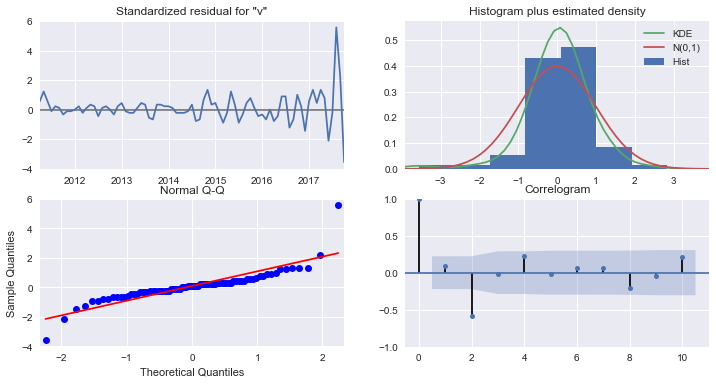

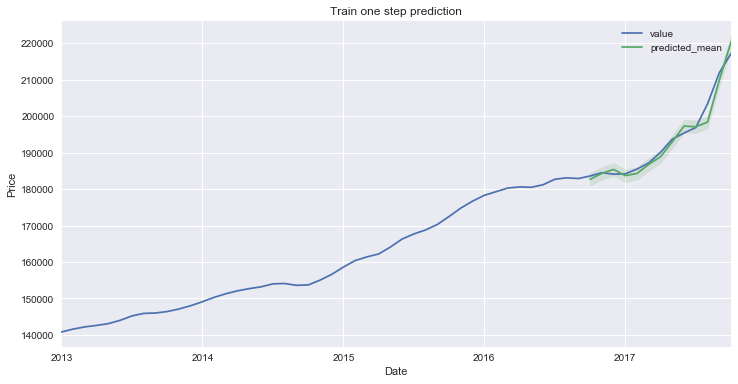

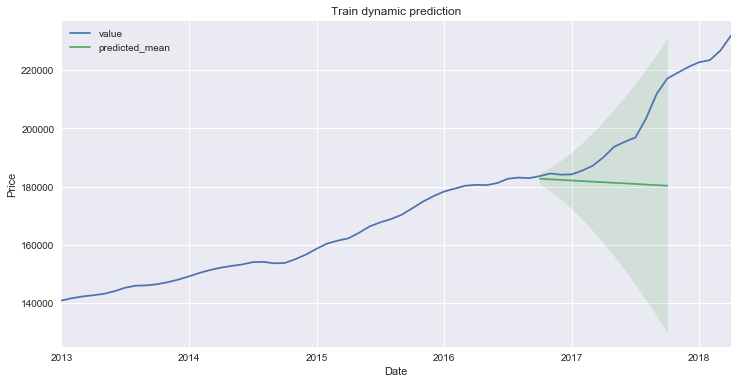

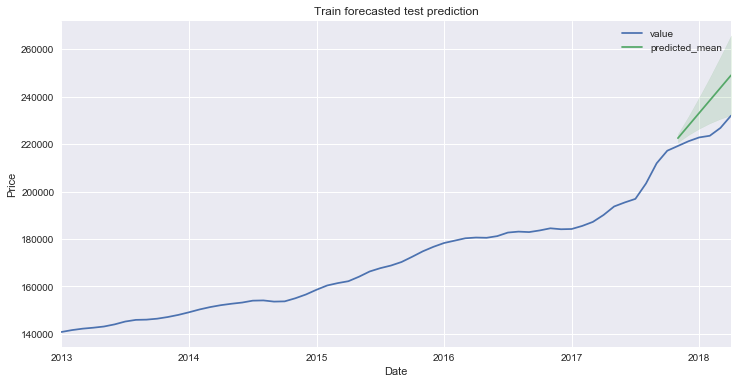

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -708.222
Date:                Tue, 27 Apr 2021   AIC                           1418.443
Time:                        15:58:36   BIC                           1420.886
Sample:                    01-01-2011   HQIC                          1419.426
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.01e+06   6.92e+04     14.590      0.000    8.74e+05    1.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   4.64   Jarque-Bera (JB):               226.75
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              25.56   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

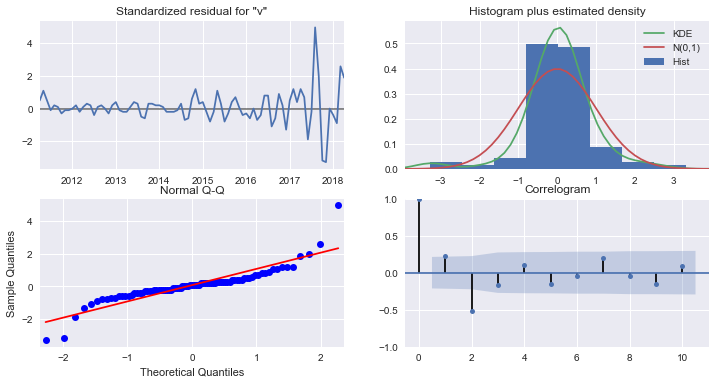

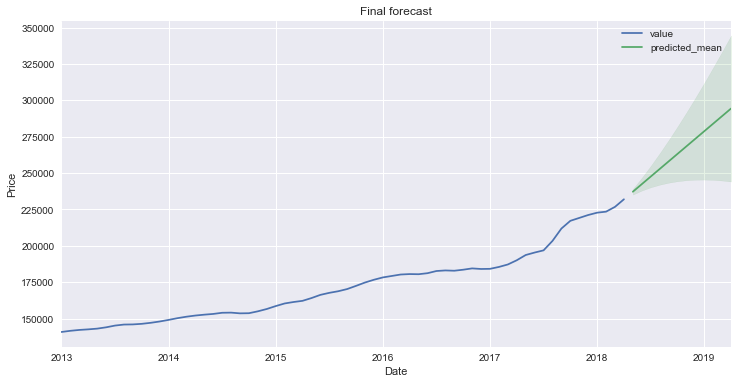

294400.0

In [221]:
# Checking the parameteres selected by auto_arima
Manual_Param_Check(Idaho_25_short_dict['83845'], order=(0,2,0), seasonal_order=(0,0,0,12))

There seems to be some correlation present, going to dive deeper and fine tune the model.

There seems to be some seasonality


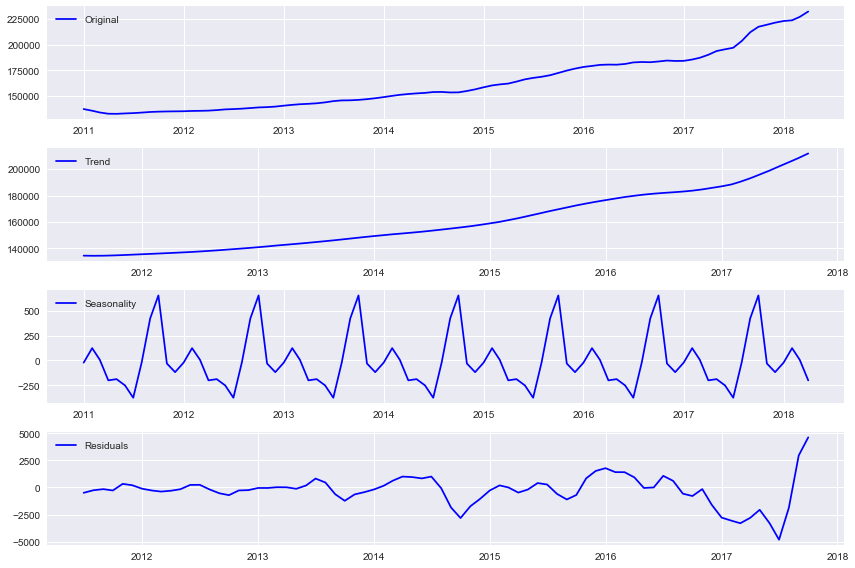

In [222]:
# Checking for seasonality
Seasonal_check(Idaho_25_short_dict['83845'])
print('There seems to be some seasonality')

83845 ACF and PACF


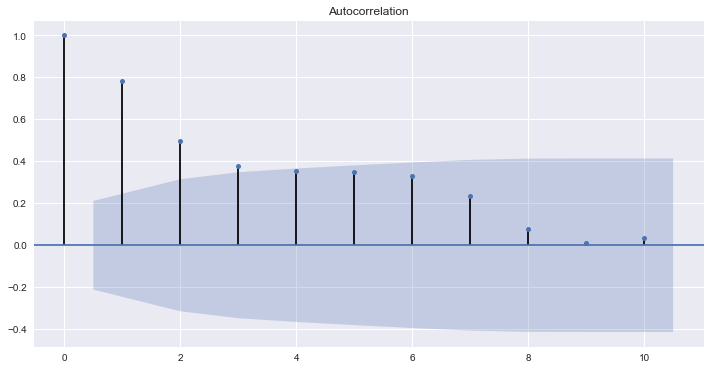

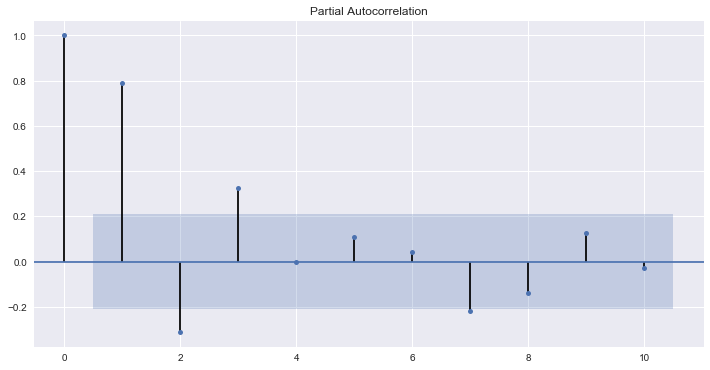

In [223]:
print('83845 ACF and PACF')
xr = Idaho_25_short_dict['83845'].diff(2).dropna()
plot_acf(xr, lags=10);
plot_pacf(xr, lags=10);

Seasonal ACF and PACF


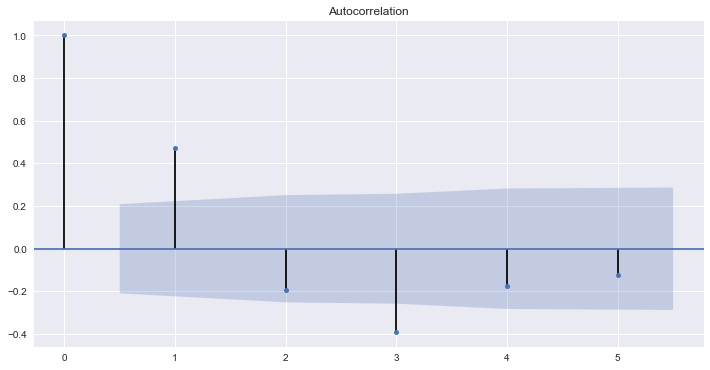

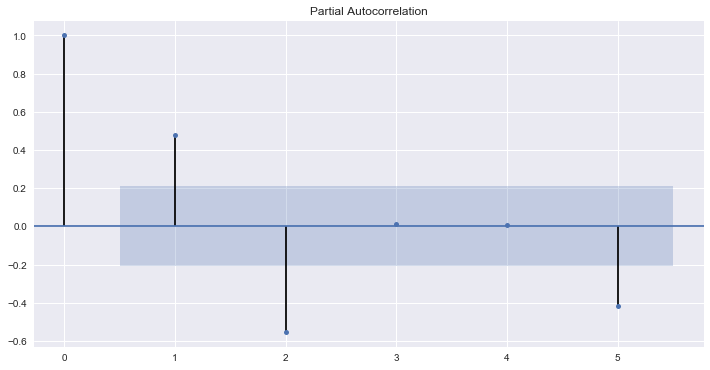

In [224]:
print('Seasonal ACF and PACF')
decomposition = seasonal_decompose(Idaho_25_short_dict['83845'])
season = decomposition.seasonal
plot_acf(season, lags=5);
plot_pacf(season, lags=5);

In [225]:
# Checking possible p,d,q and P,D,Q values
orderlist = [(0,2,0),(1,2,0),(1,2,1),(1,2,2)]
seasonallist = [(0,0,0,12),(1,0,0,12),(2,0,0,12),(1,0,1,12),(2,0,1,12),(0,0,1,12)]
possible_params = Grid_Auto_bot(data=Idaho_25_short_dict['83845'],order_list=orderlist, seasonal_list=seasonallist)

ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1300.587067275117
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =1121.1315638406313
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =934.0037084090587
ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =1110.2746845009483


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =935.1521844444726
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =1111.6279314570372
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1301.6305639987506
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =1105.2673406396427
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =918.0430952358206
ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =1107.2665667248193
ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =920.0230424247225
ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =1113.0846345217406
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1261.9750371515331
ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =1096.0393787714218
ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =904.0135490749972
ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =1074.8145659201625
ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =905.896762061252
ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =1078.7981095699597
ARIMA (1, 2,

In [226]:
# Arranging best parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
possible_params.head()

pdq           pdqs         aic
20  (1, 2, 2)  (2, 0, 0, 12)  895.844474
22  (1, 2, 2)  (2, 0, 1, 12)  900.295298
14  (1, 2, 1)  (2, 0, 0, 12)  904.013549
16  (1, 2, 1)  (2, 0, 1, 12)  905.896762
8   (1, 2, 0)  (2, 0, 0, 12)  918.043095

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   82
Model:             SARIMAX(1, 2, 2)x(2, 0, [], 12)   Log Likelihood                -441.922
Date:                             Tue, 27 Apr 2021   AIC                            895.844
Time:                                     15:58:45   BIC                            907.888
Sample:                                 01-01-2011   HQIC                           900.502
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4539      0.322      1.409      0.159      -0.178       1.086
ma.L1          0.4464      0.292      1.528      0.126      -0.126       1.019
ma.L2         -1.1521      0.354     -3.257      0.001      -1.845      -0.459
ar.S.L12      -0.7753      0.318     -2.442      0.015      -1.398      -0.153
ar.S.L24      -0.0062      0.094     -0.066      0.947      -0.190       0.177
sigma2      3.184e+05   1.14e+05      2.788      0.005    9.45e+04    5.42e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                77.26
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               8.13   Skew:                             1.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

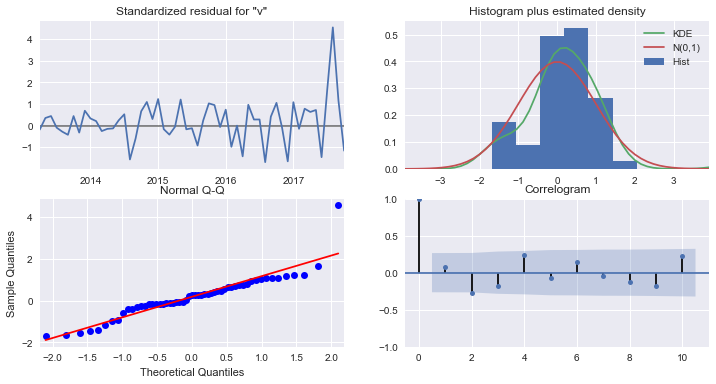

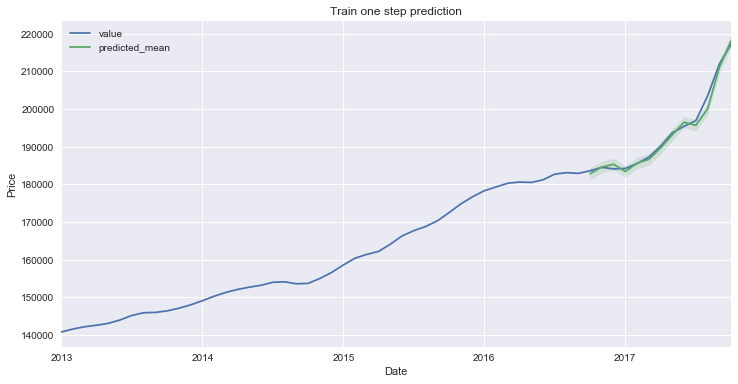

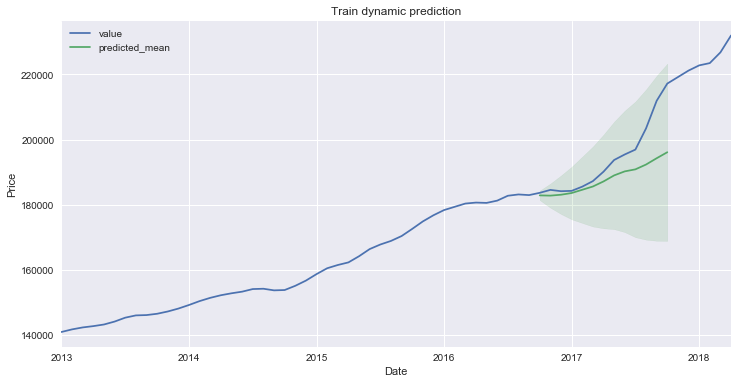

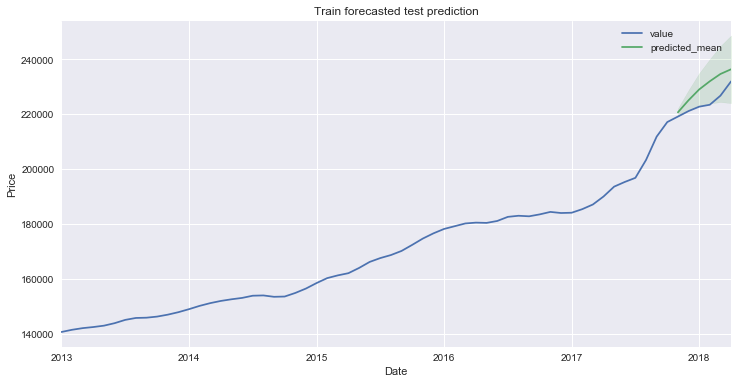

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   88
Model:             SARIMAX(1, 2, 2)x(2, 0, [], 12)   Log Likelihood                -495.745
Date:                             Tue, 27 Apr 2021   AIC                           1003.491
Time:                                     15:58:47   BIC                           1016.156
Sample:                                 01-01-2011   HQIC                          1008.454
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4833      0.189      2.559      0.011       0.113       0.854
ma.L1          0.3307      0.182      1.818      0.069      -0.026       0.687
ma.L2         -1.1136      0.180     -6.173      0.000      -1.467      -0.760
ar.S.L12      -0.4686      0.207     -2.264      0.024      -0.874      -0.063
ar.S.L24      -0.0025      0.085     -0.030      0.976      -0.169       0.164
sigma2       4.37e+05   8.83e+04      4.950      0.000    2.64e+05     6.1e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                73.95
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):              11.20   Skew:                             1.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

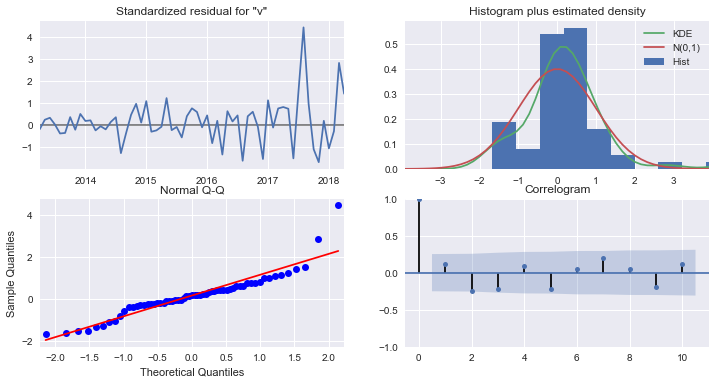

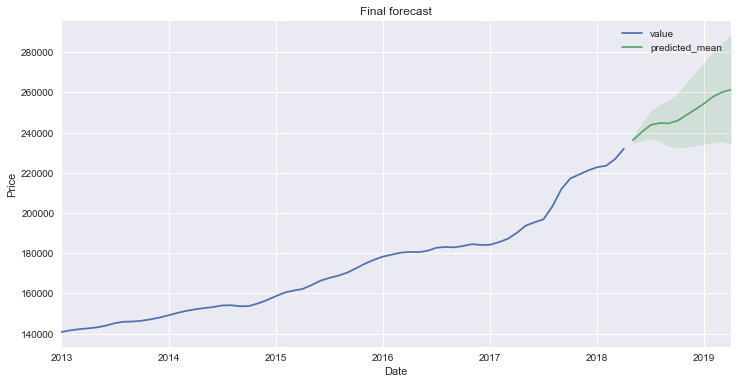

In [227]:
# Running the final zip check with the new parameters

final_model_results = []
final_model_results = Final_zip_Check(
    data=Idaho_25_short_dict['83845'], order=(1, 2, 2), seasonal_order=(2, 0, 0, 12))

# adding zip to the entry
final_model_results.append('83845')

In [228]:
# Creating the new dataframe for the tuned zip codes
Final_model_results_df=pd.DataFrame(pd.Series(final_model_results))
Final_model_results_df=Final_model_results_df.T
Final_model_results_df.columns=['order','seasonal_order','train_mse','train_dyn_mse',
                                'train_forecast_mse','train_forecast_rmse','final_mse',
                                'final_dyn_mse', 'final_dyn_rmse',
                                'last_known_price','1_year_forecast', '1_year_forecast_low',
                                '1_year_forecast_high', 'zip']

### 2nd place: Zipcode 83347

Basic information that was provided in the original data.

In [229]:
data.loc[data['RegionName'] == 83347]

RegionID  RegionName  City State   Metro CountyName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06  2003-07  2003-08  2003-09  2003-10  2003-11  2003-12  2004-01  2004-02  2004-03  2004-04  2004-05  2004-06  2004-07   2004-08   2004-09  \
12663     94134       83347  Paul    ID  Burley   Minidoka     12664  50300.0  50600.0  50900.0  51300.0  51600.0  51900.0  52300.0  52800.0  53400.0  54000.0  54600.0  55200.0  55900.0  56600.0  57300.0  58100.0  58800.0  59600.0  60400.0  61200.0  62200.0  63100.0  64100.0  65000.0  65900.0  66700.0  67600.0  68300.0  69000.0  69700.0  70400.0  71100.0  71800.0  72400.0  73000.0  73500.0  73900.0  74300.0  74600.0  74900.0  75100.0  75300.0  75600.0  75800.0  76100.0  76500.0  77000.0  77400.0  77700.0  78100.0  78400.0  78800.0  79200.0  79600.0  79900.0  80400.0  80900.0  81500.0  82000.0  82600.0  83000.0  83400.0  83800.0  84100.0  84400.0  84600.0  84900.0  85100.0  85400.0  85700.0  86000.0  86200.0  86300.0  86400.0  86500.0  86600.0  86500.0  86500.0  86500.0  86500.0  86600.0  86700.0  86800.0  87000.0  87300.0  87900.0  88800.0  89700.0  90500.0  91100.0  91500.0  91800.0  92100.0  92600.0  93400.0  94500.0  95800.0  97200.0  98600.0  99700.0  100500.0  101200.0   

        2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04  2005-05  2005-06  2005-07  2005-08  2005-09  2005-10  2005-11  2005-12  2006-01  2006-02  2006-03  2006-04  2006-05  2006-06  2006-07  2006-08  2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09  2010-10  2010-11  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  2013-01  2013-02  2013-03   2013-04  \
12663  101600.0  102000.0  102100.0  102100.0  101800.0  101200.0  100600.0  99800.0  98900.0  98100.0  97800.0  97800.0  98100.0  98300.0  98300.0  98200.0  98000.0  98000.0  98000.0  98000.0  98000.0  98200.0  98700.0  99300.0  100000.0  100800.0  101800.0  103000.0  104100.0  105000.0  105600.0  106100.0  106300.0  106400.0  106600.0  106800.0  107100.0  107500.0  108000.0  108300.0  108300.0  108000.0  107700.0  107200.0  106600.0  106300.0  106100.0  105800.0  105600.0  105400.0  105300.0  105500.0  105600.0  105700.0  105900.0  106000.0  105800.0  105400.0  104900.0  104500.0  104100.0  103700.0  103300.0  102700.0  102800.0  102900.0  102400.0  101700.0  101700.0  101600.0  101200.0  100600.0  99900.0  99000.0  97700.0  96500.0  95600.0  94900.0  94300.0  94100.0  94100.0  94000.0  94300.0  94800.0  95000.0  94900.0  94600.0  94400.0  94000.0  93800.0  93900.0  94300.0  94800.0  95500.0  96200.0  96600.0  96800.0  97300.0  98200.0  99000.0  99200.0  99300.0  100000.0   

        2013-05   2013-06   2013-07  

In [230]:
# The information stored from the initial model
results_df_ROI_sorted.iloc[1]

order                           (0, 2, 0)
seasonal_order              (0, 0, 0, 12)
train_mse                          510769
train_dyn_mse                   7.958e+07
train_forecast_mse             1.2295e+07
train_forecast_rmse               3506.42
final_mse                     3.35429e+06
final_dyn_mse                 1.05701e+08
final_dyn_rmse                    10281.1
last_known_price                   162200
1_year_forecast                    195800
1_year_forecast_low                164651
1_year_forecast_high               226949
1_year_forecast_ROI              0.207152
1_year_forecast_variance          62298.5
Name: 83347, dtype: object

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -587.134
Date:                Tue, 27 Apr 2021   AIC                           1176.268
Time:                        15:58:48   BIC                           1178.638
Sample:                    01-01-2011   HQIC                          1177.218
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.669e+05   1.48e+04     11.309      0.000    1.38e+05    1.96e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.33   Jarque-Bera (JB):                88.69
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               3.38   Skew:                            -1.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

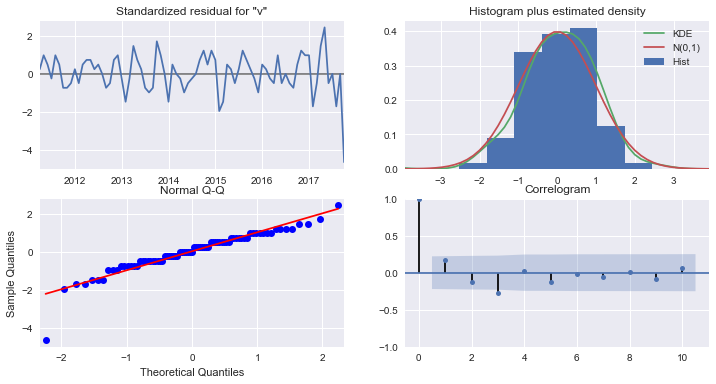

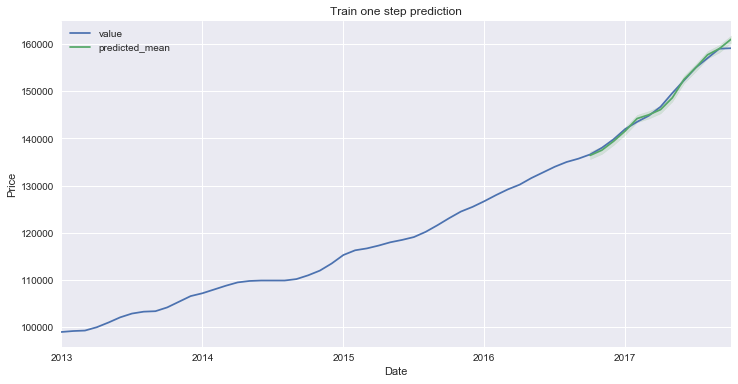

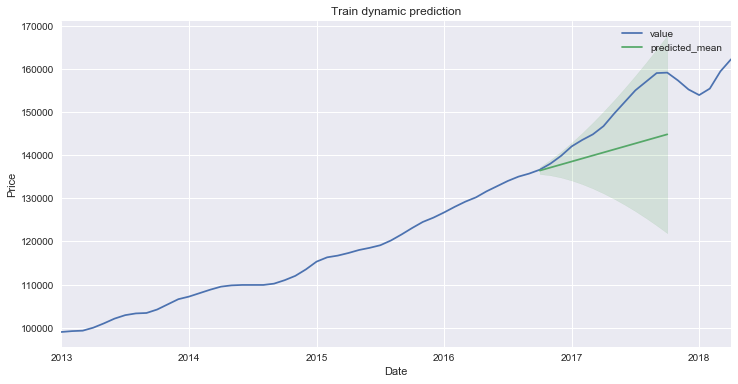

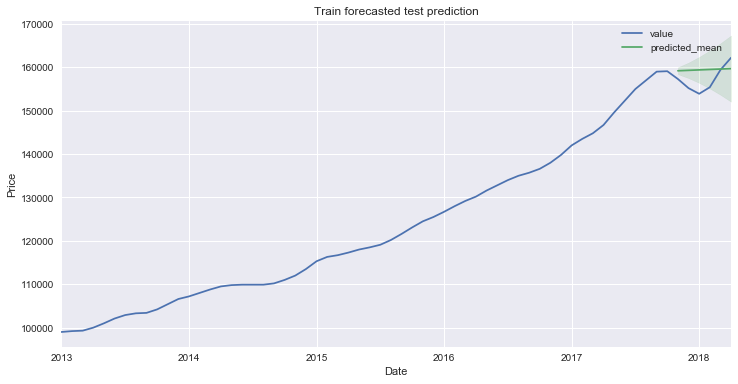

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -667.648
Date:                Tue, 27 Apr 2021   AIC                           1337.296
Time:                        15:58:50   BIC                           1339.739
Sample:                    01-01-2011   HQIC                          1338.278
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.886e+05   2.76e+04     14.074      0.000    3.34e+05    4.43e+05
===================================================================================
Ljung-Box (L1) (Q):                  12.16   Jarque-Bera (JB):               191.75
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              11.87   Skew:                             0.94
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

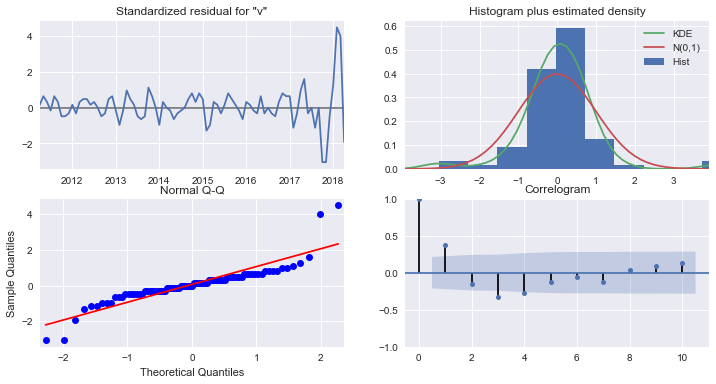

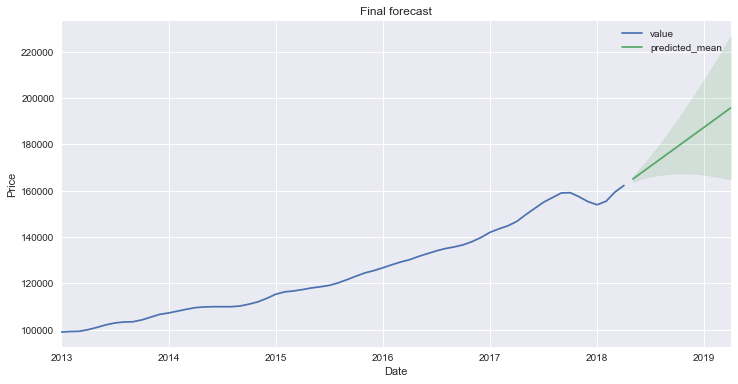

195800.0

In [231]:
# Checking the parameters the auto_arima chose
Manual_Param_Check(Idaho_25_short_dict['83347'], order=(0,2,0), seasonal_order=(0,0,0,12))

There seems to be some correlation, the model can probably be improved, lets look closer

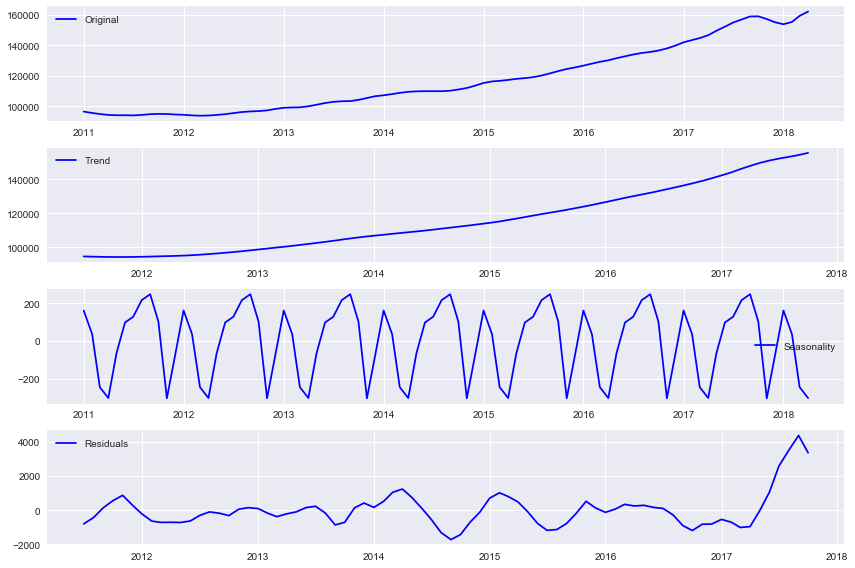

In [232]:
# Looking at the seasonality
Seasonal_check(Idaho_25_short_dict['83347'])

83347 ACF and PACF


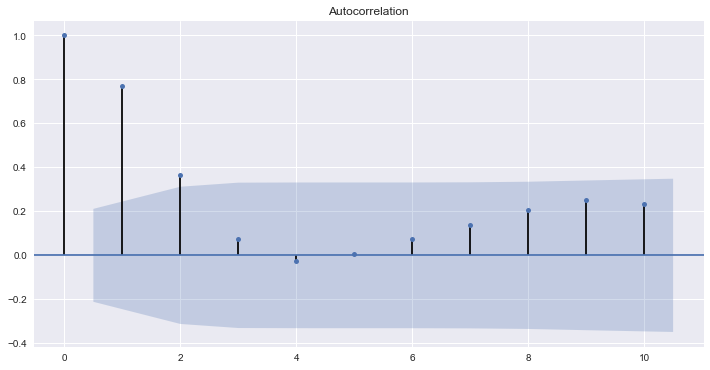

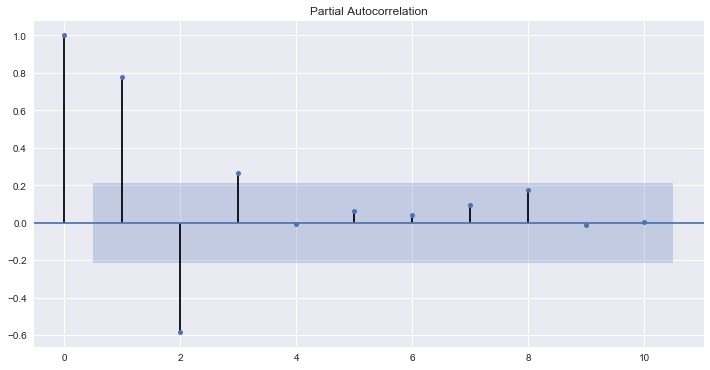

In [233]:
print('83347 ACF and PACF')
xr = Idaho_25_short_dict['83347'].diff(2).dropna()
plot_acf(xr, lags=10);
plot_pacf(xr, lags=10);

Seasonal ACF and PACF


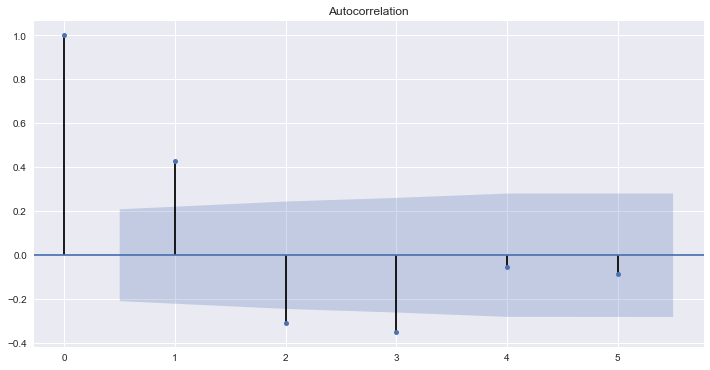

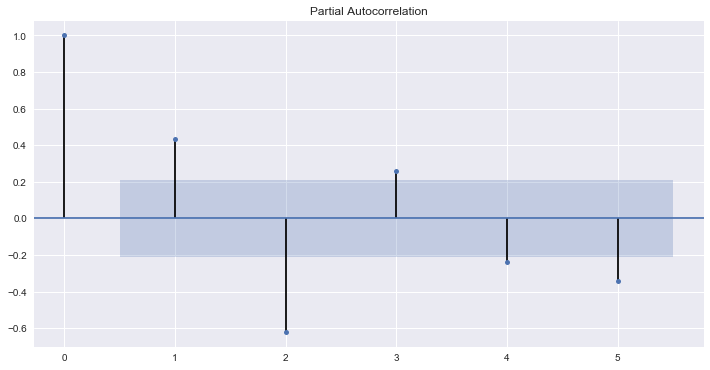

In [234]:
print('Seasonal ACF and PACF')
decomposition = seasonal_decompose(Idaho_25_short_dict['83347'])
season = decomposition.seasonal
plot_acf(season, lags=5);
plot_pacf(season, lags=5);

In [235]:
# Checking possible p,d,q and P,D,Q values
orderlist = [(0,2,0),(1,2,0),(1,2,1),(1,2,2),(2,2,0),(2,2,1)]
seasonallist = [(0,0,0,12),(2,0,0,12),(2,0,1,12)]
possible_params = Grid_Auto_bot(data=Idaho_25_short_dict['83347'],order_list=orderlist, seasonal_list=seasonallist)

ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1176.2684291299533
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =849.6942360216124
ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =850.3017610171584
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1174.9992317990132
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =835.5320546158481
ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =836.5950596053032
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1162.943483995825
ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =837.0285069019908
ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =837.5094862934903
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =1142.6223820324049
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =833.34008018266
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =834.5741618211767
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1160.244987536747
ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =820.953163047408
ARIMA (2, 2, 0) x (2

In [236]:
# Sorting the parameters by best aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
possible_params.head()

pdq           pdqs         aic
16  (2, 2, 1)  (2, 0, 0, 12)  816.164211
17  (2, 2, 1)  (2, 0, 1, 12)  816.690854
13  (2, 2, 0)  (2, 0, 0, 12)  820.953163
14  (2, 2, 0)  (2, 0, 1, 12)  822.216463
10  (1, 2, 2)  (2, 0, 0, 12)  833.340080

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   82
Model:             SARIMAX(2, 2, 1)x(2, 0, [], 12)   Log Likelihood                -402.082
Date:                             Tue, 27 Apr 2021   AIC                            816.164
Time:                                     15:58:57   BIC                            828.098
Sample:                                 01-01-2011   HQIC                           820.767
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0366      0.239      4.332      0.000       0.568       1.506
ar.L2         -0.4249      0.196     -2.168      0.030      -0.809      -0.041
ma.L1         -1.0821      0.095    -11.412      0.000      -1.268      -0.896
ar.S.L12      -0.0318      0.308     -0.103      0.918      -0.636       0.573
ar.S.L24       0.0750      0.234      0.320      0.749      -0.384       0.534
sigma2      1.493e+05   2.01e+04      7.409      0.000     1.1e+05    1.89e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.30   Jarque-Bera (JB):                83.22
Prob(Q):                              0.58   Prob(JB):                         0.00
Heteroskedasticity (H):               4.63   Skew:                            -1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

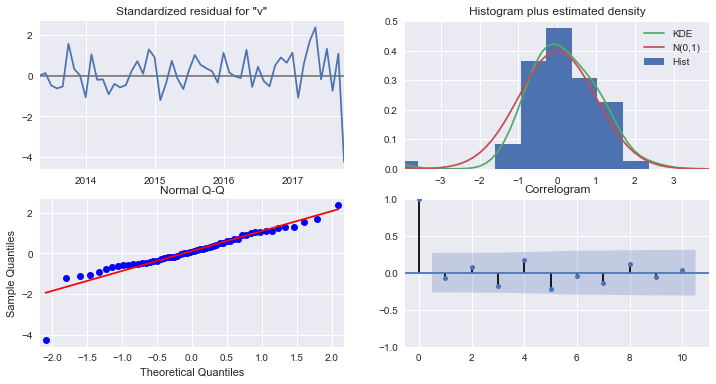

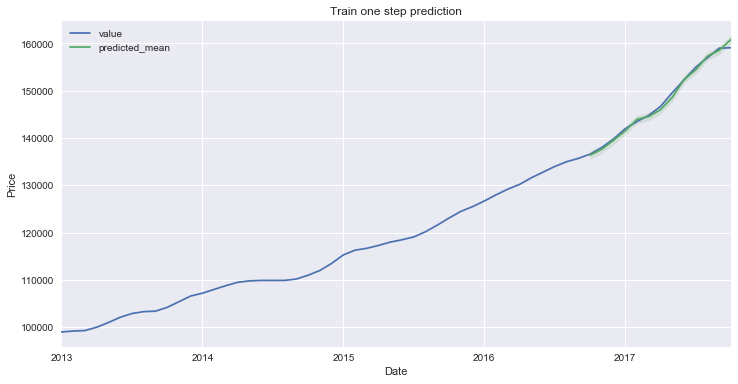

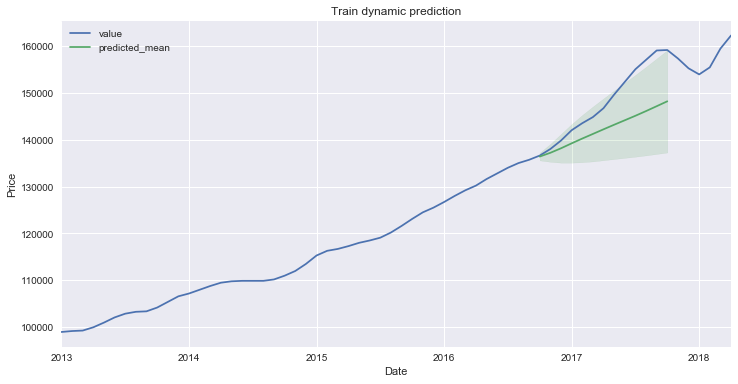

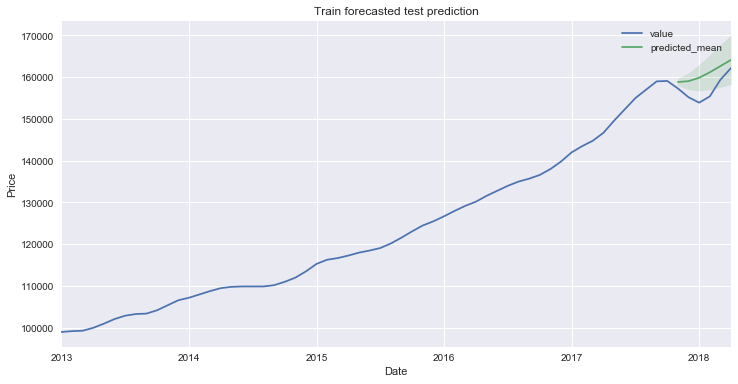

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   88
Model:             SARIMAX(2, 2, 1)x(2, 0, [], 12)   Log Likelihood                -458.762
Date:                             Tue, 27 Apr 2021   AIC                            929.524
Time:                                     15:58:59   BIC                            942.090
Sample:                                 01-01-2011   HQIC                           934.439
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2286      0.063     19.443      0.000       1.105       1.352
ar.L2         -0.7443      0.081     -9.182      0.000      -0.903      -0.585
ma.L1         -0.8862      0.055    -16.170      0.000      -0.994      -0.779
ar.S.L12      -0.3966      0.212     -1.867      0.062      -0.813       0.020
ar.S.L24      -0.0301      0.178     -0.169      0.866      -0.379       0.319
sigma2      2.412e+05   3.83e+04      6.301      0.000    1.66e+05    3.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                17.04
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               6.67   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

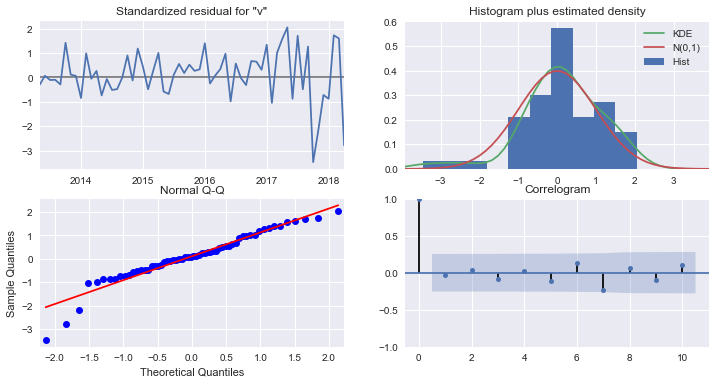

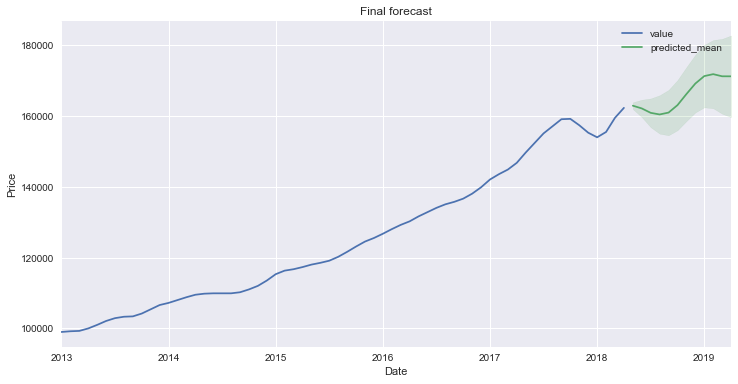

In [237]:
# Running the final zip check with the new parameters

final_model_results = []
final_model_results = Final_zip_Check(
    data=Idaho_25_short_dict['83347'], order=(2, 2, 1), seasonal_order=(2, 0, 0, 12))

# adding zip to the entry
final_model_results.append('83347')

In [238]:
# Adding the results to the new dataframe
Final_model_results_df = Final_model_results_df.append(
    pd.Series(final_model_results, index=Final_model_results_df.columns), ignore_index=True)

In [239]:
# Checking to make sure results were added
Final_model_results_df

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high    zip
0  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345  83845
1  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618  83347

### 3rd place: Zipcode 83350

Basic information that was provided in the original data.

In [240]:
# Information from original data
data.loc[data['RegionName'] == 83350]

RegionID  RegionName    City State   Metro CountyName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05  1998-06  1998-07  1998-08  1998-09  1998-10  1998-11  1998-12  1999-01  1999-02  1999-03  1999-04  1999-05  1999-06  1999-07  1999-08  1999-09  1999-10  1999-11  1999-12  2000-01  2000-02  2000-03  2000-04  2000-05  2000-06  2000-07  2000-08  2000-09  2000-10  2000-11  2000-12  2001-01  2001-02  2001-03  2001-04  2001-05  2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06  2003-07  2003-08  2003-09  2003-10  2003-11  2003-12  2004-01  2004-02  2004-03  2004-04  2004-05  2004-06  2004-07  2004-08  2004-09  2004-10  \
7937     94137       83350  Rupert    ID  Burley   Minidoka      7938  46700.0  46800.0  46900.0  47100.0  47200.0  47400.0  47700.0  48000.0  48300.0  48700.0  49200.0  49700.0  50200.0  50800.0  51400.0  52000.0  52600.0  53200.0  53900.0  54600.0  55400.0  56300.0  57100.0  57900.0  58800.0  59700.0  60600.0  61400.0  62200.0  62900.0  63700.0  64300.0  65000.0  65700.0  66300.0  66800.0  67200.0  67500.0  67700.0  67800.0  67900.0  67900.0  67900.0  67900.0  68000.0  68100.0  68400.0  68700.0  69000.0  69300.0  69600.0  69900.0  70200.0  70500.0  70900.0  71300.0  71700.0  72200.0  72700.0  73300.0  74000.0  74600.0  75200.0  75600.0  75900.0  76300.0  76700.0  77000.0  77300.0  77500.0  77900.0  78300.0  78700.0  79100.0  79400.0  79500.0  79700.0  79800.0  80000.0  80200.0  80500.0  80600.0  80600.0  80700.0  81000.0  81600.0  82500.0  83400.0  84200.0  84700.0  85000.0  85200.0  85400.0  85900.0  86600.0  87800.0  89100.0  90400.0  91500.0  92300.0  92800.0  93200.0  93500.0   

      2004-11  2004-12  2005-01  2005-02  2005-03  2005-04  2005-05  2005-06  2005-07  2005-08  2005-09  2005-10  2005-11  2005-12  2006-01  2006-02  2006-03  2006-04  2006-05  2006-06  2006-07  2006-08  2006-09  2006-10  2006-11  2006-12  2007-01  2007-02  2007-03  2007-04  2007-05  2007-06  2007-07  2007-08  2007-09  2007-10  2007-11  2007-12  2008-01  2008-02  2008-03  2008-04  2008-05  2008-06  2008-07  2008-08  2008-09  2008-10  2008-11  2008-12  2009-01  2009-02  2009-03  2009-04  2009-05  2009-06  2009-07  2009-08  2009-09  2009-10  2009-11  2009-12  2010-01  2010-02  2010-03  2010-04  2010-05  2010-06  2010-07  2010-08  2010-09  2010-10  2010-11  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  2012-11  2012-12  2013-01  2013-02  2013-03  2013-04  2013-05  2013-06  2013-07  2013-08  2013-09  2013-10  2013-11  2013-12  \
7937  93800.0  93900.0  93800.0  92800.0  90700.0  87700.0  84700.0  82200.0  80600.0  79700.0  79400.0  79400.0  79600.0  79900.0  80300.0  80900.0  81800.0  83100.0  84400.0  85500.0  86400.0  87100.0  87500.0  87900.0  88100.0  88200.0  88400.0  88600.0  89000.0  89500.0  89900.0  90100.0  90300.0  90400.0  90400.0  90300.0  90300.0  90300.0  90100.0  89700.0  89300.0  89000.0  88400.0  87900.0  87500.0  87300.0  87000.0  86700.0  86500.0  86300.0  86200.0  86100.0  86100.0  86100.0  86000.0  85700.0  85200.0  84600.0  84200.0  83800.0  83500.0  83400.0  83400.0  83400.0  83300.0  83000.0  82700.0  82500.0  82000.0  81200.0  80400.0  79600.0  78800.0  77700.0  76700.0  75800.0  75100.0  74500.0  74500.0  74600.0  74900.0  75300.0  75800.0  76200.0  76100.0  76100.0  76400.0  76400.0  76200.0  76400.0  77000.0  77600.0  77900.0  78300.0  78800.0  79700.0  80700.0  81500.0  82000.0  82700.0  83500.0  84200.0  84600.0  85100.0  85700.0  86300.0  86800.0  87100.0  87400.0  87900.0   

      20

In [241]:
# Results from the intial model
results_df_ROI_sorted.iloc[2]

order                           (0, 2, 0)
seasonal_order              (0, 0, 0, 12)
train_mse                         82307.7
train_dyn_mse                 4.48169e+07
train_forecast_mse                 728333
train_forecast_rmse               853.424
final_mse                          324286
final_dyn_mse                      650000
final_dyn_rmse                    806.226
last_known_price                   138200
1_year_forecast                    165800
1_year_forecast_low                150192
1_year_forecast_high               181408
1_year_forecast_ROI              0.199711
1_year_forecast_variance          31216.2
Name: 83350, dtype: object

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -556.253
Date:                Tue, 27 Apr 2021   AIC                           1114.505
Time:                        15:59:00   BIC                           1116.875
Sample:                    01-01-2011   HQIC                          1115.454
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.639e+04   1.26e+04      6.044      0.000    5.16e+04    1.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.50   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.22   Prob(JB):                         0.94
Heteroskedasticity (H):               1.46   Skew:                            -0.07
Prob(H) (two-sided):                  0.34   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

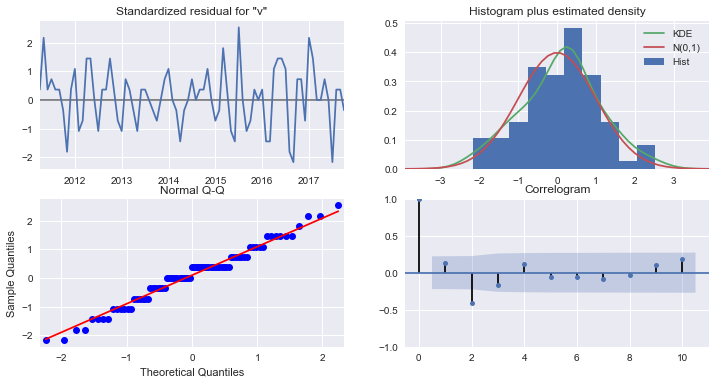

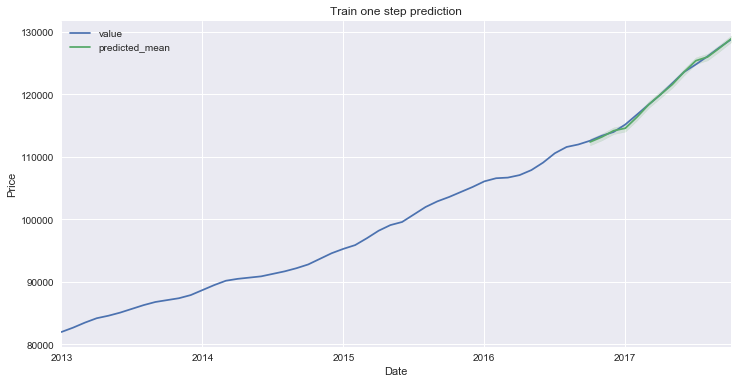

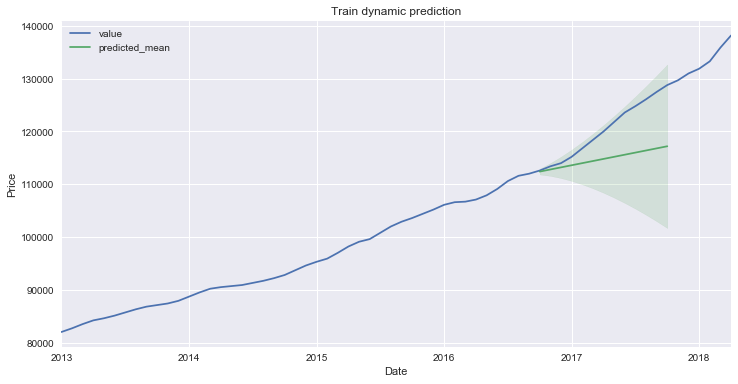

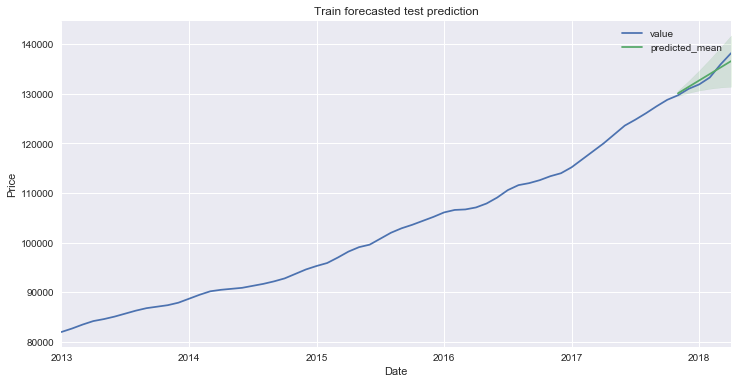

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -608.897
Date:                Tue, 27 Apr 2021   AIC                           1219.794
Time:                        15:59:02   BIC                           1222.237
Sample:                    01-01-2011   HQIC                          1220.777
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.756e+04   1.15e+04      8.460      0.000     7.5e+04     1.2e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 8.22
Prob(Q):                              0.56   Prob(JB):                         0.02
Heteroskedasticity (H):               2.61   Skew:                             0.48
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

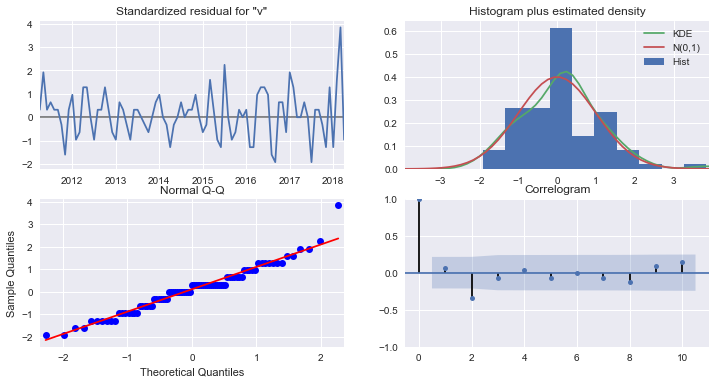

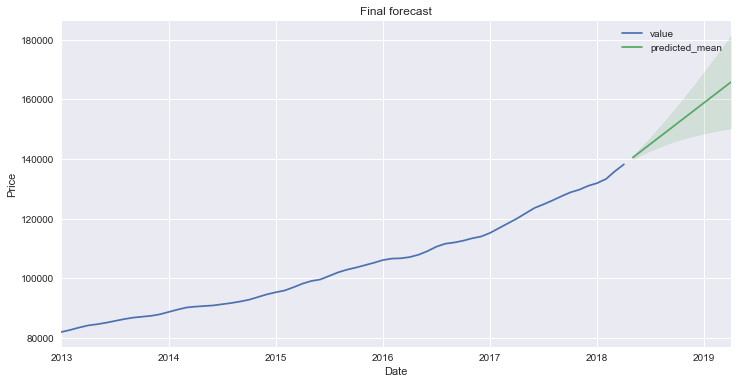

165800.0

In [242]:
# Checking the parameters chosen by auto_arima
Manual_Param_Check(Idaho_25_short_dict['83350'], order=(0,2,0), seasonal_order=(0,0,0,12))

The model can probably be fine tuned, there seems to be some correlation in the residuals.

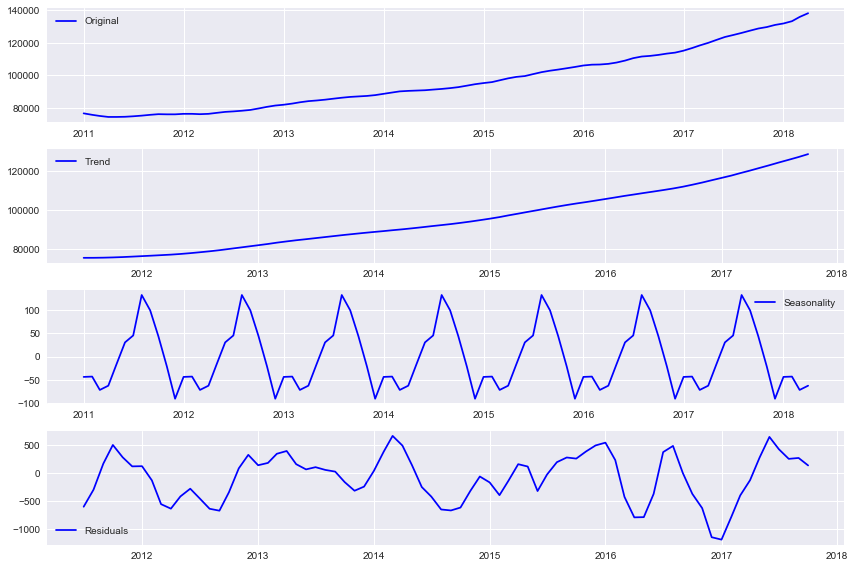

In [243]:
# Checking the seasonality
Seasonal_check(Idaho_25_short_dict['83350'])

83350 ACF and PACF


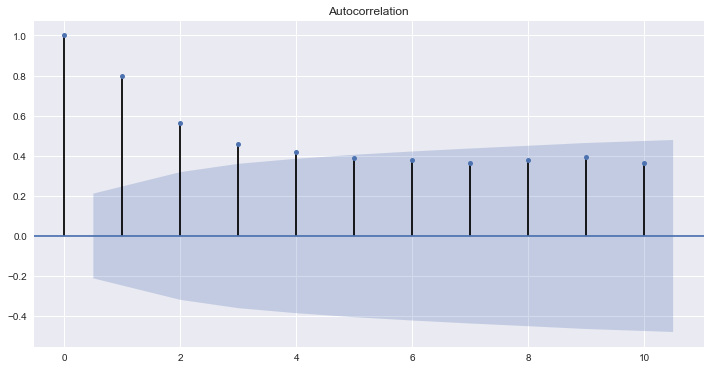

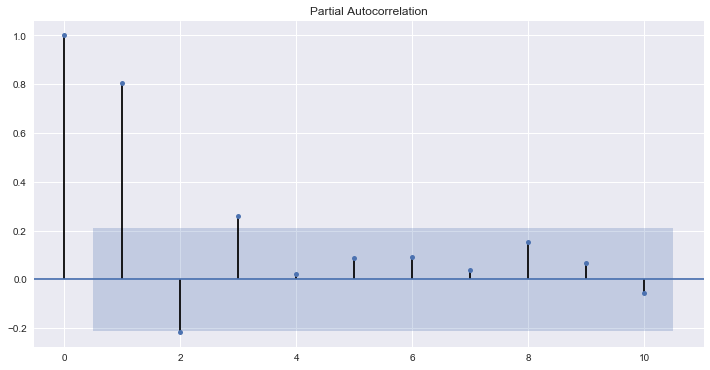

In [244]:
print('83350 ACF and PACF')
xr = Idaho_25_short_dict['83350'].diff(2).dropna()
plot_acf(xr, lags=10);
plot_pacf(xr, lags=10);

Seasonal ACF and PACF


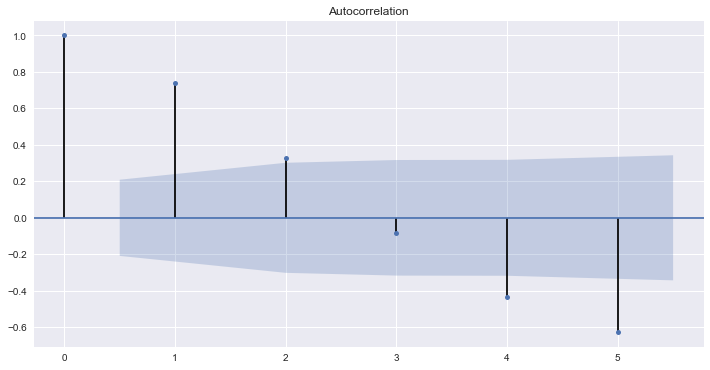

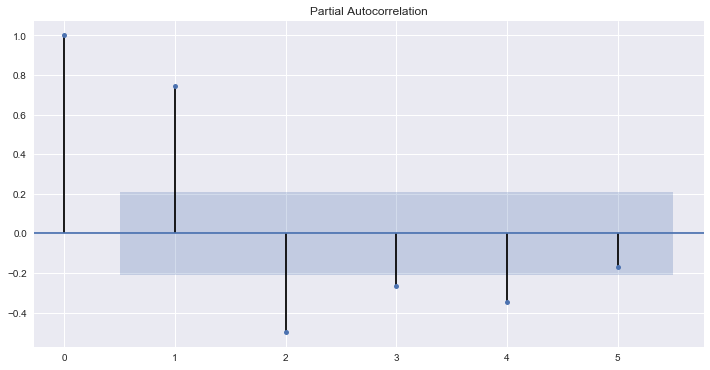

In [245]:
print('Seasonal ACF and PACF')
decomposition = seasonal_decompose(Idaho_25_short_dict['83350'])
season = decomposition.seasonal
plot_acf(season, lags=5);
plot_pacf(season, lags=5);

In [246]:
# Checking possible parameters
orderlist = [(0,2,0),(1,2,0),(1,2,1),(1,2,2),(2,2,0),(2,2,1)]
seasonallist = [(0,0,0,12),(1,0,0,12),(0,0,1,12),(1,0,1,12),(1,0,2,12),(2,0,0,12),(2,0,1,12)]
possible_params = Grid_Auto_bot(data=Idaho_25_short_dict['83350'],order_list=orderlist, seasonal_list=seasonallist)

ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1114.5051886426286
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =959.1301065990956
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =944.011546892257
ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =945.9830820785417
ARIMA (0, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2297.753590364704
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =791.7562105706188
ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =793.5849662579903
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1114.8186279366876
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =946.6755981315898
ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =945.189569389199
ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =947.1883399217608


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2292.027412838548
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =779.8748471044864
ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =781.8561494076762
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1093.6358321399696
ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =943.7957249176139
ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =928.399250271492
ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =929.9331928028229


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =1874.0988936971623
ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =778.5522338292767
ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =780.5468764366983
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =1070.1674035465658
ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =932.2468082570562
ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =905.705714455075
ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =907.1841156648776


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =2088.6913436827317
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =773.1408641984569
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =774.4811170655572
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1089.1913429395322
ARIMA (2, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =918.7780431853425
ARIMA (2, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =931.9585561726184
ARIMA (2, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =920.7048625729758


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2039.4393394064004
ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =755.6082742940769
ARIMA (2, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =756.4475926580695
ARIMA (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1083.6405420048086
ARIMA (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =917.8826380576631
ARIMA (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =919.491773195353
ARIMA (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =919.836088601755


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =2229.1907096594273
ARIMA (2, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =757.583883553063
ARIMA (2, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =758.4629049049621


In [247]:
# Sorting the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
possible_params.head()

pdq           pdqs         aic
33  (2, 2, 0)  (2, 0, 0, 12)  755.608274
34  (2, 2, 0)  (2, 0, 1, 12)  756.447593
40  (2, 2, 1)  (2, 0, 0, 12)  757.583884
41  (2, 2, 1)  (2, 0, 1, 12)  758.462905
26  (1, 2, 2)  (2, 0, 0, 12)  773.140864

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   82
Model:             SARIMAX(2, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -372.804
Date:                            Tue, 27 Apr 2021   AIC                            755.608
Time:                                    15:59:16   BIC                            765.553
Sample:                                01-01-2011   HQIC                           759.444
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2604      0.115      2.271      0.023       0.036       0.485
ar.L2         -0.5088      0.118     -4.294      0.000      -0.741      -0.277
ar.S.L12       0.0181      0.148      0.123      0.902      -0.271       0.307
ar.S.L24      -0.3408      0.188     -1.816      0.069      -0.709       0.027
sigma2      5.809e+04   1.16e+04      5.004      0.000    3.53e+04    8.08e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.63
Prob(Q):                              0.72   Prob(JB):                         0.16
Heteroskedasticity (H):               3.98   Skew:                             0.60
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

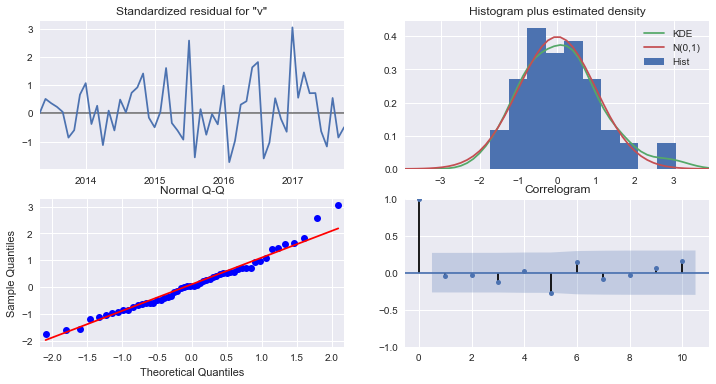

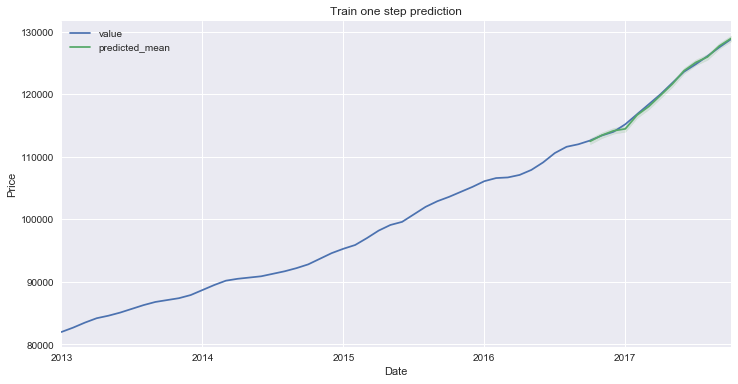

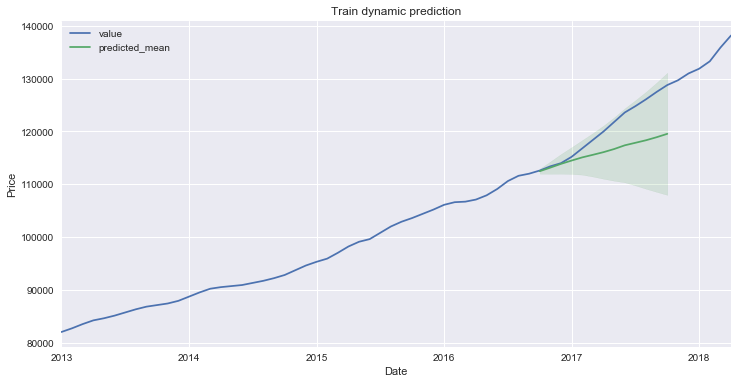

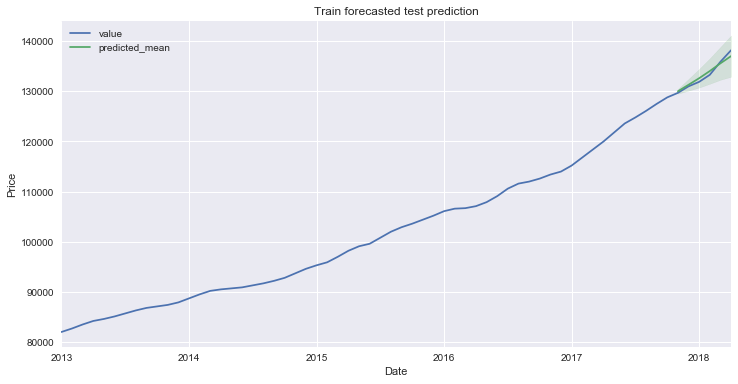

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                   88
Model:             SARIMAX(2, 2, 0)x(2, 0, 0, 12)   Log Likelihood                -423.678
Date:                            Tue, 27 Apr 2021   AIC                            857.356
Time:                                    15:59:17   BIC                            867.828
Sample:                                01-01-2011   HQIC                           861.452
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1744      0.116      1.500      0.134      -0.053       0.402
ar.L2         -0.4827      0.119     -4.061      0.000      -0.716      -0.250
ar.S.L12      -0.0803      0.132     -0.607      0.544      -0.339       0.179
ar.S.L24      -0.5236      0.190     -2.755      0.006      -0.896      -0.151
sigma2       7.96e+04   1.59e+04      4.995      0.000    4.84e+04    1.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 3.02
Prob(Q):                              0.71   Prob(JB):                         0.22
Heteroskedasticity (H):               4.04   Skew:                             0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

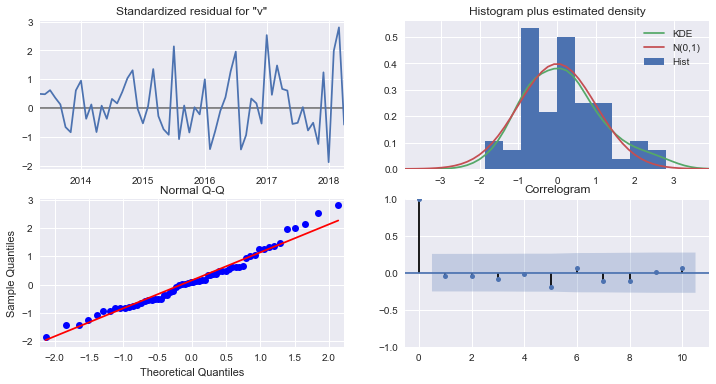

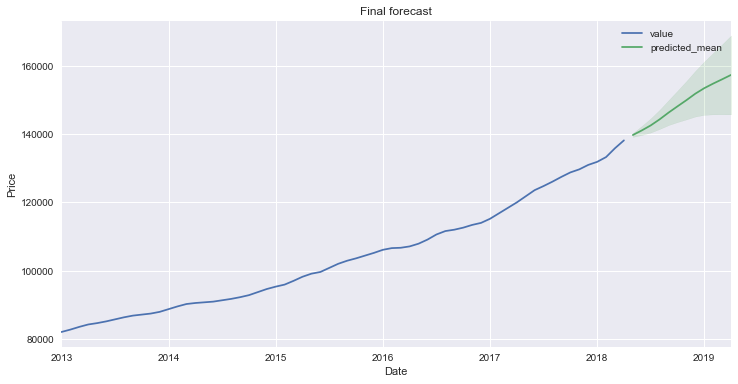

In [248]:
# Running the final zip check with the new parameters

final_model_results = []
final_model_results = Final_zip_Check(
    data=Idaho_25_short_dict['83350'], order=(2, 2, 0), seasonal_order=(2, 0, 0, 12))

# adding zip to the entry
final_model_results.append('83350')

In [249]:
# Adding results to the final dataframe
Final_model_results_df = Final_model_results_df.append(
    pd.Series(final_model_results, index=Final_model_results_df.columns), ignore_index=True)

In [250]:
# Checking to make sure results were added
Final_model_results_df

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high    zip
0  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345  83845
1  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618  83347
2  (2, 2, 0)  (2, 0, 0, 12)      73959.5   2.76408e+07             459282             677.703       215060        699863        836.578           138200          157404              145833               168974  83350

### 4th place: Zipcode 83858

Basic information that was provided in the original data.

In [251]:
# Basic information from original data
data.loc[data['RegionName'] == 83858]

RegionID  RegionName      City State          Metro CountyName  SizeRank   1996-04   1996-05   1996-06   1996-07   1996-08   1996-09   1996-10   1996-11   1996-12   1997-01   1997-02   1997-03   1997-04   1997-05   1997-06   1997-07   1997-08   1997-09   1997-10   1997-11   1997-12   1998-01   1998-02   1998-03   1998-04   1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06   2001-07   2001-08   2001-09   2001-10   2001-11   2001-12   2002-01   2002-02   2002-03   2002-04   2002-05   2002-06   2002-07   2002-08   2002-09   2002-10   2002-11   2002-12   2003-01   2003-02   2003-03   2003-04   2003-05   2003-06   2003-07   2003-08   2003-09   2003-10  \
6706     94356       83858  Rathdrum    ID  Coeur d'Alene   Kootenai      6707  104600.0  104600.0  104700.0  104900.0  105100.0  105500.0  106100.0  107000.0  107900.0  109000.0  110300.0  111700.0  113300.0  114800.0  116300.0  117700.0  119000.0  120200.0  121200.0  122200.0  123000.0  123600.0  124100.0  124700.0  125200.0  125600.0  126000.0  126400.0  126700.0  127100.0  127500.0  128000.0  128400.0  128700.0  129100.0  129500.0  129800.0  130000.0  130200.0  130300.0  130500.0  130600.0  130700.0  131000.0  131200.0  131400.0  131700.0  132000.0  132400.0  132700.0  133100.0  133300.0  133700.0  134000.0  134400.0  134700.0  135000.0  135200.0  135300.0  135400.0  135300.0  135200.0  134900.0  134500.0  134100.0  133700.0  133400.0  133100.0  132900.0  132700.0  132600.0  132500.0  132400.0  132400.0  132300.0  132400.0  132500.0  132700.0  133100.0  133600.0  134300.0  135300.0  136300.0  136900.0  137400.0  137700.0  138000.0  138000.0  137900.0  137800.0  137500.0   

       2003-11   2003-12   2004-01   2004-02   2004-03   2004-04   2004-05   2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05   2006-06   2006-07   2006-08   2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09   2010-10   2010-11   2010-12   2011-01   2011-02   2011-03   2011-04   2011-05   2011-06   2011-07   2011-08   2011-09   2011-10   2011-11   2011-12   2012-01  \
6706  137000.0  136200.0  135600.0  135500.0  136000.0  136900.0  138200.0  139500.0  141100.0  142800.0  144600.0  146600.0  148900.0  151600.0  154200.0  156700.0  159100.0  161600.0  164600.0  168300.0  172400.0  176600.0  180600.0  184300.0  187700.0  190800.0  193700.0  196900.0  200600.0  204800.0  209000.0  213100.0  216900.0  220000.0  222300.0  223600.0  224600.0  225400.0  225900.0  226400.0  226600.0  226200.0  225300.0  224700.0  224100.0  223800.0  223800.0  224400.0  225700.0  227900.0  230300.0  232600.0  233900.0  233400.0  231400.0  229800.0  228500.0  227500.0  226100.0  224400.0  222500.0  221300.0  220300.0  220000.0  220000.0  219500.0  218600.0  218100.0  217100.0  215600.0  213300.0  210700.0  208000.0  206400.0  205600.0  205900.0  207300.0  207600.0  205600.0  202600.0  200200.0  198000.0  198100.0  200500.0  201800.0  201300.0  203000.0  199900.0  191900.0  188400.0  190400.0  188900.0  187100.0  187300.0  187000.0  183800.0  183000.0  182100.0  178700.0   

       2012-02   2012-03

In [252]:
# Results from the intial model
results_df_ROI_sorted.iloc[3]

order                           (4, 2, 0)
seasonal_order              (1, 0, 1, 12)
train_mse                          645798
train_dyn_mse                 5.80807e+08
train_forecast_mse            1.29773e+07
train_forecast_rmse                3602.4
final_mse                       1.258e+06
final_dyn_mse                 1.62194e+07
final_dyn_rmse                    4027.33
last_known_price                   273000
1_year_forecast                    325746
1_year_forecast_low                287023
1_year_forecast_high               364470
1_year_forecast_ROI               0.19321
1_year_forecast_variance          77446.8
Name: 83858, dtype: object

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -513.261
Date:                              Tue, 27 Apr 2021   AIC                           1040.522
Time:                                      15:59:19   BIC                           1055.635
Sample:                                  01-01-2011   HQIC                          1046.476
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6663      0.133      5.020      0.000       0.406       0.926
ar.L2         -0.6834      0.148     -4.617      0.000      -0.974      -0.393
ar.L3          0.1922      0.152      1.260      0.208      -0.107       0.491
ar.L4         -0.0142      0.120     -0.119      0.905      -0.249       0.220
ar.S.L12      -0.1919      0.101     -1.895      0.058      -0.391       0.007
ma.S.L12       0.4214      0.227      1.854      0.064      -0.024       0.867
sigma2      5.217e+05   1.04e+05      5.030      0.000    3.18e+05    7.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.99   Prob(JB):                         0.79
Heteroskedasticity (H):               1.48   Skew:                            -0.19
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

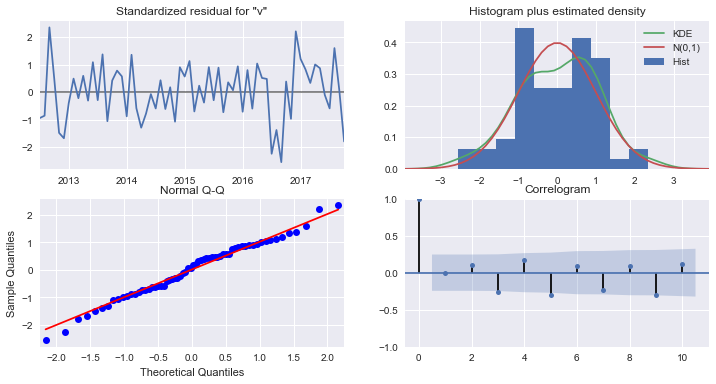

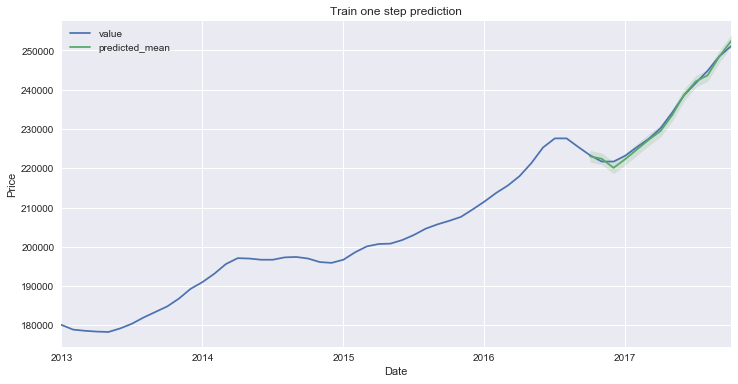

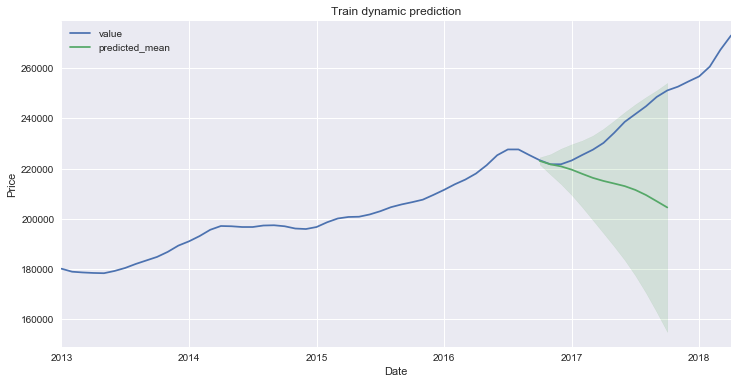

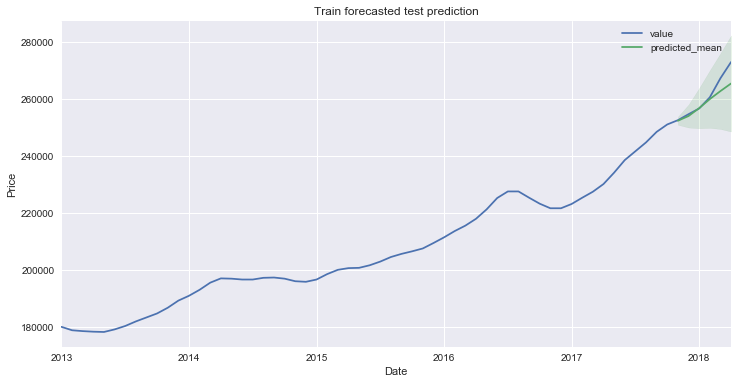

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -566.499
Date:                              Tue, 27 Apr 2021   AIC                           1146.998
Time:                                      15:59:21   BIC                           1162.737
Sample:                                  01-01-2011   HQIC                          1153.250
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6554      0.107      6.131      0.000       0.446       0.865
ar.L2         -0.8841      0.134     -6.603      0.000      -1.146      -0.622
ar.L3          0.4632      0.125      3.707      0.000       0.218       0.708
ar.L4         -0.3828      0.117     -3.274      0.001      -0.612      -0.154
ar.S.L12       0.2353      0.136      1.737      0.082      -0.030       0.501
ma.S.L12       0.0970      0.157      0.617      0.537      -0.211       0.405
sigma2      6.149e+05   1.12e+05      5.471      0.000    3.95e+05    8.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.72   Prob(JB):                         0.98
Heteroskedasticity (H):               1.78   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

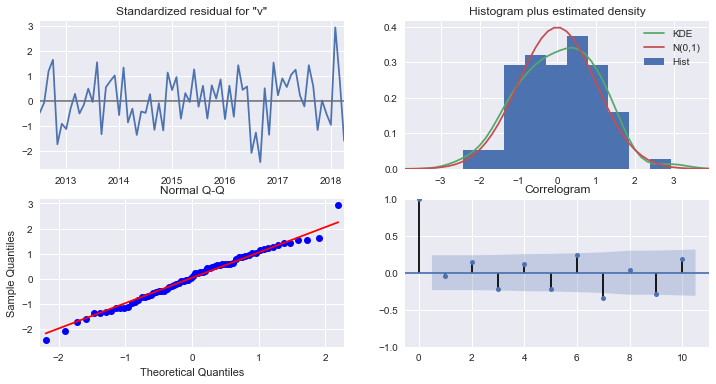

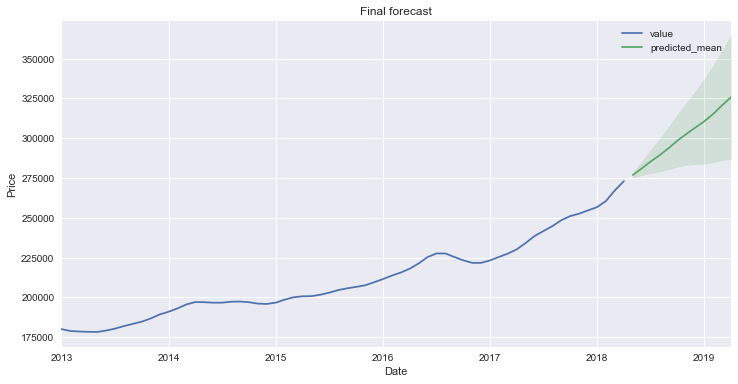

325746.27537345514

In [253]:
Manual_Param_Check(Idaho_25_short_dict['83858'], order=(4,2,0), seasonal_order=(1,0,1,12))

I agree with the initial parameters, there seems to be no residual correlation. Going to run through the final zip check to add it in the dataframe.

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   82
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -513.261
Date:                              Tue, 27 Apr 2021   AIC                           1040.522
Time:                                      15:59:22   BIC                           1055.635
Sample:                                  01-01-2011   HQIC                          1046.476
                                       - 10-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6663      0.133      5.020      0.000       0.406       0.926
ar.L2         -0.6834      0.148     -4.617      0.000      -0.974      -0.393
ar.L3          0.1922      0.152      1.260      0.208      -0.107       0.491
ar.L4         -0.0142      0.120     -0.119      0.905      -0.249       0.220
ar.S.L12      -0.1919      0.101     -1.895      0.058      -0.391       0.007
ma.S.L12       0.4214      0.227      1.854      0.064      -0.024       0.867
sigma2      5.217e+05   1.04e+05      5.030      0.000    3.18e+05    7.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.47
Prob(Q):                              0.99   Prob(JB):                         0.79
Heteroskedasticity (H):               1.48   Skew:                            -0.19
Prob(H) (two-sided):                  0.37   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

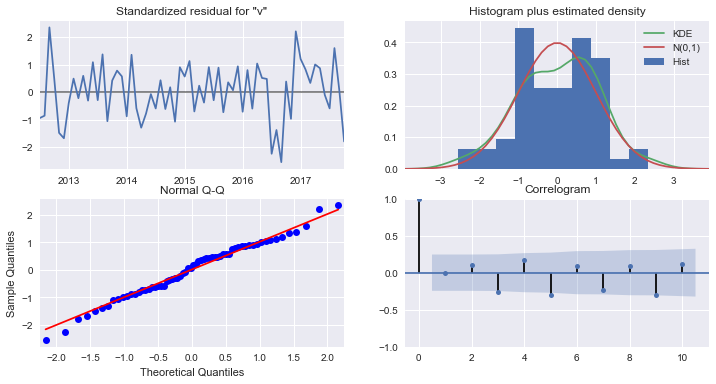

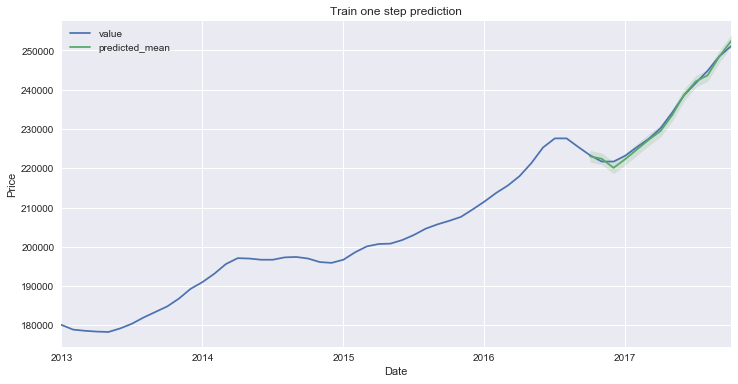

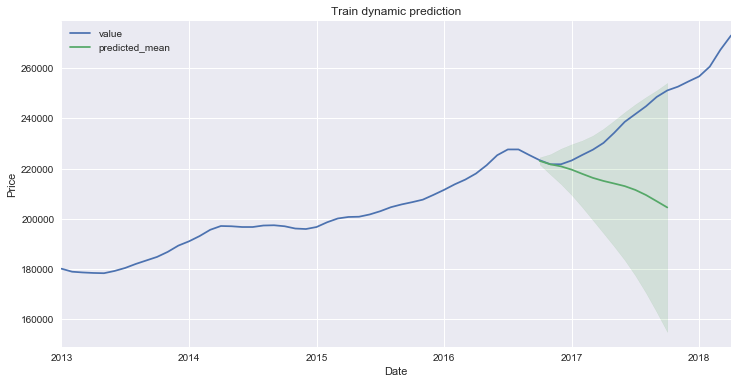

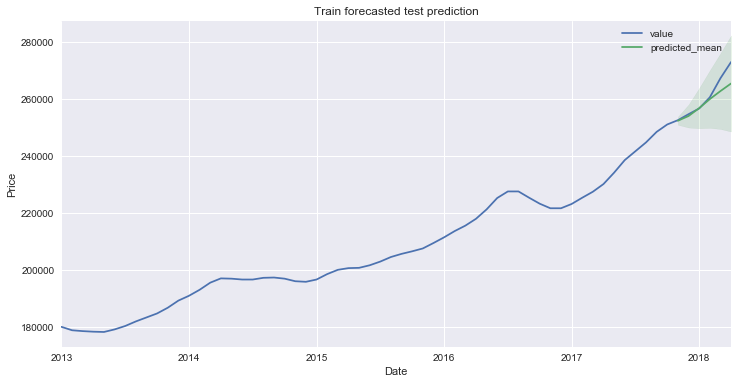

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                   88
Model:             SARIMAX(4, 2, 0)x(1, 0, [1], 12)   Log Likelihood                -566.499
Date:                              Tue, 27 Apr 2021   AIC                           1146.998
Time:                                      15:59:24   BIC                           1162.737
Sample:                                  01-01-2011   HQIC                          1153.250
                                       - 04-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6554      0.107      6.131      0.000       0.446       0.865
ar.L2         -0.8841      0.134     -6.603      0.000      -1.146      -0.622
ar.L3          0.4632      0.125      3.707      0.000       0.218       0.708
ar.L4         -0.3828      0.117     -3.274      0.001      -0.612      -0.154
ar.S.L12       0.2353      0.136      1.737      0.082      -0.030       0.501
ma.S.L12       0.0970      0.157      0.617      0.537      -0.211       0.405
sigma2      6.149e+05   1.12e+05      5.471      0.000    3.95e+05    8.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.72   Prob(JB):                         0.98
Heteroskedasticity (H):               1.78   Skew:                            -0.02
Prob(H) (two-sided):                  0.18   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

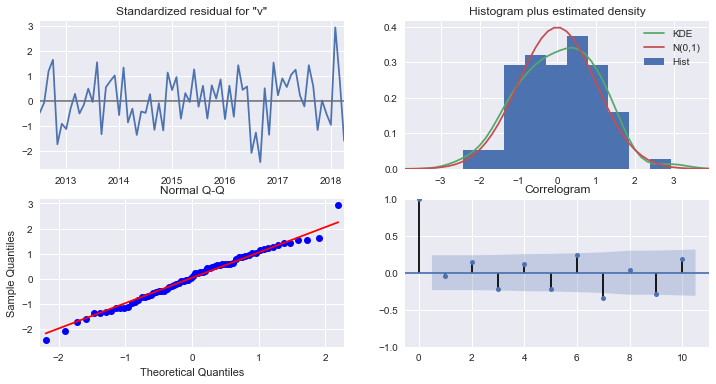

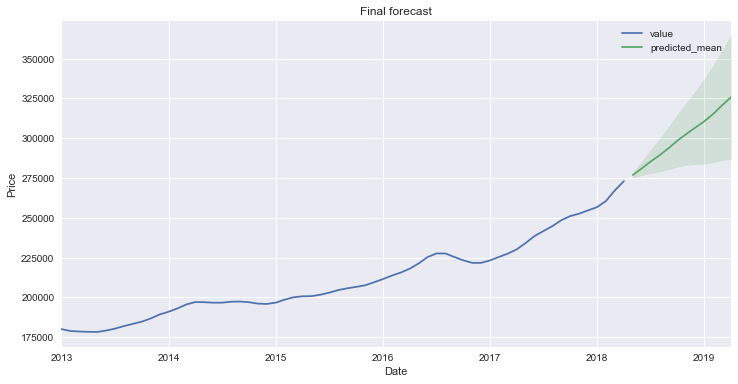

In [254]:
# Running the final zip check

final_model_results = []
final_model_results = Final_zip_Check(
    data=Idaho_25_short_dict['83858'], order=(4, 2, 0), seasonal_order=(1, 0, 1, 12))

# adding zip to the entry
final_model_results.append('83858')

In [255]:
# Adding the results to the dataframe
Final_model_results_df = Final_model_results_df.append(
    pd.Series(final_model_results, index=Final_model_results_df.columns), ignore_index=True)

In [256]:
# Checking to make sure results got added
Final_model_results_df

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high    zip
0  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345  83845
1  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618  83347
2  (2, 2, 0)  (2, 0, 0, 12)      73959.5   2.76408e+07             459282             677.703       215060        699863        836.578           138200          157404              145833               168974  83350
3  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470  83858

### 5th place: Zipcode 83605

Basic information that was provided in the original data.

In [257]:
# information given by original data
data.loc[data['RegionName'] == 83605]

RegionID  RegionName      City State       Metro CountyName  SizeRank  1996-04  1996-05  1996-06  1996-07  1996-08  1996-09  1996-10  1996-11  1996-12  1997-01  1997-02  1997-03  1997-04  1997-05  1997-06  1997-07  1997-08  1997-09  1997-10  1997-11  1997-12  1998-01  1998-02  1998-03  1998-04  1998-05   1998-06   1998-07   1998-08   1998-09   1998-10   1998-11   1998-12   1999-01   1999-02   1999-03   1999-04   1999-05   1999-06   1999-07   1999-08   1999-09   1999-10   1999-11   1999-12   2000-01   2000-02   2000-03   2000-04   2000-05   2000-06   2000-07   2000-08   2000-09   2000-10   2000-11   2000-12   2001-01   2001-02   2001-03   2001-04   2001-05   2001-06  2001-07  2001-08  2001-09  2001-10  2001-11  2001-12  2002-01  2002-02  2002-03  2002-04  2002-05  2002-06  2002-07  2002-08  2002-09  2002-10  2002-11  2002-12  2003-01  2003-02  2003-03  2003-04  2003-05  2003-06  2003-07  2003-08  2003-09  2003-10  2003-11  2003-12  2004-01  2004-02  2004-03  2004-04  2004-05  \
3074     94220       83605  Caldwell    ID  Boise City     Canyon      3075  81500.0  81400.0  81400.0  81600.0  81800.0  82200.0  82800.0  83500.0  84400.0  85400.0  86500.0  87800.0  89100.0  90300.0  91500.0  92600.0  93500.0  94300.0  95100.0  95900.0  96500.0  97100.0  97700.0  98400.0  99100.0  99800.0  100400.0  101100.0  101800.0  102400.0  102900.0  103400.0  103800.0  104100.0  104200.0  104300.0  104200.0  104200.0  104100.0  104000.0  104000.0  103900.0  103800.0  103800.0  103800.0  103800.0  103700.0  103700.0  103700.0  103700.0  103800.0  104000.0  104300.0  104600.0  105000.0  105300.0  105400.0  105400.0  105200.0  104600.0  103500.0  102100.0  100300.0  98200.0  95900.0  93800.0  91900.0  90200.0  88900.0  87900.0  87200.0  86800.0  86600.0  86500.0  86600.0  86900.0  87300.0  87800.0  88400.0  89000.0  89600.0  90300.0  90900.0  91600.0  92400.0  93100.0  93800.0  94500.0  95200.0  95700.0  96200.0  96600.0  96900.0  97200.0  97600.0  98100.0  98700.0  99400.0   

       2004-06   2004-07   2004-08   2004-09   2004-10   2004-11   2004-12   2005-01   2005-02   2005-03   2005-04   2005-05   2005-06   2005-07   2005-08   2005-09   2005-10   2005-11   2005-12   2006-01   2006-02   2006-03   2006-04   2006-05   2006-06   2006-07   2006-08   2006-09   2006-10   2006-11   2006-12   2007-01   2007-02   2007-03   2007-04   2007-05   2007-06   2007-07   2007-08   2007-09   2007-10   2007-11   2007-12   2008-01   2008-02   2008-03   2008-04   2008-05   2008-06   2008-07   2008-08   2008-09   2008-10   2008-11   2008-12   2009-01   2009-02   2009-03   2009-04   2009-05   2009-06   2009-07   2009-08   2009-09   2009-10   2009-11   2009-12   2010-01   2010-02   2010-03   2010-04   2010-05   2010-06   2010-07   2010-08   2010-09   2010-10  2010-11  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  2011-06  2011-07  2011-08  2011-09  2011-10  2011-11  2011-12  2012-01  2012-02  2012-03  2012-04  2012-05  2012-06  2012-07  2012-08  2012-09  2012-10  \
3074  100200.0  101100.0  101900.0  102800.0  103500.0  104100.0  104700.0  105200.0  105800.0  106400.0  107000.0  107700.0  108300.0  108800.0  109400.0  110100.0  110800.0  111500.0  112300.0  113200.0  114300.0  115900.0  118000.0  120300.0  122700.0  125200.0  127700.0  130200.0  132700.0  135100.0  137500.0  139700.0  141300.0  142800.0  144500.0  145900.0  147000.0  147800.0  148500.0  149400.0  150200.0  150900.0  151500.0  151700.0  151100.0  150300.0  149300.0  148200.0  146600.0  144400.0  142100.0  140100.0  138400.0  136700.0  135000.0  133400.0  131600.0  129700.0  127900.0  125900.0  123700.0  121900.0  120900.0  120500.0  120200.0  119700.0  119500.0  119500.0  119800.0  118100.0  113900.0  109900.0  107700.0  105800.0  103800.0  101700.0  100200.0  98300.0  95300.0  93100.0  92600.0  92800.0  93400.0  93900.0  94700.0  95800.0  95600.0  93400.0  91000.0  90200.0  90600.0  90300.0  89100.0  88900.0  89900.0  91200.0  91500.0  91900.0  93100.0  94900.0  96200.0   

      2012-11  2012-

In [258]:
# Results given from the initial model
results_df_ROI_sorted.iloc[4]

order                           (0, 2, 0)
seasonal_order              (0, 0, 0, 12)
train_mse                          116154
train_dyn_mse                    8.68e+06
train_forecast_mse               2.18e+06
train_forecast_rmse               1476.48
final_mse                          265714
final_dyn_mse                 1.94686e+07
final_dyn_rmse                    4412.32
last_known_price                   166800
1_year_forecast                    195600
1_year_forecast_low                168514
1_year_forecast_high               222686
1_year_forecast_ROI              0.172662
1_year_forecast_variance          54171.9
Name: 83605, dtype: object

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   82
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -610.102
Date:                Tue, 27 Apr 2021   AIC                           1222.203
Time:                        15:59:26   BIC                           1224.573
Sample:                    01-01-2011   HQIC                          1223.152
                         - 10-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.988e+05   3.33e+04      8.963      0.000    2.33e+05    3.64e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.96   Jarque-Bera (JB):                16.07
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

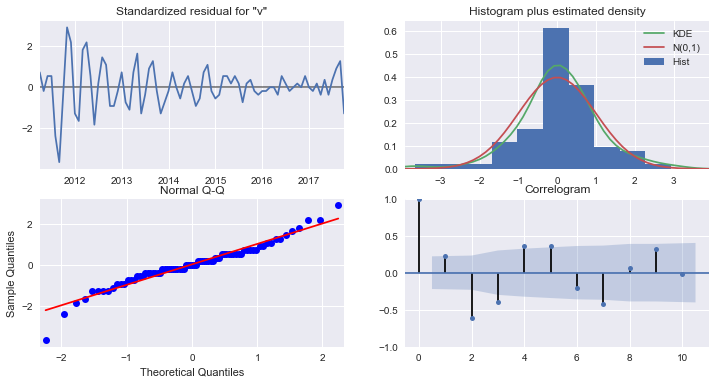

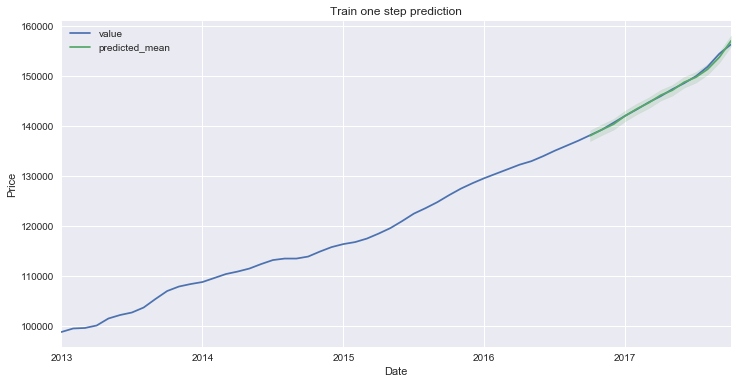

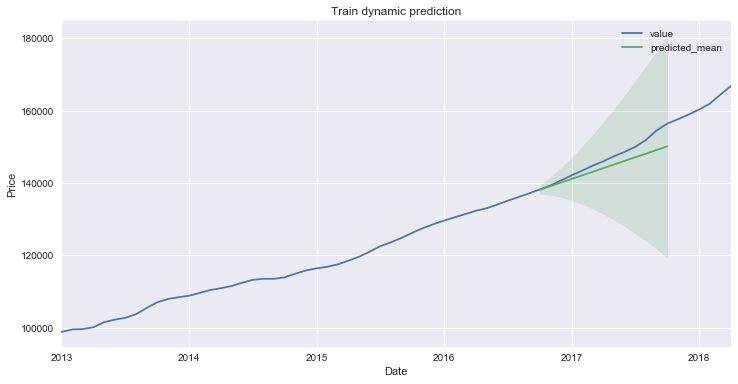

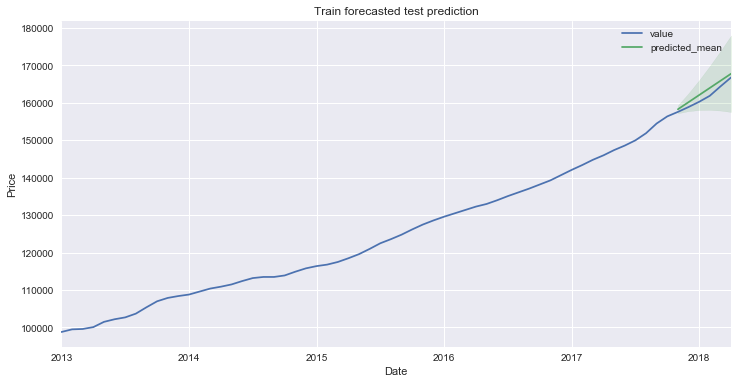

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   88
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -655.725
Date:                Tue, 27 Apr 2021   AIC                           1313.449
Time:                        15:59:27   BIC                           1315.892
Sample:                    01-01-2011   HQIC                          1314.432
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.938e+05   3.19e+04      9.211      0.000    2.31e+05    3.56e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.62   Jarque-Bera (JB):                16.24
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

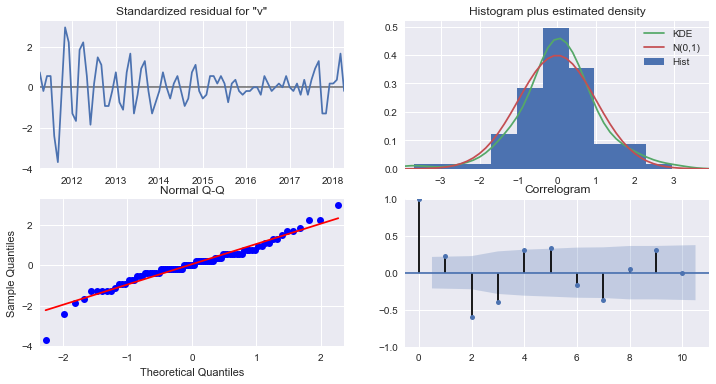

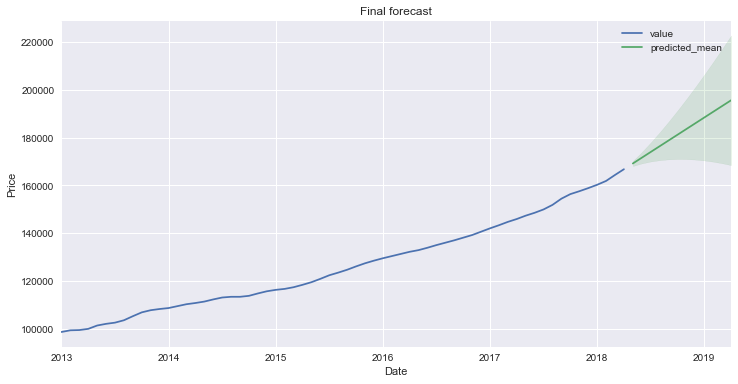

195600.0

In [259]:
# Checking the parameters chosen by auto_arima
Manual_Param_Check(Idaho_25_short_dict['83605'], order=(0,2,0), seasonal_order=(0,0,0,12))

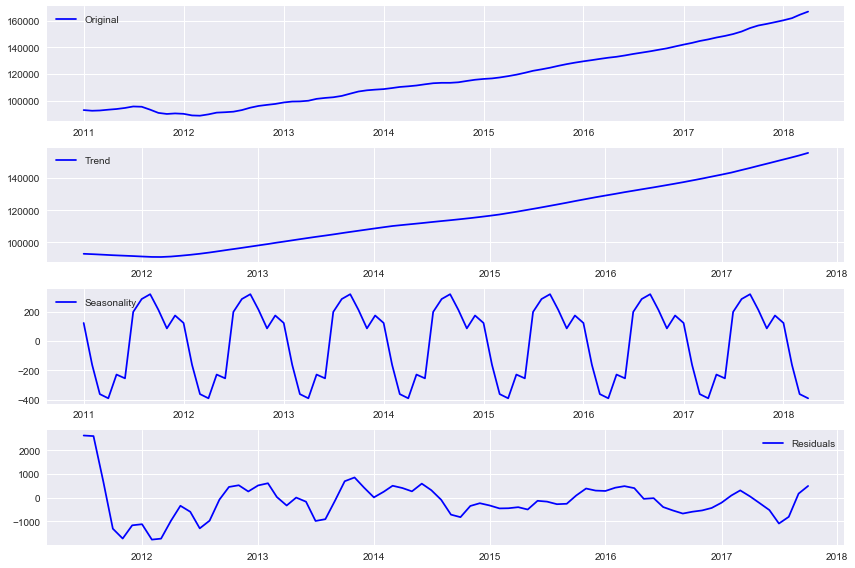

In [260]:
# Checking the seasonality
Seasonal_check(Idaho_25_short_dict['83605'])

83605 ACF and PACF


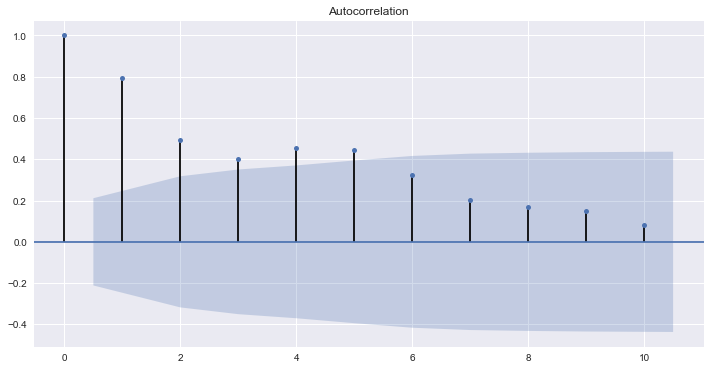

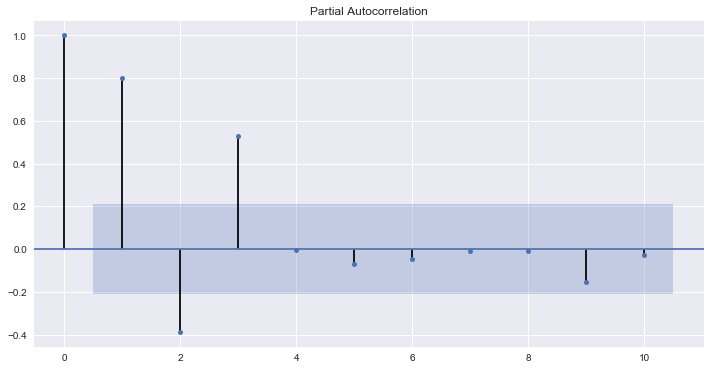

In [261]:
print('83605 ACF and PACF')
xr = Idaho_25_short_dict['83605'].diff(2).dropna()
plot_acf(xr, lags=10);
plot_pacf(xr, lags=10);

Seasonal ACF and PACF


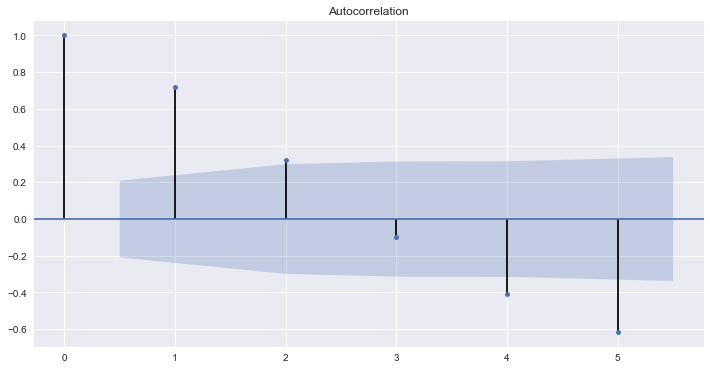

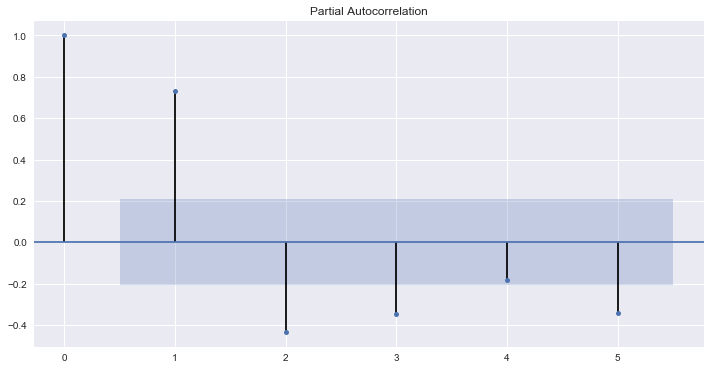

In [262]:
print('Seasonal ACF and PACF')
decomposition = seasonal_decompose(Idaho_25_short_dict['83605'])
season = decomposition.seasonal
plot_acf(season, lags=5);
plot_pacf(season, lags=5);

In [263]:
# Checking possible combinations of parameters
orderlist = [(0,2,0),(1,2,0),(1,2,1),(1,2,2),(2,2,0),(2,2,1)]
seasonallist = [(0,0,0,12),(1,0,0,12),(0,0,1,12),(1,0,1,12),(1,0,2,12),(2,0,0,12),(2,0,1,12)]
possible_params = Grid_Auto_bot(data=Idaho_25_short_dict['83605'],order_list=orderlist, seasonal_list=seasonallist)

ARIMA (0, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1222.2032025552915
ARIMA (0, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =1019.4073288279109
ARIMA (0, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =999.6229836399906
ARIMA (0, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =997.6540301870158


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (0, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2300.3418747008545
ARIMA (0, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =801.2376416254377
ARIMA (0, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =801.9465912530876
ARIMA (1, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1219.7954205865003
ARIMA (1, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =998.8110731289618
ARIMA (1, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =999.3534420950788
ARIMA (1, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =997.6178071584874


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2296.627812908627
ARIMA (1, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =787.3459456616603


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =788.2219695637409
ARIMA (1, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1189.197176354173
ARIMA (1, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =990.5760610523403
ARIMA (1, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =972.7769418352209
ARIMA (1, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =967.5135207408773


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =2548.7957383448065
ARIMA (1, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =788.2674289666429
ARIMA (1, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =789.3354431701431
ARIMA (1, 2, 2) x (0, 0, 0, 12)12 : AIC Calculated =1165.8974900505086
ARIMA (1, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =972.9533935883129
ARIMA (1, 2, 2) x (0, 0, 1, 12)12 : AIC Calculated =940.8691542668504
ARIMA (1, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =941.0573355275709


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =2435.4518949758744
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =783.1320550157084


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =783.650694339034
ARIMA (2, 2, 0) x (0, 0, 0, 12)12 : AIC Calculated =1150.185134950439
ARIMA (2, 2, 0) x (1, 0, 0, 12)12 : AIC Calculated =945.3745743684464
ARIMA (2, 2, 0) x (0, 0, 1, 12)12 : AIC Calculated =960.5027612742745
ARIMA (2, 2, 0) x (1, 0, 1, 12)12 : AIC Calculated =946.9518736319528


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 2, 0) x (1, 0, 2, 12)12 : AIC Calculated =2477.894403396629
ARIMA (2, 2, 0) x (2, 0, 0, 12)12 : AIC Calculated =764.1698018637245
ARIMA (2, 2, 0) x (2, 0, 1, 12)12 : AIC Calculated =763.9222723995755
ARIMA (2, 2, 1) x (0, 0, 0, 12)12 : AIC Calculated =1151.9551481797184
ARIMA (2, 2, 1) x (1, 0, 0, 12)12 : AIC Calculated =942.1623788583579
ARIMA (2, 2, 1) x (0, 0, 1, 12)12 : AIC Calculated =945.5827900299635
ARIMA (2, 2, 1) x (1, 0, 1, 12)12 : AIC Calculated =944.1534243649016


/Users/stevenkyle/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA (2, 2, 1) x (1, 0, 2, 12)12 : AIC Calculated =1864.4805670914225
ARIMA (2, 2, 1) x (2, 0, 0, 12)12 : AIC Calculated =761.1129696385516
ARIMA (2, 2, 1) x (2, 0, 1, 12)12 : AIC Calculated =762.9258985507904


In [264]:
# Ordering the parameters by aic
possible_params.sort_values(by='aic', ascending=True, inplace=True)
possible_params.head()

pdq           pdqs         aic
40  (2, 2, 1)  (2, 0, 0, 12)  761.112970
41  (2, 2, 1)  (2, 0, 1, 12)  762.925899
34  (2, 2, 0)  (2, 0, 1, 12)  763.922272
33  (2, 2, 0)  (2, 0, 0, 12)  764.169802
26  (1, 2, 2)  (2, 0, 0, 12)  783.132055

Train_model summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   82
Model:             SARIMAX(2, 2, 1)x(2, 0, [], 12)   Log Likelihood                -374.556
Date:                             Tue, 27 Apr 2021   AIC                            761.113
Time:                                     15:59:44   BIC                            773.047
Sample:                                 01-01-2011   HQIC                           765.715
                                      - 10-01-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1987      0.109      1.821      0.069      -0.015       0.412
ar.L2         -0.4171      0.153     -2.729      0.006      -0.717      -0.118
ma.L1         -0.1941      0.131     -1.478      0.139      -0.452       0.063
ar.S.L12       0.0364      0.143      0.255      0.798      -0.243       0.316
ar.S.L24      -0.2344      0.102     -2.306      0.021      -0.434      -0.035
sigma2      6.207e+04   1.16e+04      5.365      0.000    3.94e+04    8.47e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.10
Prob(Q):                              0.97   Prob(JB):                         0.58
Heteroskedasticity (H):               1.78   Skew:                             0.21
Prob(H) (two-sided):                  0.23   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

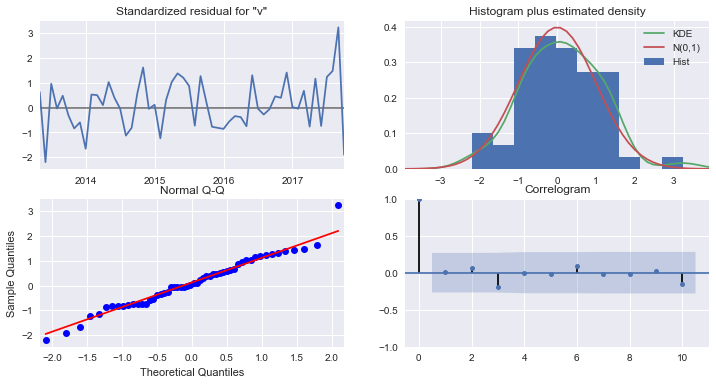

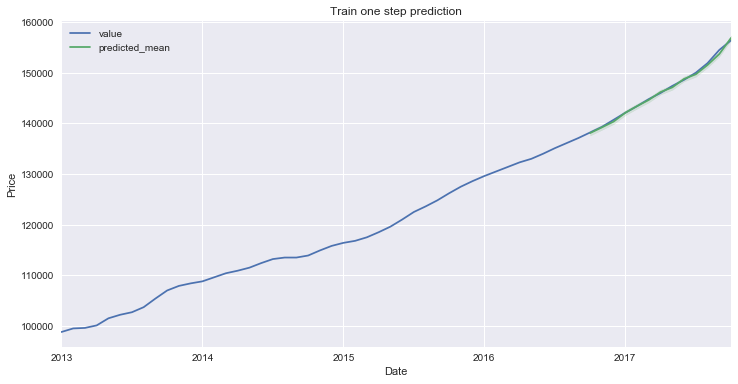

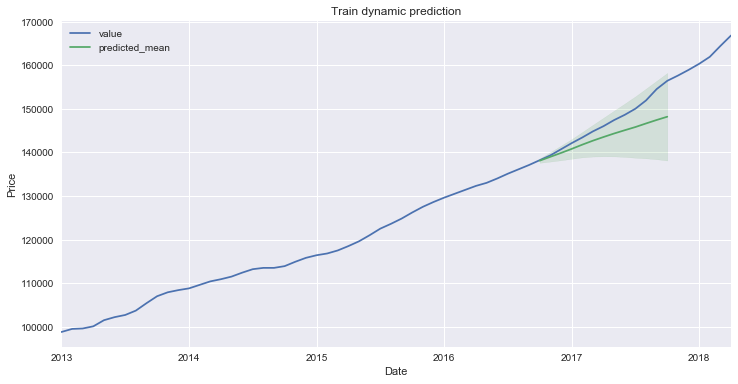

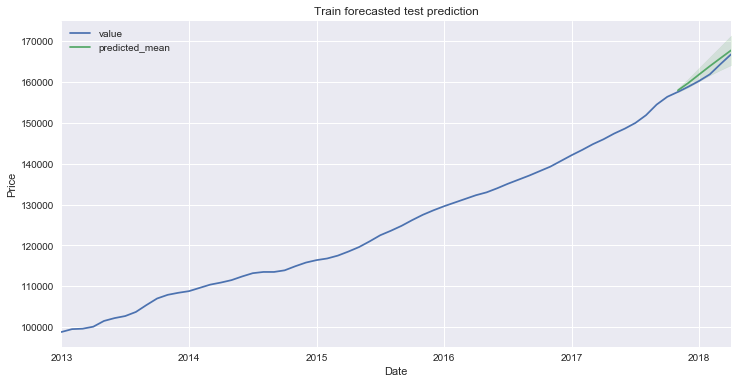

Final_output summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               value   No. Observations:                   88
Model:             SARIMAX(2, 2, 1)x(2, 0, [], 12)   Log Likelihood                -421.187
Date:                             Tue, 27 Apr 2021   AIC                            854.375
Time:                                     15:59:45   BIC                            866.941
Sample:                                 01-01-2011   HQIC                           859.290
                                      - 04-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3108      0.121      2.568      0.010       0.074       0.548
ar.L2         -0.4283      0.131     -3.259      0.001      -0.686      -0.171
ma.L1         -0.2160      0.147     -1.470      0.142      -0.504       0.072
ar.S.L12       0.0756      0.170      0.444      0.657      -0.258       0.409
ar.S.L24      -0.2227      0.124     -1.797      0.072      -0.466       0.020
sigma2      7.323e+04   1.13e+04      6.500      0.000    5.12e+04    9.53e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 6.08
Prob(Q):                              1.00   Prob(JB):                         0.05
Heteroskedasticity (H):               2.17   Skew:                             0.48
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

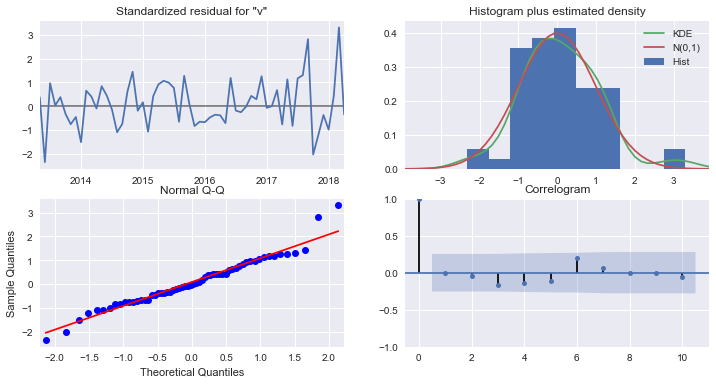

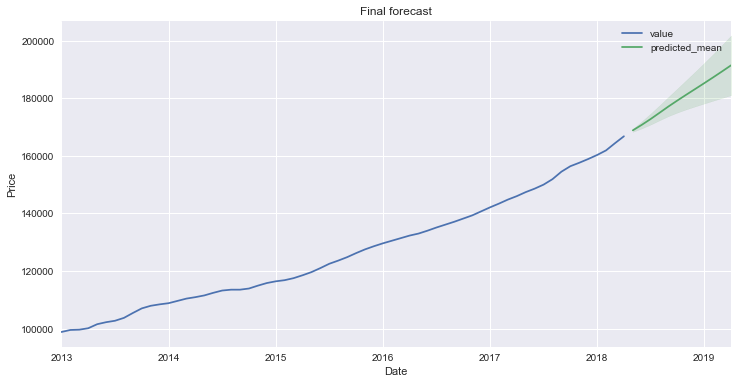

In [265]:
# Running the final zip check

final_model_results = []
final_model_results = Final_zip_Check(
    data=Idaho_25_short_dict['83605'], order=(2, 2, 1), seasonal_order=(2, 0, 0, 12))

# adding zip to the entry
final_model_results.append('83605')

In [266]:
# Adding the results to the dataframe
Final_model_results_df = Final_model_results_df.append(
    pd.Series(final_model_results, index=Final_model_results_df.columns), ignore_index=True)

## Final dataframe for the models results

In [267]:
#Changing the index of the final model dataframe to zipcodes
Final_model_results_df.set_index('zip',inplace=True)
Final_model_results_df

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high
zip                                                                                                                                                                                                                  
83845  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345
83347  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618
83350  (2, 2, 0)  (2, 0, 0, 12)      73959.5   2.76408e+07             459282             677.703       215060        699863        836.578           138200          157404              145833               168974
83858  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470
83605  (2, 2, 1)  (2, 0, 0, 12)       110138   1.54928e+07        1.77054e+06             1330.62       185765   8.70877e+06        2951.06           166800          191461              181089               201833

In [268]:
# Creating a new column in final df for the 1_year_future_ROI
Final_model_results_df['1_year_forecast_ROI'] = (
    Final_model_results_df['1_year_forecast'] - Final_model_results_df['last_known_price']) / Final_model_results_df['last_known_price']

# Creating a new column in final df for low 1_year_future_ROI
Final_model_results_df['1_year_forecast_low_ROI'] = (
    Final_model_results_df['1_year_forecast_low'] - Final_model_results_df['last_known_price']) / Final_model_results_df['last_known_price']


# Creating a new column in final df for high 1_year_future_ROI
Final_model_results_df['1_year_forecast_high_ROI'] = (
    Final_model_results_df['1_year_forecast_high'] - Final_model_results_df['last_known_price']) / Final_model_results_df['last_known_price']

print('Results from fine tuning the initial models.')
Final_model_results_df

Results from fine tuning the initial models.


order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_low_ROI 1_year_forecast_high_ROI
zip                                                                                                                                                                                                                                                                                       
83845  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345            0.126689               0.0105125                 0.242866
83347  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618           0.0548518               -0.016179                 0.125883
83350  (2, 2, 0)  (2, 0, 0, 12)      73959.5   2.76408e+07             459282             677.703       215060        699863        836.578           138200          157404              145833               168974            0.138955               0.0552312                 0.222678
83858  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470             0.19321               0.0513658                 0.335054
83605  (2, 2, 1)  (2, 0, 0, 12)       110138   1.54928e+07        1.77054e+06             1330.62       185765   8.70877e+06        2951.06           166800          191461              181089               201833            0.147849               0.0856669                  0.21003

In [269]:
print('Results from the autoarima method')
results_df_ROI_sorted.head()

Results from the autoarima method


order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_variance
zip                                                                                                                                                                                                                                                               
83845  (0, 2, 0)  (0, 0, 0, 12)  3.78538e+06   2.77442e+08        1.59527e+08             12630.4  4.63857e+06   6.72966e+08        25941.6           232000          294400              244189               344611            0.268966                   100421
83347  (0, 2, 0)  (0, 0, 0, 12)       510769     7.958e+07         1.2295e+07             3506.42  3.35429e+06   1.05701e+08        10281.1           162200          195800              164651               226949            0.207152                  62298.5
83350  (0, 2, 0)  (0, 0, 0, 12)      82307.7   4.48169e+07             728333             853.424       324286        650000        806.226           138200          165800              150192               181408            0.199711                  31216.2
83858  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470             0.19321                  77446.8
83605  (0, 2, 0)  (0, 0, 0, 12)       116154      8.68e+06           2.18e+06             1476.48       265714   1.94686e+07        4412.32           166800          195600              168514               222686            0.172662                  54171.9

# Conclusion

Out of the 110 zipcodes that were given for Idaho, 108 passed the criteria of being at least 10 years old. The 108 zipcodes were screened down to the top 25 by their most recent 5 year ROI. An initial model was created for each of the 25 zipcodes and then a future 1 year ROI was calculated. These 5 zipcodes were determined to be the best to invest in for the highest returns. To finalize the models a fine tuned model was created for the determined 5 zipcodes and future predicitions were updated with the finalized models. The finalized models gave lower ROI than the initial model but the one year returns were still generally high. The only zipcode that warrants caution is zipcode 83347, which gave a significantly lower ROI. However, zipcode 83347 has a dip in prices for the most recent 6 months, which I believe is an anomaly. This dip seems to be significantly affecting the prediction and making the model predict similar variations for future prices.

looking at the model more closely, the model seems to be basing a lot of the predictions off of data for the most recent 6 months which I believe is an annomaly.

The top 5 zipcodes to invest are:
* 83858
* 83605
* 83350
* 83845
* 83347

Recommendation:
From my analysis it seems that smaller communities are experiencing more growth than larger communities. Also areas that have less than 300,000 median housing prices seem to experience a greater ROI.

A dataframe for the model output/model paramaters can be seen below.

In [270]:
Final_model_results_df

order seasonal_order    train_mse train_dyn_mse train_forecast_mse train_forecast_rmse    final_mse final_dyn_mse final_dyn_rmse last_known_price 1_year_forecast 1_year_forecast_low 1_year_forecast_high 1_year_forecast_ROI 1_year_forecast_low_ROI 1_year_forecast_high_ROI
zip                                                                                                                                                                                                                                                                                       
83845  (1, 2, 2)  (2, 0, 0, 12)  1.48013e+06    7.5818e+07        3.53336e+07              5944.2  1.44655e+06    5.5985e+07        7482.31           232000          261392              234439               288345            0.126689               0.0105125                 0.242866
83347  (2, 2, 1)  (2, 0, 0, 12)       456123   4.93516e+07        1.67486e+07             4092.51  1.07417e+06   7.09517e+07        8423.29           162200          171097              159576               182618           0.0548518               -0.016179                 0.125883
83350  (2, 2, 0)  (2, 0, 0, 12)      73959.5   2.76408e+07             459282             677.703       215060        699863        836.578           138200          157404              145833               168974            0.138955               0.0552312                 0.222678
83858  (4, 2, 0)  (1, 0, 1, 12)       645798   5.80807e+08        1.29773e+07              3602.4    1.258e+06   1.62194e+07        4027.33           273000          325746              287023               364470             0.19321               0.0513658                 0.335054
83605  (2, 2, 1)  (2, 0, 0, 12)       110138   1.54928e+07        1.77054e+06             1330.62       185765   8.70877e+06        2951.06           166800          191461              181089               201833            0.147849               0.0856669                  0.21003

# Future Work

* The next step for this project is to create a fine tuned model for all the top 25 zipcodes with the highest 5 year ROI. 
* Make 3 different portfolios that take into account the risk factor (Aggressive, Hybrid, Conservative)  
* If more analysis needs to be done then I believe it might be worthwhile to make a fine tuned model for all 110 zipcodes in Idaho.

# Scratch work and blog post

In [ ]:
#58min
Idaho_25_dict.keys()

In [ ]:
BlogData = Idaho_25_dict['83703']['2011':]
BlogData.head()

In [ ]:
BlogData.head()

In [ ]:
len(BlogData)

In [ ]:
BlogData.plot()
plt.title('Zipcode 83703');
plt.xlabel('Date');
plt.ylabel('Median Housing Price');

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Taking the decomposition
decomposition = seasonal_decompose(BlogData)

# Gathering and plotting the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(4,1,1)
plt.plot(Idaho_25_dict['83703']['2011':], label='Original', color='blue')
plt.legend(loc='best')
plt.title('Seasonal Decompose')
plt.ylabel('price')
plt.subplot(4,1,2)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.ylabel('price')
plt.subplot(4,1,3)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='upper left', fontsize='x-small')
plt.ylabel('price')
plt.subplot(4,1,4)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.ylabel('price')
plt.xlabel('Date')
plt.tight_layout()

In [ ]:
ax = seasonal.plot(label='Seasonality', color='blue')

min_ = seasonal.idxmin()
max_ = seasonal.idxmax()
min_2 = seasonal[max_:].idxmin()
max_2 = seasonal[min_2:].idxmax()

ax.axvline(min_,label='min 1',c='red')
ax.axvline(min_2,label='min 2',c='red', ls=':')
ax.axvline(max_,label='max 1',c='green')
ax.axvline(max_2,label='max 2',c='green', ls=':')
plt.legend(loc='upper right', fontsize='x-small')

print(f'The time difference between the two minimums is {min_2-min_}')

In [ ]:
train, test = train_test_split(BlogData, train_size=72)

auto_model = pm.auto_arima(y=train, start_p=0, start_q=0, max_p=5, max_q=5,
                           start_P=0, start_Q=0, max_P=5, max_Q=5, m=12,
                           max_order=None,trace=True)



In [ ]:
display(auto_model.summary())
auto_model.plot_diagnostics(figsize=(12,6));

In [ ]:
Final_model = SARIMAX(train.astype('int'),
                    order=(0,2,2),
                    seasonal_order=(1,0,0,12),
                    enforce_invertibility=False,
                    enforce_stationarity=False)
Final_output = Final_model.fit()
display(Final_output.summary());
Final_output.plot_diagnostics();

In [ ]:
forecast = Final_output.get_forecast(steps = 16)
forecast_conf = forecast.conf_int()

# Plot observed values
ax = Idaho_25_dict['83703']['2013':].plot()

# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='dynamic', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Creating Final SARIMAX model
Final_model = SARIMAX(train.astype('int'),
                    order=auto_model.order,
                    seasonal_order=auto_model.seasonal_order,
                    enforce_invertibility=False,
                    enforce_stationarity=False)
Final_output = Final_model.fit()
display(Final_output.summary());
Final_output.plot_diagnostics();

# Getting the forecast for 16 months
forecast = Final_output.get_forecast(steps = 16)
forecast_conf = forecast.conf_int()

# Plot observed values
ax = BlogData['2013':].plot()

# Plot forecasted values
forecast.predicted_mean.plot(ax=ax, label='Forecast', color='red', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(forecast_conf.index,
                forecast_conf.iloc[:, 0],
                forecast_conf.iloc[:, 1], color='g', alpha=0.1)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()